## Load modules & data

In [0]:
#Base
from glob import glob
import sys, os, pdb
import numpy as np
import xarray as xr
import pandas as pd
import scipy.stats as st
from scipy.spatial import KDTree
from tqdm.notebook import trange, tqdm

#Plot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
color_names=['amber','red','windows blue','faded green',
             'dusty purple',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)

#V1DD
from allen_v1dd.client import OPhysClient, EMClient
from allen_v1dd.stimulus_analysis import analysis_tools as at
at.set_stylesheet()

# EM-coregistration Github
# https://github.com/RussTorres/em_coregistration/tree/rmt_working_branch
sys.path.append('/home/david.wyrick/Git/em_coregistration/')
import coregister
import coregister.transform
# import coregister.data_loader
from coregister.process.affine_matrices import transform_pts
from coregister.process.roi import center_from_pix_mask
from coregister.io.read_nwb import ROI_mask_nwb

#Cave
import requests
from requests.auth import HTTPBasicAuth
import caveclient

%matplotlib inline
%load_ext autoreload
%autoreload 2

em_final_voxel_size = np.array([4.85, 4.85, 45])

PlotDir = '/home/david.wyrick/projects/V1DD/coregistration/plots'


def get_array_subset_indices(set_arr, subset_arr):
    set_arr_sorted = np.argsort(set_arr)
    subset_arr_pos = np.searchsorted(set_arr[set_arr_sorted], subset_arr)
    indices = set_arr_sorted[subset_arr_pos]
    return indices

def chaseROI_to_russelROI(key_list):
    new_key_list = []; roi_list = []; plane_list = []
    for chase_key in key_list:
        split = chase_key.split('_')
        pp = int(split[2])-1
        rr = int(split[3])

        russel_key = f'plane{pp}_roi_{rr:04d}'
        new_key_list.append(russel_key)
        # print(f'{chase_key:20s} \t->\t',russel_key)
        plane_list.append(pp)
        roi_list.append(rr)

    return new_key_list, plane_list, roi_list

def russelROI_to_chaseROI(key_list):
    new_key_list = []; roi_list = []; plane_list = []
    for russel_key in key_list:
        split = russel_key.split('_')
        pp = int(split[0][-1])+1
        rr = int(split[2])

        chase_key = f'M409828_13_{pp}_{rr}'
        new_key_list.append(chase_key)
        # print(f'{russel_key:20s} \t->\t',chase_key)
        plane_list.append(pp)
        roi_list.append(rr)

    return new_key_list, plane_list, roi_list

def calculate_hash(quad_xy):
    
    #Define cells A & B
    max = 0
    for i in range(4):
        for j in range(4):
            dist = np.linalg.norm(quad_xy[j]-quad_xy[i])
            if dist > max:
                i_a = i; i_b = j
                max = dist
                
    A_xy = quad_xy[i_a]
    B_xy = quad_xy[i_b]
    
    #Calculate local coordinates
    quad_xy_local =  (quad_xy - A_xy)/(B_xy - A_xy)
    
    #Define C&D relative to the coordinate system defined by A-B
    i_cd = np.setxor1d([i_a,i_b],np.arange(4))

    #Break C/D symmetry by x_c <= x_d & x_c + x_d<=1
    if quad_xy_local[i_cd][0,0] < quad_xy_local[i_cd][1,0]:
        i_c = i_cd[0]; i_d = i_cd[1]
    else:
        i_c = i_cd[1]; i_d = i_cd[0]
        
    #Create hash based on CD local coordinates
    quad_hash = np.concatenate((quad_xy_local[i_c],quad_xy_local[i_d]))
    
    #Make sure pts C & D are within the circle defined by A & B
    #Check to make sure x_c + x_d is less than 1
    if (np.any(np.abs(quad_hash) > 1)) | (np.any(quad_hash < 0)) | ((quad_hash[0] + quad_hash[2]) >= 1) | (np.any(np.abs(B_xy - A_xy) < 1)):
        error = 1
    else: 
        error = 0
    
    i_abcd = np.array([i_a,i_b,i_c,i_d])
    
    return quad_hash, i_abcd, error  

def plot_quad(quad_xy, i_abcd=None,ax=None,polygon_c=None,label=None,line_alpha=0.25,line_width=1):
    if np.all(i_abcd==None):
        i_a = 0; i_b = 1; i_c = 2; i_d = 3
    else:
        i_a, i_b, i_c, i_d = i_abcd

    if ax == None:
        fig, ax = plt.subplots(figsize=(8,8))
    
    if polygon_c == None:
        polygon_c == cc(0)
    # ax.scatter(quad_xy[i_a,0],quad_xy[i_a,1],marker='$A$',color=color_palette[0],s=55,zorder=2)
    # ax.scatter(quad_xy[i_b,0],quad_xy[i_b,1],marker='$B$',color=color_palette[1],s=55,zorder=2)
    # ax.scatter(quad_xy[i_c,0],quad_xy[i_c,1],marker='$C$',color=color_palette[2],s=55,zorder=2)
    # ax.scatter(quad_xy[i_d,0],quad_xy[i_d,1],marker='$D$',color=color_palette[3],s=55,zorder=2)
    
    ax.plot(quad_xy[np.array([i_a,i_d,i_b,i_c,i_a]),0],quad_xy[np.array([i_a,i_d,i_b,i_c,i_a]),1],color='k',alpha=line_alpha,zorder=1,lw=line_width)
    poly = Polygon(quad_xy[np.array([i_a,i_d,i_b,i_c])], facecolor=polygon_c, alpha=0.1,label=label)
    ax.add_patch(poly)
 
    
# coreg_table_russelkeys, _, _ = chaseROI_to_russelROI(coreg_table['roi'].values)
scalar = 1000
cc  = sns.color_palette("icefire", as_cmap=True)
cc2  = sns.color_palette("Spectral", as_cmap=True)

In [1]:
# matrix that describes the transformation from the input functional space (in pixels) to the coregistration space (in microns) and its inverse
func_raw2coreg_tform_fn = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/transforms/func_raw2coreg_tform.npy"
func_raw2coreg_tform = np.load(func_raw2coreg_tform_fn)
func_coreg2raw_tform = np.linalg.inv(func_raw2coreg_tform)

# matrix that describes the transformation from the input EM coregistration space (in microns) to the final EM space (in voxels)
em_coreg2final_tform_fn = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/transforms/em_coreg2final_tform.npy"
em_coreg2final_tform = np.load(em_coreg2final_tform_fn)
em_final2coreg_tform = np.linalg.inv(em_coreg2final_tform)

In [2]:
coreg_df = pd.read_csv('/home/david.wyrick/Git/allen_v1dd/data_frames/coreg_cells_table_20230612.csv',index_col=0)
coreg_df = coreg_df.convert_dtypes()
coreg_roi_ids = coreg_df['chase_key'].values
coreg_em_ids  = coreg_df['em_id'].values
em_coreg = np.array(coreg_df[['pt_position_x','pt_position_y','pt_position_z']],dtype=float)
ophys_coreg = np.array(coreg_df[['ophys_x','ophys_y','ophys_z']],dtype=float)



In [27]:

em_origin = np.array([-802,50,-722])
volume_thresh = 150
em_client = EMClient()

#Create query box of potential EM objects this ophys data could be coregistered to

# query_bbox = np.array([min_nm - buffer,max_nm + buffer])
#Get all cells in EM volume within bounding region
nucleus_table = em_client.materialize.query_table(
    "nucleus_detection_v0")#,filter_spatial_dict={"pt_position": query_bbox})

## Load EM data
nucleus_table = em_client.query_table('nucleus_detection_v0')
nucleus_table = nucleus_table.loc[nucleus_table.volume > volume_thresh]
nucleus_table.reset_index(inplace=True)

#Extract point position 
nucleus_pts = np.array([i for i in nucleus_table.pt_position])
nucleus_ids = np.array([i for i in nucleus_table.id])

#Standard transform
nucleus_points_microns = em_client.transform_position_to_microns(nucleus_pts)
# nucleus_points_microns = nucleus_points_microns - em_origin
nucleus_table['em_microns'] = None

for ii in range(len(nucleus_points_microns)):
    nucleus_table.at[ii,'em_microns'] = nucleus_points_microns[ii]

nucleus_table = nucleus_table.set_index('id')
nucleus_table

index                          created  superceded_id valid  \
id                                                                     
228132       0 2022-02-04 06:21:10.292663+00:00            NaN     t   
203262       2 2022-02-04 06:21:10.297516+00:00            NaN     t   
350562       3 2022-02-04 06:21:10.300143+00:00            NaN     t   
718122       4 2022-02-04 06:21:10.302911+00:00            NaN     t   
680726       5 2022-02-04 06:21:10.305207+00:00            NaN     t   
...        ...                              ...            ...   ...   
267622  207448 2022-02-04 06:31:31.242501+00:00            NaN     t   
382516  207449 2022-02-04 06:31:31.243847+00:00            NaN     t   
168582  207451 2022-02-04 06:31:31.246802+00:00            NaN     t   
29422   207452 2022-02-04 06:31:31.248226+00:00            NaN     t   
422767  207453 2022-02-04 06:31:31.249663+00:00            NaN     t   

            volume    pt_supervoxel_id          pt_root_id  \
id                                                           
228132  458.464831   87485049993200655  864691132737039043   
203262  338.276613   87197526360541948  864691132654552792   
350562  326.965400   94866276031228266  864691132773514104   
718122  333.888647  118515535938912588  864691132774106773   
680726  706.847075  115982398587674903  864691132780109973   
...            ...                 ...                 ...   
267622  349.824934   93527689948393260  864691133046970980   
382516  173.763515   96074570859091110  864691132720900052   
168582  369.919126   83482550844689534  864691133042980384   
29422   285.031368                   0                   0   
422767  394.724290   99723368244567127  864691132851361283   

                      pt_position         bb_start_position  \
id                                                            
228132   [632828, 749849, 738270]   [626620, 746124, 78876]   
203262   [624680, 531094, 283770]   [619869, 525818, 30089]   
350562   [894573, 478559, 163530]   [891003, 473981, 17111]   
718122  [1729859, 674111, 781200]  [1722177, 667205, 83852]   
680726  [1640231, 677370, 768015]  [1635265, 671938, 82014]   
...                           ...                       ...   
267622   [847392, 420980, 388980]   [842969, 416324, 41419]   
382516   [937718, 914826, 255285]   [933140, 911334, 27121]   
168582   [491518, 1057067, 92070]   [485388, 1052877, 9399]   
29422     [302330, 415005, 81855]    [294182, 409340, 8410]   
422767   [1065603, 538932, 36405]   [1061335, 533267, 3434]   

                 bb_end_position  \
id                                 
228132   [638493, 753341, 80137]   
203262   [629414, 535750, 31050]   
350562   [898608, 483370, 18134]   
718122  [1736610, 682026, 84536]   
680726  [1645663, 683268, 83401]   
...                          ...   
267622   [851893, 425558, 42360]   
382516   [941443, 919172, 27887]   
168582  [497571, 1061413, 10389]   
29422     [308770, 420825, 9099]   
422767   [1070182, 544054, 4399]   

                                               em_microns  
id                                                         
228132  [637.4001441732277, 531.6798639403519, 510.601...  
203262  [627.597495964057, 199.28872249700433, 131.246...  
350562  [897.0749802589318, 115.14175620165933, 29.457...  
718122  [1734.1115168756444, 464.7378351221712, 572.23...  
680726  [1644.4826889452877, 464.79457740782783, 558.6...  
...                                                   ...  
267622  [849.9188185297119, 120.24907962765201, 262.09...  
382516  [942.4340392537969, 559.8289191265713, 1.08073...  
168582  [496.70427715160815, 655.4081290337384, -194.2...  
29422   [304.4256843161545, 34.99271782807331, -32.224...  
422767  [1068.2230214645479, 138.4300397871494, -109.1...  

[143250 rows x 11 columns]

In [30]:
np.min(nucleus_points_microns,axis=0), np.max(nucleus_points_microns,axis=0)

(array([ 114.57141072,  -60.69654917, -307.20025631]),
 array([1755.04883375,  838.98238354,  707.94085579]))

In [28]:
em_coreg_microns = em_client.transform_position_to_microns(em_coreg)
# em_coreg_microns = em_coreg_microns - em_origin
np.min(em_coreg_microns,axis=0), np.max(em_coreg_microns,axis=0)

(array([ 667.85394519,  227.97907876, -116.99234462]),
 array([1041.51001697,  330.60583465,  276.06896973]))

## Let's try 2D constellation method visually first
for session 13

In [6]:
from allen_v1dd.stimulus_analysis import analysis_tools as at
metrics = at.load_roi_metrics('/home/david.wyrick/Git/allen_v1dd/data_frames/v1dd_metrics.csv',remove_duplicates=False)
metrics_13 = metrics.loc[(metrics.volume == 3) & (metrics.is_valid == True) & (metrics.is_ignored_duplicate == False)]
valid_cells_ids = metrics_13.index.values

Plane 1:  min: 228.0, max: 253.7,  mean: 241.4, 95th%tile: 252.0, std: 7.4
Plane 2:  min: 241.3, max: 267.9,  mean: 255.1, 95th%tile: 267.8, std: 7.8
Plane 3:  min: 249.6, max: 285.3,  mean: 263.2, 95th%tile: 280.4, std: 8.2
Plane 4:  min: 261.8, max: 291.2,  mean: 274.8, 95th%tile: 284.4, std: 7.2
Plane 5:  min: 273.1, max: 314.0,  mean: 292.7, 95th%tile: 312.5, std: 12.3
Plane 6:  min: 297.6, max: 330.6,  mean: 308.3, 95th%tile: 323.1, std: 8.9


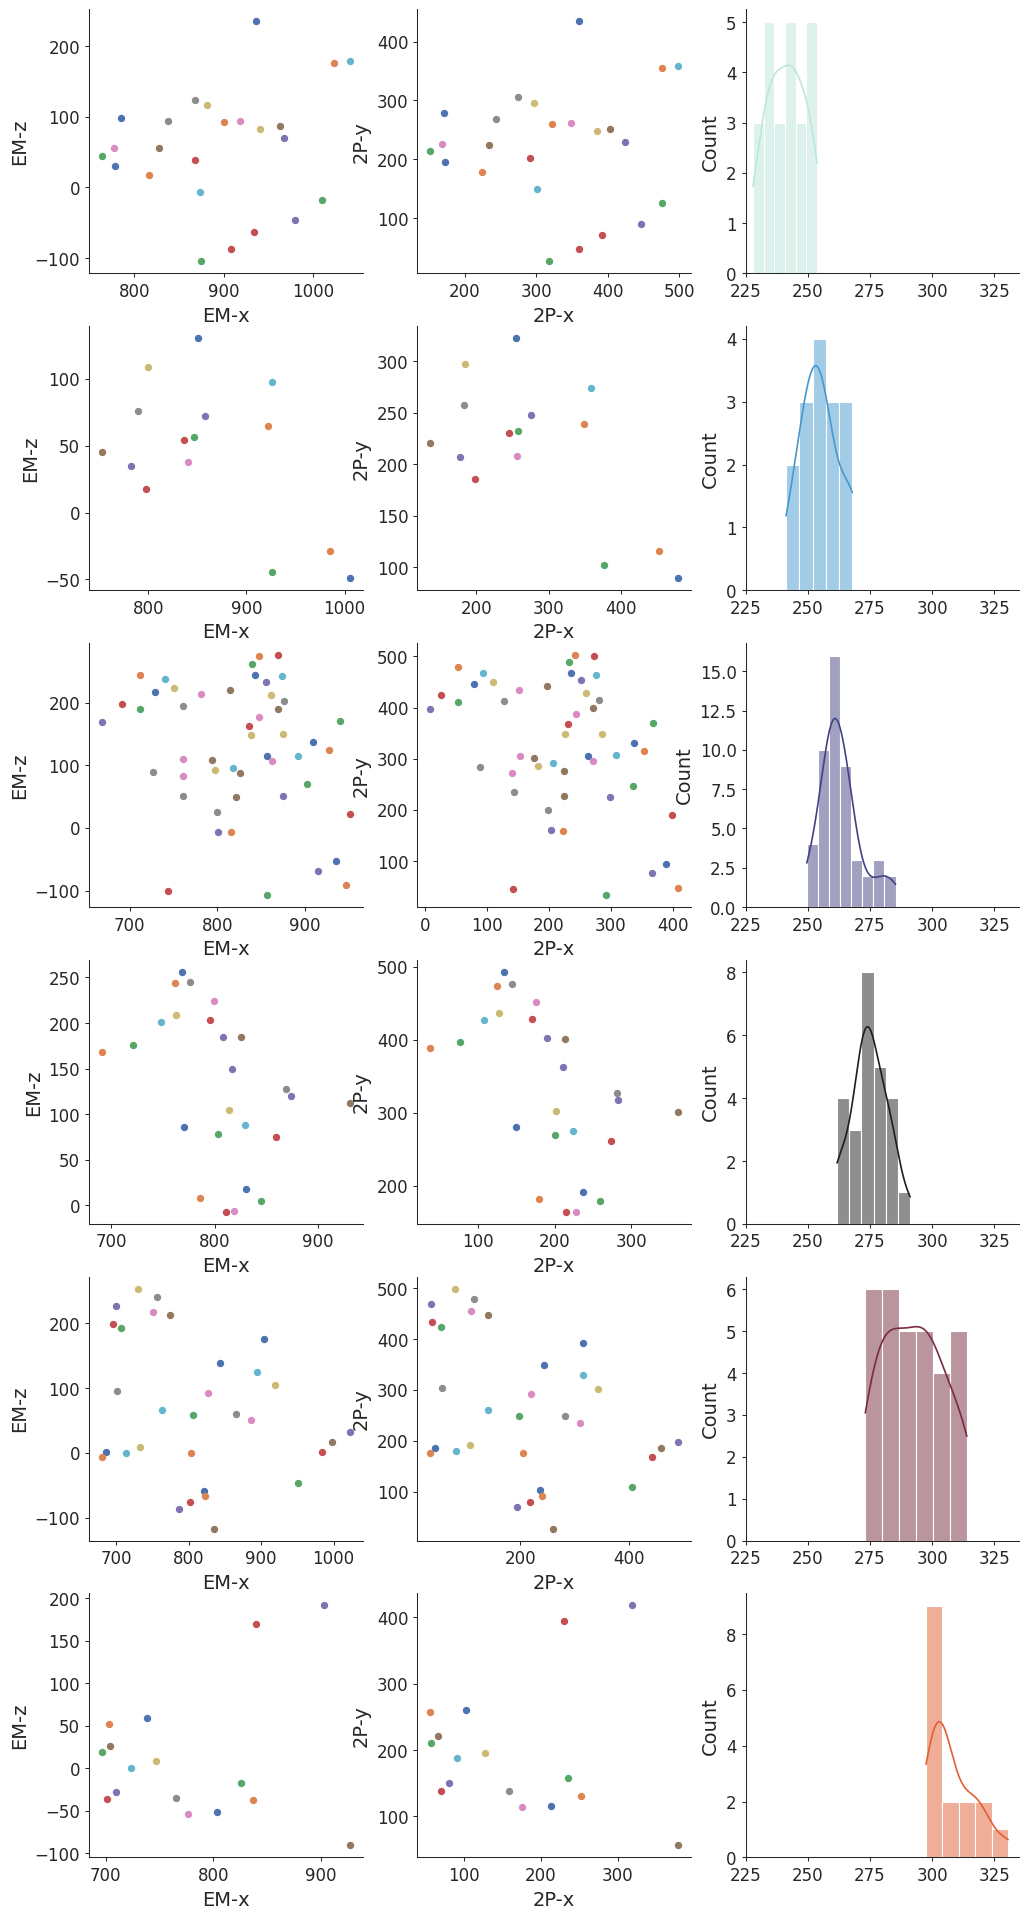

In [7]:
scalar = 1000
cc = sns.color_palette("icefire", as_cmap=True)
##Plot coregistered cells from each plane and the corresponding EM locations
fig, axes = plt.subplots(6,3,figsize=(12,24))

for ii in range(6):
    # #Plot all 2p cells in plane
    # indy = all_2p_cell_centers[:,2] == ii
    # axes[ii,1].scatter(all_2p_cell_centers[indy,0], all_2p_cell_centers[indy,1],marker= '.', color='k',s=35)

    sub_df = coreg_df.loc[coreg_df.ophys_plane == ii+1]
    em_xyz = np.array(sub_df[["pt_position_x","pt_position_y", "pt_position_z"]],dtype=float)
    em_coreg_microns_sub = em_client.transform_position_to_microns(em_xyz)

    em_xz = em_coreg_microns_sub[:,[0,2]] #np.array(sub_df[["pt_position_x", "pt_position_z"]],dtype=float)/scalar
    em_y = em_coreg_microns_sub[:,1]
    
    # em_y = np.array(sub_df["pt_position_y"],dtype=float)/scalar
    ophys_xy = np.array(sub_df[["ophys_x", "ophys_y"]],dtype=float)

    y_width = np.max(em_y)-np.min(em_y)
    print(f'Plane {ii+1}:  min: {np.min(em_y):.1f}, max: {np.max(em_y):.1f},  mean: {np.mean(em_y):.1f}, 95th%tile: {np.percentile(em_y,95):.1f}, std: {np.std(em_y):.1f}')
    for jj in range(ophys_xy.shape[0]):
        color = axes[ii,1].scatter(ophys_xy[jj,0], ophys_xy[jj,1],marker= 'o', s=20).get_facecolors()[0]
        axes[ii,0].scatter(em_xz[jj, 0], em_xz[jj, 1],facecolors=color, marker='o',s=20)

    ax = axes[ii,0]
    ax.set_xlabel(f'EM-x')
    ax.set_ylabel(f'EM-z')

    ax = axes[ii,1]
    ax.set_xlabel(f'2P-x')
    ax.set_ylabel(f'2P-y')
    
    ax = axes[ii,2]
    sns.histplot(em_y,color=cc(ii/6),ax=ax,kde=True)
    # ax.set_xlim([335,445])
    ax.set_xlim([225,335])

    

## Calibrate hash size

In [8]:

transform_list = [
    {
        "name": "PolynomialModel",
        "order": 1,
        "regularization": [0, 0, 0, 0]
    },
    {
        "name": "ChunkedModel",
        "order": 1,
        "nchunks": 3,
        "axis": 0
    },
    {
        "name": "SplineModel",
        "ncntrl": [3, 3, 3],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "ncntrl": [5, 5, 5],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "ncntrl": [10, 10, 10],
         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e8]
    },
    {
        "name": "SplineModel",
        "ncntrl": [10, 10, 10],
         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6] # originally last was 1e8
    },
    {
        "name": "SplineModel",
        "ncntrl": [12, 12, 12],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e9]
    },
    {
        "name": "SplineModel",
        "ncntrl": [12, 12, 12],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e5]  # originally last was 1e9
    },
    {
        "name": "SplineModel",
        "voronoi_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "src_is_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e5]
    },
    {
        "name": "SplineModel",
        "src_is_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 5e4]
    },
        
]

transform_obj = {
        "name": "TransformList",
        "transforms": transform_list
    }

func_coreg_pts = np.array(coreg_df[["optx", "opty", "optz"]],dtype=float)
em_coreg_pts = np.array(coreg_df[["emx", "emy", "emz"]],dtype=float)
ophys_xyz = np.array(coreg_df[["ophys_x", "ophys_y", "ophys_z"]],dtype=float)
# func_coreg_pts = func_coreg_pts[ptset_mask]
# em_coreg_pts = em_coreg_pts[ptset_mask]

nPts = len(func_coreg_pts)
# estimate transformation
tform = coregister.transform.Transform(json=transform_obj)
tform.estimate(func_coreg_pts, em_coreg_pts)
# tform.estimate(func_coreg_pts[ptset_mask], em_coreg_pts[ptset_mask])
nPts


160

In [9]:
metrics_13_new = pd.read_csv('/home/david.wyrick/Git/allen_v1dd/data_frames/v1dd_metrics13_new.csv')
metrics_13_new.rename(columns={"Unnamed: 0": "chase_roi"},inplace=True)
# metrics_13_new = metrics_13_new.set_index("Unnamed: 0")

metrics_13_new = metrics_13_new.set_index('chase_roi')
valid_roi_ids = metrics_13_new.index.values

#Get 2p functional data for column 1 volumn 3
nwb_file = '/allen/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data/nwbs/processed/M409828_13_20181213.nwb'
with ROI_mask_nwb(nwb_file, vol=3, mode="r") as rmn:
    # import pdb; pdb.set_trace()
    all_roi_info = [*rmn.yield_roi_info()] 
    
# Get 2p ROI center of mass in xy plane, disregarding depth for now
all_roi_raw_center_pts = np.array([center_from_pix_mask(roi.pix_mask).tolist() + [roi.plane_z] for roi in all_roi_info])

# Get names
all_roi_names = np.array([roi.name for roi in all_roi_info])
all_roi_chasenames = np.array([roi.chase_ROI for roi in all_roi_info])

#Get pixel areas
all_roi_areas = np.array([len(roi.pix_mask[0]) for roi in all_roi_info])

#Select only valid and non-duplicate cells
indices = get_array_subset_indices(all_roi_chasenames, valid_roi_ids)
func_roi_centers = all_roi_raw_center_pts[indices]
func_roi_names = all_roi_chasenames[indices]
func_roi_areas = all_roi_areas[indices]

In [10]:
# Transform raw 2p coordinates into co-registration space (micron space)
all_roi_func_coreg_pts = transform_pts(func_raw2coreg_tform, func_roi_centers)

#Transform 2p functional locations to EM using transform created using all co-registered cells
all_roi_em_coreg_pts = tform.tform(all_roi_func_coreg_pts)

# Transform coregistered points back into EM space 
all_roi_em_final_pts_voxels = transform_pts(em_coreg2final_tform, all_roi_em_coreg_pts)
all_roi_em_final_pts_nms = all_roi_em_final_pts_voxels * em_final_voxel_size

all_roi_em_final_pts_microns = em_client.transform_position_to_microns(all_roi_em_final_pts_nms)

In [11]:

# Transform raw 2p coordinates into co-registration space (micron space)
ophys_xyz_coreg_pts = transform_pts(func_raw2coreg_tform, ophys_xyz)

#Transform 2p functional locations to EM using transform created using all co-registered cells
ophys_xyz_em_coreg_pts = tform.tform(ophys_xyz_coreg_pts)

# Transform coregistered points back into EM space 
ophys_xyz_em_final_pts_voxels = transform_pts(em_coreg2final_tform, ophys_xyz_em_coreg_pts)
ophys_xyz_em_final_pts_nms = ophys_xyz_em_final_pts_voxels * em_final_voxel_size

ophys_xyz_em_final_pts_microns = em_client.transform_position_to_microns(ophys_xyz_em_final_pts_nms)

Building hashes for co-registered cells in ophys plane 1
Building hashes for co-registered cells in ophys plane 2
Building hashes for co-registered cells in ophys plane 3
Building hashes for co-registered cells in ophys plane 4
Building hashes for co-registered cells in ophys plane 5
Building hashes for co-registered cells in ophys plane 6


Text(0.5, 0, '2p dist (pixels)')

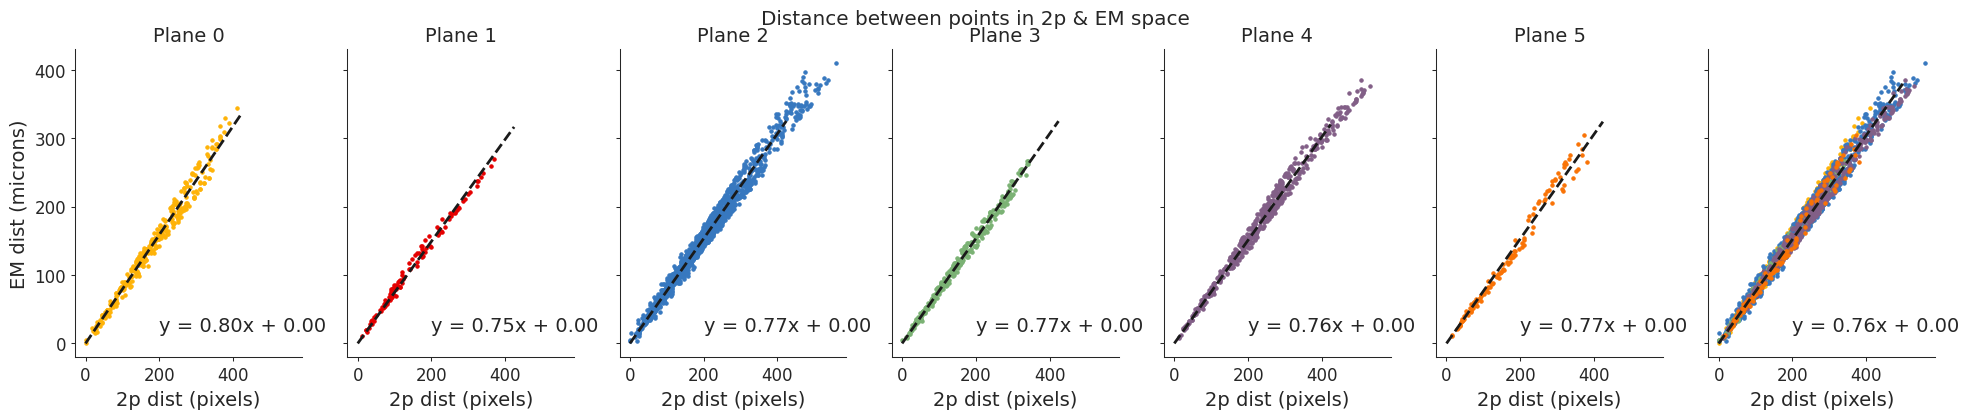

In [44]:
calibration = []

from sklearn.linear_model import LinearRegression

fig, axes = plt.subplots(1,7,figsize=(24,4),sharex=True,sharey=True)
plt.suptitle('Distance between points in 2p & EM space')
#Loop over ophys planes
for iPlane in range(6):
    print(f'Building hashes for co-registered cells in ophys plane {iPlane+1}')
    
    sub_df = coreg_df.loc[coreg_df.ophys_plane == iPlane+1]
    roi_names = np.array(sub_df['chase_key'].values)
    em_ids = np.array(sub_df['em_id'].values,dtype=int)
    em_xyz = np.array(sub_df[["pt_position_x","pt_position_y", "pt_position_z"]],dtype=float)
    em_coreg_microns = em_client.transform_position_to_microns(em_xyz)

    em_xz = em_coreg_microns[:,[0,2]] #np.array(sub_df[["pt_position_x", "pt_position_z"]],dtype=float)/scalar
    em_y = em_coreg_microns[:,1]
    
    # em_y = np.array(sub_df["pt_position_y"],dtype=float)/scalar
    ophys_xy = np.array(sub_df[["ophys_x", "ophys_y"]],dtype=float)    

    dist_list = []
    nCells = len(ophys_xy)
    dist_mat = np.zeros((2,nCells,nCells))
    iX,iY = np.triu_indices(nCells,1)
    #Loop over cells and create hashes with each cell
    for iC in range(nCells):
        for jC in range(iC+1,nCells):
            dist_mat[0,iC,jC] = np.linalg.norm(ophys_xy[iC] - ophys_xy[jC])
            dist_mat[1,iC,jC] = np.linalg.norm(em_xz[iC] - em_xz[jC])
    
    ax = axes[iPlane]; ax.set_title(f'Plane {iPlane}')
    x = dist_mat[0,iX,iY]; y = dist_mat[1,iX,iY]
    ax.scatter(x,y,marker='.',color=color_palette[iPlane])
    ax.set_xlabel('2p dist (pixels)')
    if iPlane == 0: ax.set_ylabel('EM dist (microns)')
    
    reg = LinearRegression(fit_intercept=False).fit(x.reshape(-1, 1), y.reshape(-1, 1))
    a = reg.coef_[0,0]; b = 0
    # a, b = np.polyfit(x, y, 1)
    # pdb.set_trace()
    ax.text(200, 17, f'y = {a:.2f}x + {b:.2f}', size=14)
    x = np.arange(0,425,1)
    ax.plot(x, a*x+b, color='k', linestyle='--', linewidth=2)
    
    calibration.append(np.array(((dist_mat[0,iX,iY],dist_mat[1,iX,iY]))))
    
    axes[-1].scatter(dist_mat[0,iX,iY],dist_mat[1,iX,iY],marker='.',color=color_palette[iPlane])
    # for roi_2p, roi_em in zip(ophys_xy,em_xz):


tmp = np.hstack(calibration).T

x = tmp2[:,0]; y = tmp2[:,1]
ax = axes[-1]

reg = LinearRegression(fit_intercept=False).fit(x.reshape(-1, 1), y.reshape(-1, 1))
a = reg.coef_[0,0]; b = 0

# a, b = np.polyfit(x, y, 1)

ax.text(200, 17, f'y = {a:.2f}x + {b:.2f}', size=14)
x = np.arange(0,500,1)
ax.plot(x, a*x+b, color='k', linestyle='--', linewidth=2)

ax.set_xlabel('2p dist (pixels)')
# ax.set_ylabel('EM dist (microns)')

In [12]:
pix_size = 0.77

#How many cells are within a 30x30 pixel grid?
grid_size = 102; grid_micron = grid_size*pix_size
grid_micron

78.54

In [13]:
min_um = np.min(em_coreg_microns,axis=0)
max_um = np.max(em_coreg_microns,axis=0)
min_um, max_um

(array([ 667.85394519,  227.97907876, -116.99234462]),
 array([1041.51001697,  330.60583465,  276.06896973]))

In [10]:
plane0 = 349
em_y_guesses = [plane0 + 15*i for i in range(6)]


In [11]:
buffer_um = 75
buffer = np.array((buffer_um, buffer_um, buffer_um))

min_um = np.min(em_coreg_microns,axis=0)
max_um = np.max(em_coreg_microns,axis=0)

iPlane = 0; width = 22
#Create boundin box
min_um2 = min_um.copy(); 
min_um2 = min_um2 - buffer
min_um2[1] = (em_y_guesses[iPlane] - width)

max_um2 = max_um.copy()
max_um2 = max_um2 + buffer
max_um2[1] = (em_y_guesses[iPlane] + width)
min_um2, max_um2

(array([-317.44860756,  327.        , -603.53613362]),
 array([206.20746422, 371.        , -60.47481927]))

In [14]:
pix_size = 0.77
pdfdoc = PdfPages(os.path.join(PlotDir,'whatareweworkingwith.pdf'))

#How many rois are within 50 micron grid 
grid_size_2p = 65; grid_micron = grid_size_2p*pix_size
grid_boundaries_2p = np.arange(0,512,grid_size_2p); 

# 50 um buffer around area
buffer_um = 50
buffer = np.array((buffer_um, buffer_um, buffer_um))
# plane0 = 353
# em_y_guesses = [plane0 + 13*i for i in range(6)]

plane0 = 349
em_y_guesses = [plane0 + 15*i for i in range(6)]

plane0 = 238
em_y_guesses = [plane0 + 15*i for i in range(6)]

min_um = np.min(em_coreg_microns,axis=0)
max_um = np.max(em_coreg_microns,axis=0)

width = 20
# plt.suptitle(f'{grid_size}x{grid_size} pixel grids ->  {grid_micron:.1f}x{grid_micron:.1f} microns')
plt.suptitle(f'2-photon rois')

distances_per_plane = []
#Loop over ophys planes
for iPlane in range(6):
    # fig, axes = plt.subplots(2,2,figsize=(12,12))
    fig, axes = plt.subplots(1,2,figsize=(12,6))
    plt.suptitle(f'Ophys plane {iPlane + 1}',y=0.95)

    #Create boundin box
    min_um2 = min_um.copy(); 
    min_um2 = min_um2 - buffer
    min_um2[1] = (em_y_guesses[iPlane] - width)

    max_um2 = max_um.copy()
    max_um2 = max_um2 + buffer
    max_um2[1] = (em_y_guesses[iPlane] + width)

    #Within same box, how many em cells
    grid_size_em = 50
    grid_boundaries_em = [np.arange(min_um2[0],max_um2[0],grid_size_em),np.arange(min_um2[2],max_um2[2],grid_size_em)]
    
    #Create arrays
    nGrids_2p = len(grid_boundaries_2p)
    nCells_per_grid_2p = np.zeros((nGrids_2p,nGrids_2p))
    nCells_per_grid_em = np.zeros([len(g) for g in grid_boundaries_em])

    #Get 2p cells in this plane
    indy = np.where(func_roi_centers[:,2] == iPlane)[0]
    func_roi_xy_in_plane = func_roi_centers[indy,:2]
    roi_names_in_plane = func_roi_names[indy]
    
    #Get all cells in EM volume within bounding region
    indy = np.all(nucleus_points_microns > min_um2,axis=1) & np.all(nucleus_points_microns < max_um2,axis=1)
    nucleus_points_sub = nucleus_points_microns[indy]
    em_xz = nucleus_points_sub[:,[0,2]]
    em_y = nucleus_points_sub[:,1]
    nucleus_ids_sub = nucleus_ids[indy]
    
    #Find number of 2p cells per grid
    for iX, x_bound in enumerate(grid_boundaries_2p):
        for iY, y_bound in enumerate(grid_boundaries_2p):
            #Get grid boundaries and center
            grid_xy_min = np.array([x_bound,y_bound])
            grid_xy_max = grid_xy_min + grid_size_2p
            grid_xy_ctr = grid_xy_min + grid_size_2p/2
            
            #How many are within the grid volume?
            nPts = np.sum((np.all(func_roi_xy_in_plane >= grid_xy_min,axis=1)) & (np.all(func_roi_xy_in_plane < grid_xy_max,axis=1)))
            nCells_per_grid_2p[iX,iY] = nPts

        
    #Do the same for em data
    for iX, x_bound in enumerate(grid_boundaries_em[0]):
        for iZ, z_bound in enumerate(grid_boundaries_em[1]):
            
            #Get grid boundaries and center
            grid_xz_min = np.array([x_bound,z_bound])
            grid_xz_max = grid_xz_min + grid_size_em
            grid_xz_ctr = grid_xz_min + grid_size_em/2
           
            #How many are within the grid volume?
            nPts = np.sum((np.all(em_xz >= grid_xz_min,axis=1)) & (np.all(em_xz < grid_xz_max,axis=1)))
            nCells_per_grid_em[iX,iZ] = nPts

    ax = axes[0]; ax.set_title('Ophys rois')
    ax.scatter(func_roi_xy_in_plane[:,0],func_roi_xy_in_plane[:,1],color='k',marker='x',s=20)
    # ax.axis('off')

    # ax.hlines(np.median(em_y),650,1100,color='k',ls='-',zorder=0)
    ax.hlines(grid_boundaries_2p,0,512,color='k',ls='-',zorder=0,alpha=0.05)
    ax.vlines(grid_boundaries_2p,0,512,color='k',ls='-',zorder=0,alpha=0.05)
    ax.set_xlabel('Ophys-x')
    ax.set_ylabel('Ophys-y')

    # ax = axes[1,0]
    # sns.histplot(nCells_per_grid_2p.ravel(),color=cc(iPlane/6),ax=ax)
    # ax.set_xlabel('# of cells per ophys grid grid')

    ax = axes[1]; ax.set_title(f'{len(em_xz)} nuclei points')
    ax.scatter(em_xz[:,0],em_xz[:,1],color='b',marker='.',s=20) #c=em_y,cmap='viridis'
    # ax.axis('off')
    # ax.hlines(np.median(em_y),650,1100,color='k',ls='-',zorder=0)
    ax.hlines(grid_boundaries_em[1],min_um2[0],max_um2[0],color='k',ls='-',zorder=0,alpha=0.15)
    ax.vlines(grid_boundaries_em[0],min_um2[2],max_um2[2],color='k',ls='-',zorder=0,alpha=0.15)
    ax.set_xlabel('EM-x')
    ax.set_ylabel('EM-z')

    # ax = axes[1,1]
    # sns.histplot(nCells_per_grid_em.ravel(),color=cc(iPlane/6),ax=ax)
    # ax.set_xlabel('# of cells per EM grid')

    sub_df = coreg_df.loc[coreg_df.ophys_plane == iPlane+1]
    em_xyz = np.array(sub_df[["pt_position_x","pt_position_y", "pt_position_z"]],dtype=float)
    em_xyz_microns = em_client.transform_position_to_microns(em_xyz)

    em_xz = em_xyz_microns[:,[0,2]] #np.array(sub_df[["pt_position_x", "pt_position_z"]],dtype=float)/scalar
    em_y = em_xyz_microns[:,1]
    
    # em_y = np.array(sub_df["pt_position_y"],dtype=float)/scalar
    ophys_xy = np.array(sub_df[["ophys_x", "ophys_y"]],dtype=float)

    y_width = np.max(em_y)-np.min(em_y)
    # print(f'Plane {ii+1}:  min: {np.min(em_y):.1f}, max: {np.max(em_y):.1f},  mean: {np.mean(em_y):.1f}, 95th%tile: {np.percentile(em_y,95):.1f}, std: {np.std(em_y):.1f}')
    for jj in range(ophys_xy.shape[0]):
        color = axes[0].scatter(ophys_xy[jj,0], ophys_xy[jj,1],marker= '*', s=35).get_facecolors()[0]
        axes[1].scatter(em_xz[jj, 0], em_xz[jj, 1],facecolors=color, marker='*',s=35)

        # axes[0,0].scatter(ophys_xy[jj,0], ophys_xy[jj,1],marker= 'o',edgecolors='r',facecolors="none", s=35)
        # axes[0,1].scatter(em_xz[jj, 0], em_xz[jj, 1],edgecolors='r',facecolors="none", marker='o',s=35)

    pdfdoc.savefig(fig)
    plt.close(fig)
pdfdoc.close()


            

<Figure size 640x480 with 0 Axes>

In [34]:
pix_size = 0.77
pdfdoc = PdfPages(os.path.join(PlotDir,'whatareweworkingwith_zoom.pdf'))

#How many rois are within 50 micron grid 
grid_size_2p = 65; grid_micron = grid_size_2p*pix_size
grid_boundaries_2p = np.arange(0,512,grid_size_2p); 

# 50 um buffer around area
buffer_um = 50
buffer = np.array((buffer_um, buffer_um, buffer_um))
# plane0 = 353
# em_y_guesses = [plane0 + 13*i for i in range(6)]
plane0 = 349
em_y_guesses = [plane0 + 15*i for i in range(6)]

min_um = np.min(em_coreg_microns,axis=0)
max_um = np.max(em_coreg_microns,axis=0)

width = 22
# plt.suptitle(f'{grid_size}x{grid_size} pixel grids ->  {grid_micron:.1f}x{grid_micron:.1f} microns')
plt.suptitle(f'2-photon rois')

distances_per_plane = []
#Loop over ophys planes
for iPlane in range(6):

    #Create boundin box
    min_um2 = min_um.copy(); 
    min_um2 = min_um2 - buffer
    min_um2[1] = (em_y_guesses[iPlane] - width)

    max_um2 = max_um.copy()
    max_um2 = max_um2 + buffer
    max_um2[1] = (em_y_guesses[iPlane] + width)

    #Get 2p cells in this plane
    indy = np.where(func_roi_centers[:,2] == iPlane)[0]
    func_roi_xy_in_plane = func_roi_centers[indy,:2]

    #Get all cells in EM volume within bounding region
    indy = np.all(nucleus_points_microns > min_um2,axis=1) & np.all(nucleus_points_microns < max_um2,axis=1)
    nucleus_points_sub = nucleus_points_microns[indy]
    em_xz = nucleus_points_sub[:,[0,2]]

    #Coregistered cells
    sub_df = coreg_df.loc[coreg_df.ophys_plane == iPlane+1]
    coreg_em_microns = em_client.transform_position_to_microns(np.array(sub_df[["pt_position_x","pt_position_y", "pt_position_z"]],dtype=float))
    coreg_em_xz = coreg_em_microns[:,[0,2]] 
    coreg_2p_xy = np.array(sub_df[["ophys_x", "ophys_y"]],dtype=float)

    for jj in range(coreg_2p_xy.shape[0]):
        idx = sub_df.index.values[jj]
        fig, axes = plt.subplots(1,2,figsize=(12,6))
        plt.suptitle(f'Ophys plane {iPlane + 1}',y=0.95)

        for kk in range(coreg_2p_xy.shape[0]):
            color = axes[0].scatter(coreg_2p_xy[kk,0], coreg_2p_xy[kk,1],marker= '*', s=35).get_facecolors()[0]
            axes[1].scatter(coreg_em_xz[kk, 0], coreg_em_xz[kk, 1],facecolors=color, marker='*',s=35)
            
        ax = axes[0]; ax.set_title(sub_df.at[idx,'chase_key'])
        ax.scatter(func_roi_xy_in_plane[:,0],func_roi_xy_in_plane[:,1],color='k',marker='x',s=20)

        ax = axes[1]; ax.set_title(sub_df.at[idx,'em_id'])
        ax.scatter(em_xz[:,0],em_xz[:,1],color='k',marker='.',s=10) #c=em_y,cmap='viridis'

        # axes[0].scatter(coreg_2p_xy[jj,0], coreg_2p_xy[jj,1],marker= 'o',edgecolors='r',facecolors="none", s=35)
        # axes[1].scatter(coreg_em_xz[jj, 0], coreg_em_xz[jj, 1],edgecolors='r',facecolors="none", marker='o',s=35)

        axes[0].set_xlim([coreg_2p_xy[jj,0]-39,coreg_2p_xy[jj,0]+39])
        axes[0].set_ylim([coreg_2p_xy[jj,1]-39,coreg_2p_xy[jj,1]+39])

        axes[1].set_xlim([coreg_em_xz[jj,0]-30,coreg_em_xz[jj,0]+30])
        axes[1].set_ylim([coreg_em_xz[jj,1]-30,coreg_em_xz[jj,1]+30])

        # plt.show()
        # pdb.set_trace()
        pdfdoc.savefig(fig)
        plt.close(fig)
pdfdoc.close()


            

<Figure size 640x480 with 0 Axes>

In [ ]:
pix_size = 0.77
pdfdoc = PdfPages(os.path.join(PlotDir,'whatareweworkingwith_zoom3.pdf'))

#How many rois are within 50 micron grid 
grid_size_2p = 65; grid_micron = grid_size_2p*pix_size
grid_boundaries_2p = np.arange(0,512,grid_size_2p); 

# 50 um buffer around area
buffer_um = 50
buffer = np.array((buffer_um, buffer_um, buffer_um))
# plane0 = 353
# em_y_guesses = [plane0 + 13*i for i in range(6)]
plane0 = 349
em_y_guesses = [plane0 + 15*i for i in range(6)]

min_um = np.min(em_coreg_microns,axis=0)
max_um = np.max(em_coreg_microns,axis=0)

width = 22
# plt.suptitle(f'{grid_size}x{grid_size} pixel grids ->  {grid_micron:.1f}x{grid_micron:.1f} microns')
plt.suptitle(f'2-photon rois')

distances_per_plane = []
#Loop over ophys planes
for iPlane in range(6):

    #Create boundin box
    min_um2 = min_um.copy(); 
    min_um2 = min_um2 - buffer
    min_um2[1] = (em_y_guesses[iPlane] - width)

    max_um2 = max_um.copy()
    max_um2 = max_um2 + buffer
    max_um2[1] = (em_y_guesses[iPlane] + width)

    #Get 2p cells in this plane
    indy = np.where(func_roi_centers[:,2] == iPlane)[0]
    func_roi_xy_in_plane = func_roi_centers[indy,:2]
    all_roi_em_final_pts_microns_in_plane = all_roi_em_final_pts_microns[indy]
    
    #Get all cells in EM volume within bounding region
    indy = np.all(nucleus_points_microns > min_um2,axis=1) & np.all(nucleus_points_microns < max_um2,axis=1)
    nucleus_points_sub = nucleus_points_microns[indy]
    em_xz = nucleus_points_sub[:,[0,2]]

    #Coregistered cells
    sub_df = coreg_df.loc[coreg_df.ophys_plane == iPlane+1]
    coreg_em_microns = em_client.transform_position_to_microns(np.array(sub_df[["pt_position_x","pt_position_y", "pt_position_z"]],dtype=float))
    coreg_em_xz = coreg_em_microns[:,[0,2]] 
    coreg_2p_xy = np.array(sub_df[["ophys_x", "ophys_y"]],dtype=float)

    indy = np.where(ophys_xyz[:,2] == iPlane)[0]
    tmp = ophys_xyz_em_final_pts_microns[indy]
    
    for jj in range(tmp.shape[0]):
        idx = sub_df.index.values[jj]

        fig, ax = plt.subplots(figsize=(12,12))
        plt.suptitle(f'Ophys plane {iPlane + 1}',y=0.95)
        
        for kk in range(tmp.shape[0]):
            color = ax.scatter(tmp[kk,0], tmp[kk,2],marker= 'o', s=35).get_facecolors()[0]
            ax.scatter(coreg_em_xz[kk, 0], coreg_em_xz[kk, 1],facecolors="none", edgecolors=color, marker='o',s=35)

        ax.scatter(all_roi_em_final_pts_microns_in_plane[:,0],all_roi_em_final_pts_microns_in_plane[:,2],color='k',marker='x',s=20)
        ax.scatter(em_xz[:,0],em_xz[:,1],color='b',marker='.',s=10) #c=em_y,cmap='viridis'
        
        ax.set_xlim([tmp[jj,0]-30,tmp[jj,0]+30])
        ax.set_ylim([tmp[jj,2]-30,tmp[jj,2]+30])

        # plt.show()
        # pdb.set_trace()
        pdfdoc.savefig(fig)
        plt.close(fig)
pdfdoc.close()


            

## Create hashes from coregistered cells

Building hashes for co-registered cells in ophys plane 1
Building hashes for co-registered cells in ophys plane 2
Building hashes for co-registered cells in ophys plane 3
Building hashes for co-registered cells in ophys plane 4
Building hashes for co-registered cells in ophys plane 5
Building hashes for co-registered cells in ophys plane 6


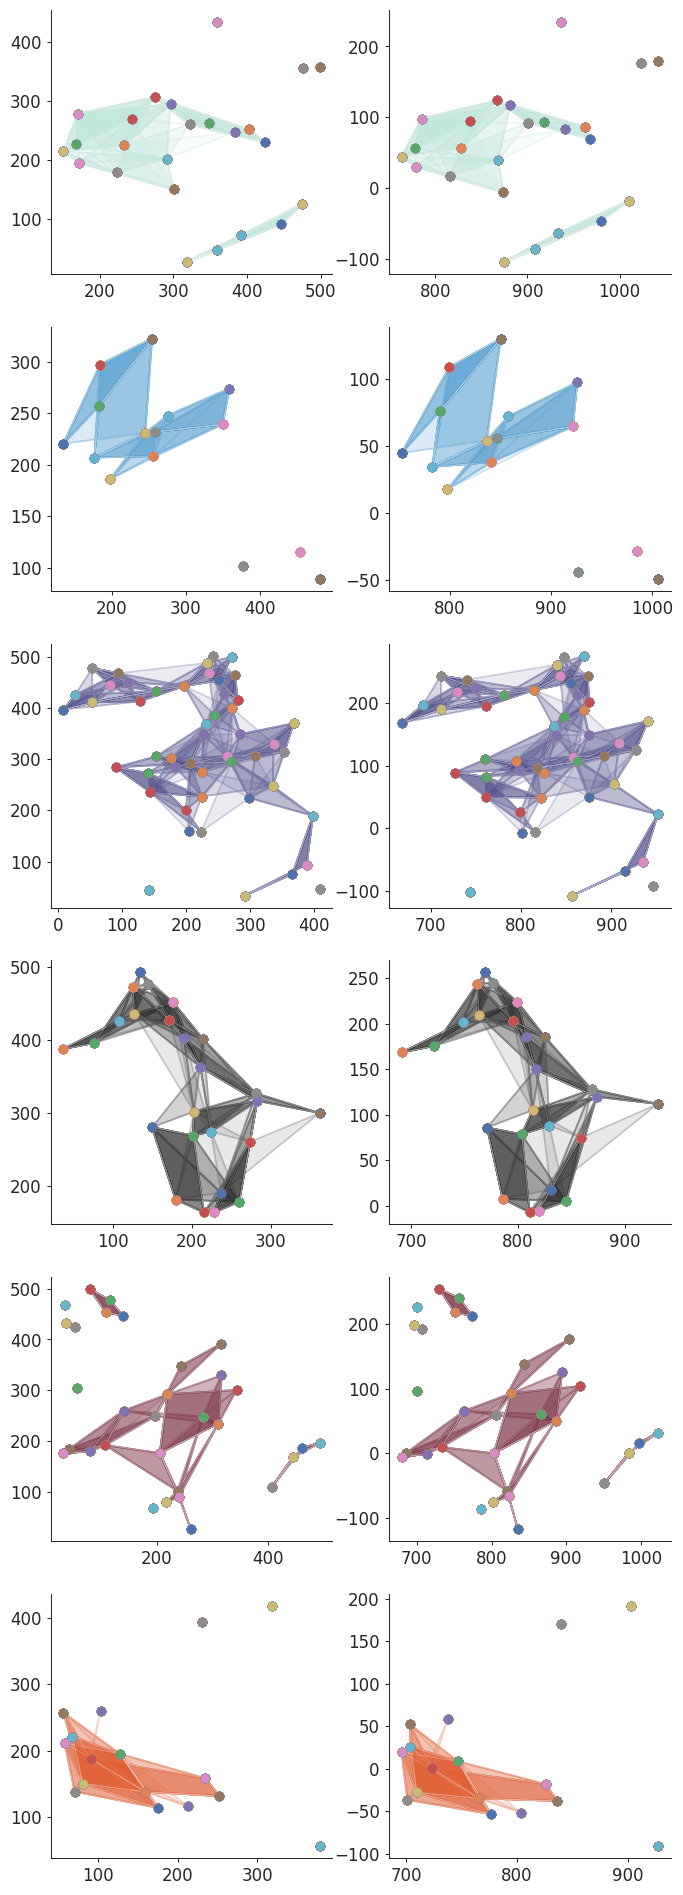

In [22]:
failed = 0; failed2 = 0
pix_size = 0.77; grid_size_em = 50

AC_min = 10
AD_min = 15
BC_min = 20
BD_min = 15

plane0 = 349
em_y_guesses = [plane0 + 15*i for i in range(6)]

fig, axes = plt.subplots(6,2,figsize=(8,24))

hash_dict_coreg = {}
#Loop over ophys planes
for iPlane in range(6):
    print(f'Building hashes for co-registered cells in ophys plane {iPlane+1}')
    
    #Coregistered cells
    sub_df = coreg_df.loc[coreg_df.ophys_plane == iPlane+1]
    coreg_em_microns = em_client.transform_position_to_microns(np.array(sub_df[["pt_position_x","pt_position_y", "pt_position_z"]],dtype=float))
    # coreg_em_microns = coreg_em_microns - em_origin
    coreg_em_xz = coreg_em_microns[:,[0,2]]; coreg_em_y = coreg_em_microns[:,1]
    coreg_2p_xy = np.array(sub_df[["ophys_x", "ophys_y"]],dtype=float)

    roi_names = np.array(sub_df['chase_key'].values)
    em_ids = np.array(sub_df['em_id'].values,dtype=int)

    #Create KDTree for easy searching
    kdt_2p = KDTree(coreg_2p_xy)
    kdt_em = KDTree(coreg_em_xz)
    
    # pdb.set_trace()
    hash_list = []; quad_list = []
    #Loop over cells and create hashes with each cell
    for roi_2p, roi_em in zip(coreg_2p_xy,coreg_em_xz):
        
        #Look at the 20 closest cells in the plane and create quads out of them
        distances, indices = kdt_2p.query(roi_2p, k=10)
        
        hash_building = True; iter = 0; hashes_built = 0
        #Sub-select 4 cells to create 3 different hashes
        while hash_building:
            indy3 = np.random.choice(indices[1:],3,replace=False)
            indy4 = np.concatenate(([indices[0]],indy3))
            
            #Get quad xy
            quad_2p = coreg_2p_xy[indy4]
                
            #Calculate hash from 4 points
            hash_2p, i_abcd, error = calculate_hash(quad_2p)
            
            iter += 1
            #Check to quad was successfully created
            if (error == 1):
                failed += 1
                if iter > 1000:
                    hash_building = False
                continue
            
            #Calculate hash from 4 em points
            quad_em = coreg_em_xz[indy4]
            hash_em, i_abcd_em, error = calculate_hash(quad_em)
            
            #Check to quad was successfully created
            if (error == 1):
                failed2 += 1
                if iter > 1000:
                    hash_building = False
                continue
            
            if ~np.all(i_abcd_em == i_abcd):
                continue

            quad_indy = indy4[i_abcd]
            quad_2p = coreg_2p_xy[quad_indy]
            quad_em = coreg_em_xz[quad_indy]

            AB = np.linalg.norm(quad_2p[0]-quad_2p[1])*pix_size
            AC = np.linalg.norm(quad_2p[0]-quad_2p[2])*pix_size
            AD = np.linalg.norm(quad_2p[0]-quad_2p[3])*pix_size
            BC = np.linalg.norm(quad_2p[1]-quad_2p[2])*pix_size
            BD = np.linalg.norm(quad_2p[1]-quad_2p[3])*pix_size

            if (AB < grid_size_em) | (AB > 3*grid_size_em):
                continue
            
            # if (AC < AC_min) | (AD < AD_min) | (BC < BC_min) | (BD < BD_min):
            #     continue

            #Check if hash has already been created
            for q in quad_list:
                if np.all(q-quad_2p == 0):
                    continue
            quad_list.append(quad_2p)
            AB_em = np.linalg.norm(quad_em[0]-quad_em[1])
            
            #Save quad
            hash_list.append({'rois_2p': roi_names[quad_indy],
                            'nucleus_ids': em_ids[quad_indy], 
                            'ophys_xy': quad_2p,
                            'em_xz': quad_em,
                            'plane': iPlane,
                            'em_y': coreg_em_y[quad_indy],
                            'hash_2p': hash_2p,
                            'hash_em': hash_em,
                            'AB_2p': AB,
                            'AB_em': AB_em,
                            'center_2p': np.mean(quad_2p,axis=0),
                            'center_em': np.mean(quad_em,axis=0)
                            })

            #update counter
            hashes_built += 1

            #Plot quads
            i_a = 0; i_b = 1; i_c = 2; i_d = 3
            ax = axes[iPlane,0]
            ax.plot(quad_2p[np.array([i_a,i_d,i_b,i_c,i_a]),0],quad_2p[np.array([i_a,i_d,i_b,i_c,i_a]),1],color=cc(iPlane/6),alpha=0.25,zorder=0)
            poly = Polygon(quad_2p[np.array([i_a,i_d,i_b,i_c])], facecolor=cc(iPlane/6), alpha=0.1)
            ax.add_patch(poly)
            
            ax = axes[iPlane,1]
            ax.plot(quad_em[np.array([i_a,i_d,i_b,i_c,i_a]),0],quad_em[np.array([i_a,i_d,i_b,i_c,i_a]),1],color=cc(iPlane/6),alpha=0.25,zorder=0)
            poly = Polygon(quad_em[np.array([i_a,i_d,i_b,i_c])], facecolor=cc(iPlane/6), alpha=0.1)
            ax.add_patch(poly)

            for jj in range(coreg_2p_xy.shape[0]):
                color = axes[iPlane,0].scatter(coreg_2p_xy[jj,0], coreg_2p_xy[jj,1],marker= 'o', s=35).get_facecolors()[0]
                axes[iPlane,1].scatter(coreg_em_xz[jj, 0], coreg_em_xz[jj, 1],facecolors=color, marker='o',s=35)
        
            if hashes_built == 5:
                hash_building = False
                
    #Save hashes for this plane
    hash_dict_coreg[iPlane] = hash_list           
    

In [24]:
hash_list = []
for iP in range(6):
    hash_list.extend(hash_dict_coreg[iP])

#Get coreg hashes 
hashes_coreg_em = np.array([t['hash_em'] for t in hash_list])
hashes_coreg_2p = np.array([t['hash_2p'] for t in hash_list])
quad_coreg_em = np.array([t['em_xz'] for t in hash_list])
quad_coreg_2p = np.array([t['ophys_xy'] for t in hash_list])
coreg_hash_distances = np.array([np.linalg.norm(h_2p-h_em) for h_2p,h_em in zip(hashes_coreg_2p,hashes_coreg_em)])

In [22]:
len(coreg_hash_distances)

636

<Axes: ylabel='Count'>

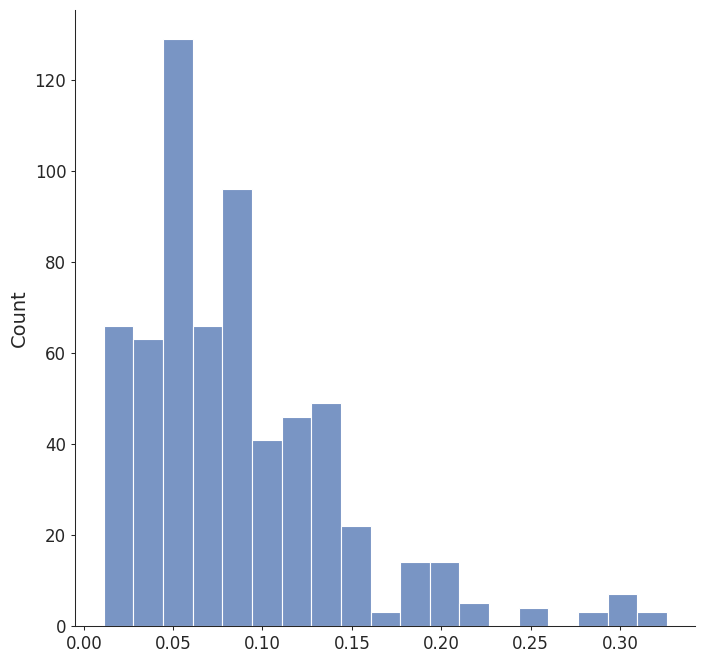

In [25]:
# coreg_hash_distances

fig, ax = plt.subplots(figsize=(8,8))
# ax.set_title(f'{np.sum(coreg_hash_distances > 2)} out of {len(coreg_hash_distances)} coregistered hashes > 10')
sns.histplot(coreg_hash_distances,ax=ax)
# ax.set_xlim([0,2])

In [29]:
min_um = np.min(nucleus_points_microns,axis=0)
max_um = np.max(nucleus_points_microns,axis=0)
min_um, max_um

(array([ 114.57141072,  -60.69654917, -307.20025631]),
 array([1755.04883375,  838.98238354,  707.94085579]))

In [19]:
em_coreg_microns.shape

(161, 3)

In [31]:


buffer_um = 50
buffer = np.array((buffer_um, buffer_um, buffer_um))
min_um, max_um

(array([ 114.57141072,  -60.69654917, -307.20025631]),
 array([1755.04883375,  838.98238354,  707.94085579]))

In [32]:
# pdfdoc = PdfPages(os.path.join(PlotDir,'coreg_hashes.pdf'))
pdfdoc = PdfPages(os.path.join(PlotDir,'coreg_hashes_zoom7.pdf'))
zoom = True
hash_dist_list = []

width = 22
#Loop over ophys planes
for iPlane in range(6):

    #Create boundin box
    min_um2 = min_um.copy(); 
    min_um2 = min_um2 - buffer
    min_um2[1] = (em_y_guesses[iPlane] - width)

    max_um2 = max_um.copy()
    max_um2 = max_um2 + buffer
    max_um2[1] = (em_y_guesses[iPlane] + width)

    #Get 2p cells in this plane
    indy = np.where(func_roi_centers[:,2] == iPlane)[0]
    func_roi_xy_in_plane = func_roi_centers[indy,:2]

    #Get all cells in EM volume within bounding region
    indy = np.all(nucleus_points_microns > min_um2,axis=1) & np.all(nucleus_points_microns < max_um2,axis=1)
    nucleus_points_sub = nucleus_points_microns[indy]
    em_xz = nucleus_points_sub[:,[0,2]]

    #Coregistered cells
    sub_df = coreg_df.loc[coreg_df.ophys_plane == iPlane+1]
    coreg_em_microns = em_client.transform_position_to_microns(np.array(sub_df[["pt_position_x","pt_position_y", "pt_position_z"]],dtype=float))
    # coreg_em_microns = coreg_em_microns - em_origin

    coreg_em_xz = coreg_em_microns[:,[0,2]]; coreg_em_y = coreg_em_microns[:,1]
    coreg_2p_xy = np.array(sub_df[["ophys_x", "ophys_y"]],dtype=float)

    roi_names = np.array(sub_df['chase_key'].values)
    em_ids = np.array(sub_df['em_id'].values,dtype=int)

    # #Create KDTree for easy searching
    # kdt_2p = KDTree(ophys_xy)
    # kdt_em = KDTree(em_xz)

    hash_list = hash_dict_coreg[iPlane]
    
    ## Let's try to search for hashes 
    hashes_2p = np.array([t['hash_2p'] for t in hash_list])
    hashes_em = np.array([t['hash_em'] for t in hash_list])
    i_a = 0; i_b = 1; i_c = 2; i_d = 3
    
    #Loop over hashes and plot
    for iH, (h_2p, h_em) in enumerate(zip(hashes_2p,hashes_em)):
    
        quad_2p = np.vstack((np.array([[0,0],[1,1]]),h_2p.reshape(2,2)))
        quad_em = np.vstack((np.array([[0,0],[1,1]]),h_em.reshape(2,2)))

        # fig, axes = plt.subplots(1,2,figsize=(16,8))
        fig, axes = plt.subplots(1,3,figsize=(24,8))
        plt.suptitle(f'Plane {iPlane}, hash {iH}')

        ax = axes[0]; ax.set_title(f'2p plane {iPlane + 1}')
        ax.scatter(func_roi_xy_in_plane[:,0],func_roi_xy_in_plane[:,1],color='k',marker='x',s=20,alpha=.5)

        ax = axes[1]; ax.set_title('Potential EM matches')
        ax.scatter(em_xz[:,0],em_xz[:,1],color='k',marker='.',s=10,alpha=.5) #c=em_y,cmap='viridis'

        for jj in range(coreg_2p_xy.shape[0]):
            if np.any(np.all(coreg_em_xz[jj] == hash_list[iH]['ophys_xy'],axis=1)):
                continue
            color = axes[0].scatter(coreg_2p_xy[jj,0], coreg_2p_xy[jj,1],marker= 'o', s=35).get_facecolors()[0]
            axes[1].scatter(coreg_em_xz[jj, 0], coreg_em_xz[jj, 1],facecolors=color, marker='o',s=35)
            
        ax=axes[0]; ax.set_title('In 2p pixel space')
        ax=axes[1]; ax.set_title('In EM micron space')
        plot_quad(hash_list[iH]['ophys_xy'],ax=axes[0],polygon_c=color_palette[0])
        plot_quad(hash_list[iH]['em_xz'],ax=axes[1],polygon_c=color_palette[1])
        
        plot_quad(quad_2p,ax=axes[2],polygon_c=color_palette[0],label='2p hash')
        plot_quad(quad_em,ax=axes[2],polygon_c=color_palette[1],label='EM hash')
        
        hash_dist = np.linalg.norm(h_2p - h_em)
        axes[2].legend(); axes[2].set_title(f'Hash based on coordinates defined by A-B\n Hash EUC dist: {hash_dist:.2f}')
        hash_dist_list.append(hash_dist)

        center_2p = np.mean(hash_list[iH]['ophys_xy'],axis=0)
        center_em = np.mean(hash_list[iH]['em_xz'],axis=0)
        if zoom:
            axes[0].set_xlim([center_2p[0]-65,center_2p[0]+65])
            axes[0].set_ylim([center_2p[1]-65,center_2p[1]+65])

            axes[1].set_xlim([center_em[0]-50,center_em[0]+50])
            axes[1].set_ylim([center_em[1]-50,center_em[1]+50])

        # plt.show()
        # pdb.set_trace()

        pdfdoc.savefig(fig)
        plt.close(fig)
    # kdt_em = KDTree(hash_em)
    
    # distances, indices =  kdt_em.query(hash_2p[0],k=10)
    # pdb.set_trace()
pdfdoc.close()

In [15]:


hash_list = hash_dict_coreg[2]
#Get coreg hashes 
hashes_coreg_em = np.array([t['hash_em'] for t in hash_list])
hashes_coreg_2p = np.array([t['hash_2p'] for t in hash_list])
quad_coreg_em = np.array([t['em_xz'] for t in hash_list])
quad_coreg_2p = np.array([t['ophys_xy'] for t in hash_list])
coreg_hash_distances = np.array([np.linalg.norm(h_2p-h_em) for h_2p,h_em in zip(hashes_coreg_2p,hashes_coreg_em)])
indy = np.where(coreg_hash_distances > 0.1)[0]
indy

array([  0,   1,   2,   3,   4,   5,   6,   9,  10,  11,  12,  13,  14,
        15,  18,  19,  26,  27,  29,  30,  40,  41,  43,  45,  47,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  65,  66,  67,  68,
        72,  74,  75,  77,  78,  80,  81,  83,  85,  86,  87,  88,  89,
        93, 150, 152, 159, 160, 161, 162, 163, 164, 166, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 192, 193, 194, 198, 202, 206, 207,
       208, 209])

In [20]:
iH = indy[10]
tmp_dict = hash_dict_coreg[2][iH]
plane = tmp_dict['plane']
h_2p = tmp_dict['hash_2p']
h_em = tmp_dict['hash_em']

np.linalg.norm(tmp_dict['hash_2p'] - tmp_dict['hash_em'])

/tmp/ipykernel_382211/110362637.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  tmp_dict = hash_dict_coreg[2][iH]


0.12396348608506111

/tmp/ipykernel_382211/1488273355.py:34: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  if np.any(np.all(coreg_em_xz[jj] == hash_list[iH]['ophys_xy'],axis=1)):
/tmp/ipykernel_382211/1488273355.py:41: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plot_quad(hash_list[iH]['ophys_xy'],ax=axes[0],polygon_c=color_palette[0])
/tmp/ipykernel_382211/1488273355.py:42: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plot_quad(hash_list[iH]['em_xz'],ax=axes[1],polygon_c=color_palette[1])
/tmp/ipykernel_382211/1488273355.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  center_2p = np.mean(hash_list[iH]['ophys_xy'],axis=0)
/tmp/ipykernel_382211/1488273355.py:52: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

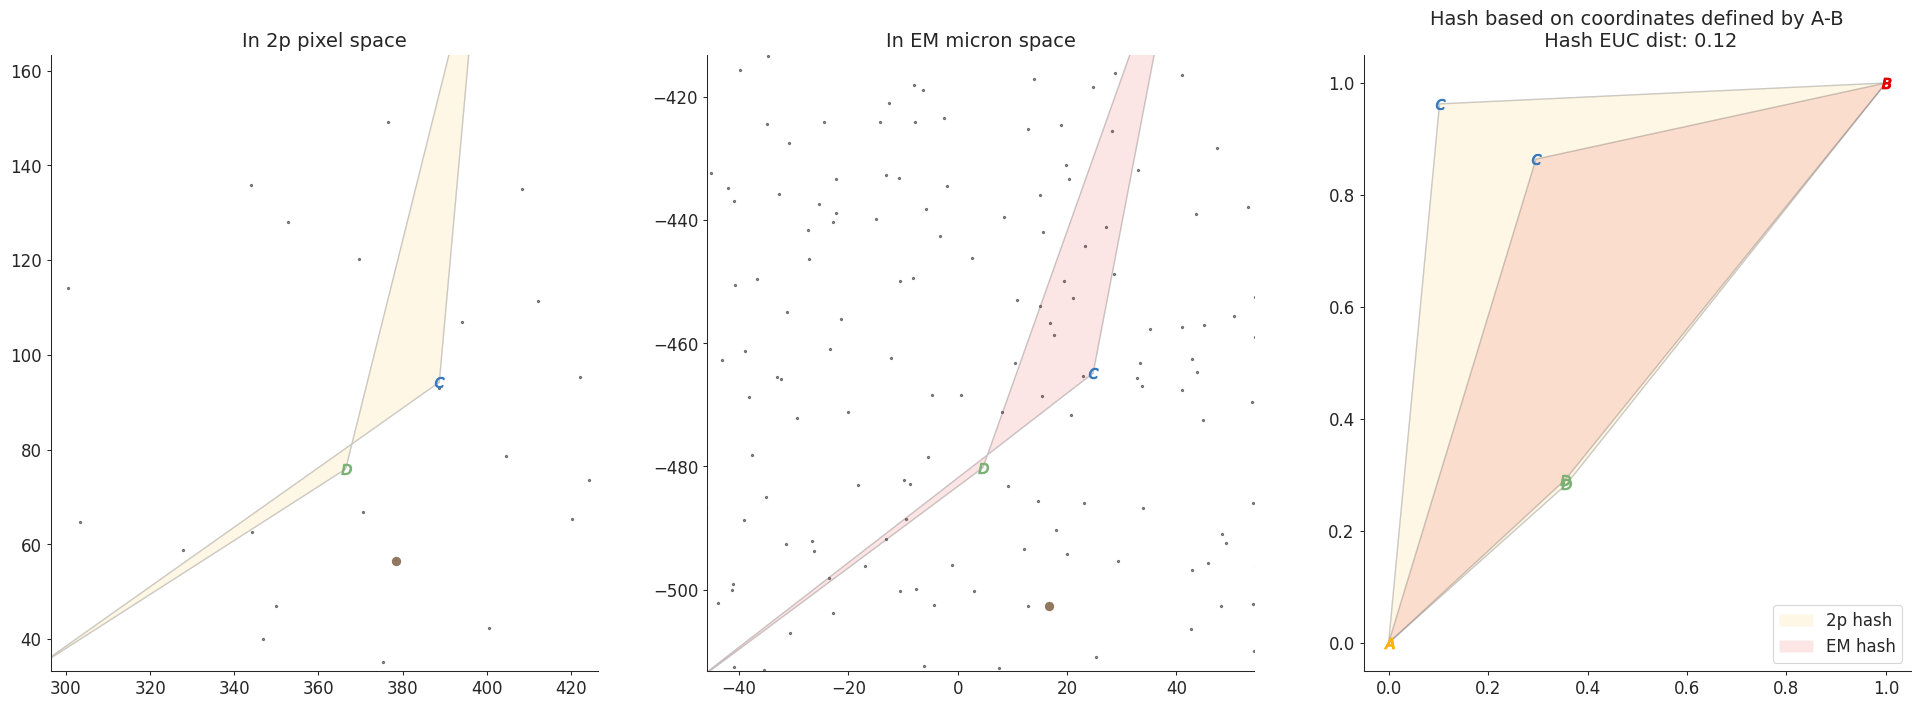

In [21]:
width = 22
#Create boundin box
min_um2 = min_um.copy(); 
min_um2 = min_um2 - buffer
min_um2[1] = (em_y_guesses[iPlane] - width)

max_um2 = max_um.copy()
max_um2 = max_um2 + buffer
max_um2[1] = (em_y_guesses[iPlane] + width)

#Get 2p cells in this plane
indy = np.where(func_roi_centers[:,2] == iPlane)[0]
func_roi_xy_in_plane = func_roi_centers[indy,:2]

#Get all cells in EM volume within bounding region
indy = np.all(nucleus_points_microns > min_um2,axis=1) & np.all(nucleus_points_microns < max_um2,axis=1)
nucleus_points_sub = nucleus_points_microns[indy]
em_xz = nucleus_points_sub[:,[0,2]]
    
quad_2p = np.vstack((np.array([[0,0],[1,1]]),hash_2p.reshape(2,2)))
quad_em = np.vstack((np.array([[0,0],[1,1]]),hash_em.reshape(2,2)))

fig, axes = plt.subplots(1,3,figsize=(24,8))
# plt.suptitle(f'Plane {iPlane}, hash {iH}')

ax = axes[0]; ax.set_title(f'2p plane {iPlane + 1}')
ax.scatter(func_roi_xy_in_plane[:,0],func_roi_xy_in_plane[:,1],color='k',marker='.',s=10,alpha=.5)

ax = axes[1]; ax.set_title('Potential EM matches')
ax.scatter(em_xz[:,0],em_xz[:,1],color='k',marker='.',s=10,alpha=.5) #c=em_y,cmap='viridis'


for jj in range(coreg_2p_xy.shape[0]):
    if np.any(np.all(coreg_em_xz[jj] == hash_list[iH]['ophys_xy'],axis=1)):
        continue
    color = axes[0].scatter(coreg_2p_xy[jj,0], coreg_2p_xy[jj,1],marker= 'o', s=35).get_facecolors()[0]
    axes[1].scatter(coreg_em_xz[jj, 0], coreg_em_xz[jj, 1],facecolors=color, marker='o',s=35)
    
ax=axes[0]; ax.set_title('In 2p pixel space')
ax=axes[1]; ax.set_title('In EM micron space')
plot_quad(hash_list[iH]['ophys_xy'],ax=axes[0],polygon_c=color_palette[0])
plot_quad(hash_list[iH]['em_xz'],ax=axes[1],polygon_c=color_palette[1])

plot_quad(quad_2p,ax=axes[2],polygon_c=color_palette[0],label='2p hash')
plot_quad(quad_em,ax=axes[2],polygon_c=color_palette[1],label='EM hash')

hash_dist = np.linalg.norm(h_2p - h_em)
axes[2].legend(); axes[2].set_title(f'Hash based on coordinates defined by A-B\n Hash EUC dist: {hash_dist:.2f}')
hash_dist_list.append(hash_dist)

center_2p = np.mean(hash_list[iH]['ophys_xy'],axis=0)
center_em = np.mean(hash_list[iH]['em_xz'],axis=0)
if zoom:
    axes[0].set_xlim([center_2p[0]-65,center_2p[0]+65])
    axes[0].set_ylim([center_2p[1]-65,center_2p[1]+65])

    axes[1].set_xlim([center_em[0]-50,center_em[0]+50])
    axes[1].set_ylim([center_em[1]-50,center_em[1]+50])

In [19]:
# def calculate_hash(quad_xy):
quad_xy = tmp_dict['ophys_xy']
#Define cells A & B
max = 0
for i in range(4):
    for j in range(4):
        dist = np.linalg.norm(quad_xy[j]-quad_xy[i])
        if dist > max:
            i_a = i; i_b = j
            max = dist
            
A_xy = quad_xy[i_a]
B_xy = quad_xy[i_b]
A_xy, B_xy

(array([384.42411588, 247.42104344]), array([359.60330357, 434.49975295]))

In [20]:
B_xy - A_xy

array([-24.82081232, 187.07870951])

In [21]:
(quad_xy - A_xy)/(B_xy - A_xy)

array([[-0.        ,  0.        ],
       [ 1.        ,  1.        ],
       [-4.6038342 ,  0.59388676],
       [ 1.45213517,  0.07809621]])

In [ ]:

#Calculate local coordinates
quad_xy_local =  (quad_xy - A_xy)/(B_xy - A_xy)

#Define C&D relative to the coordinate system defined by A-B
i_cd = np.setxor1d([i_a,i_b],np.arange(4))

#Break C/D symmetry by x_c <= x_d & x_c + x_d<=1
if quad_xy_local[i_cd][0,0] < quad_xy_local[i_cd][1,0]:
    i_c = i_cd[0]; i_d = i_cd[1]
else:
    i_c = i_cd[1]; i_d = i_cd[0]
    
#Create hash based on CD local coordinates
quad_hash = np.concatenate((quad_xy_local[i_c],quad_xy_local[i_d]))

#Check to make sure x_c + x_d is less than 1
if (quad_hash[0] + quad_hash[2]) >= 1:
    error = 1
else: 
    error = 0

i_abcd = np.array([i_a,i_b,i_c,i_d])


In [173]:
quad_hash, i_abcd, error = calculate_hash(tmp_dict['em_xz'])
quad_hash

array([-2.00245658e+02,  4.14487228e-01, -1.14784913e+02,  1.79531009e-01])

In [144]:
len(np.unique(coreg_2p_xy[:,0]))

24

In [146]:
coreg_2p_xy[:,0]

array([172.18315505, 223.83636059, 318.00407808, 391.46631984,
       446.04172101, 233.83468478, 172.18315505, 168.51838305,
       243.79118542, 384.42411588, 498.6950205 , 359.60330357,
       475.45726869, 475.36213615, 359.30295343, 446.04172101,
       424.44536988, 402.83982199, 348.38094136, 274.83161981,
       296.34858544, 300.96137339, 170.26339286, 322.38709677,
       151.02202643, 290.93298969])

In [ ]:
for iPlane in range(6):
    print(f'Building hashes for ophys plane {iPlane+1}')
    
    #Get 2p cells in this plane
    indy = np.where(func_roi_centers[:,2] == 0)[0]
    func_roi_xy_in_plane = func_roi_centers[indy,:2]
    roi_names_in_plane = func_roi_names[indy]
    roi_areas_in_plane = func_roi_areas[indy]

    #Create KDTree for easy searching
    em_2p = KDTree(func_roi_xy_in_plane)

    hash_list = []
    #Loop over cells and create hashes with each cell
    for roi_xy in func_roi_xy_in_plane:
        
        #Look at the 20 closest cells in the plane and create quads out of them
        distances, indices = em_2p.query(roi_xy, k=20)

## Create hashes in 2p data

In [33]:
em_coreg = np.array(coreg_df[['pt_position_x','pt_position_y','pt_position_z']],dtype=float)
em_coreg = em_client.transform_position_to_microns(em_coreg)
ophys_coreg = np.array(coreg_df[['ophys_x','ophys_y','ophys_z']],dtype=float)


In [34]:
## Load data
base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data" #Server
base_folder = "/data/v1dd_in_vivo_new_segmentation" # Local on robinson for golden mouse
ophys_client = OPhysClient(base_folder)

## Central volume from golden mouse
mouse_id = 409828; col = 1; vol = 3; plane = 3

sess = ophys_client.load_ophys_session(mouse=mouse_id, column=col, volume=plane)

In [102]:
metrics_13_new = pd.read_csv('/home/david.wyrick/Git/allen_v1dd/data_frames/v1dd_metrics13_new.csv')
metrics_13_new.rename(columns={"Unnamed: 0": "chase_roi"},inplace=True)
# metrics_13_new = metrics_13_new.set_index("Unnamed: 0")
metrics_13_new = metrics_13_new.set_index('chase_roi')
valid_roi_ids = metrics_13_new.index.values



In [35]:
#Get 2p functional data for column 1 volumn 3
nwb_file = '/allen/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data/nwbs/processed/M409828_13_20181213.nwb'
with ROI_mask_nwb(nwb_file, vol=3, mode="r") as rmn:
    # import pdb; pdb.set_trace()
    all_roi_info = [*rmn.yield_roi_info()] 
  

In [36]:
  
# Get 2p ROI center of mass in xy plane, disregarding depth for now
all_roi_raw_center_pts = np.array([center_from_pix_mask(roi.pix_mask).tolist() + [roi.plane_z] for roi in all_roi_info])

# Get names
all_roi_names = np.array([roi.name for roi in all_roi_info])
all_roi_chasenames = np.array([roi.chase_ROI for roi in all_roi_info])

#Get pixel areas
all_roi_areas = np.array([len(roi.pix_mask[0]) for roi in all_roi_info])

#Select only valid and non-duplicate cells
indices = get_array_subset_indices(all_roi_chasenames, valid_roi_ids)
func_roi_centers = all_roi_raw_center_pts[indices]
func_roi_names = all_roi_chasenames[indices]
func_roi_areas = all_roi_areas[indices]


In [37]:
pix_size = 0.77

#How many cells are within a 30x30 pixel grid?
grid_size = 65; grid_micron = grid_size*pix_size
grid_boundaries = np.arange(0,512,grid_size); 
grid_boundaries
# grid_boundaries[-1] = 512
nGrids = len(grid_boundaries)
nCells_per_grid = np.zeros((nGrids,nGrids))


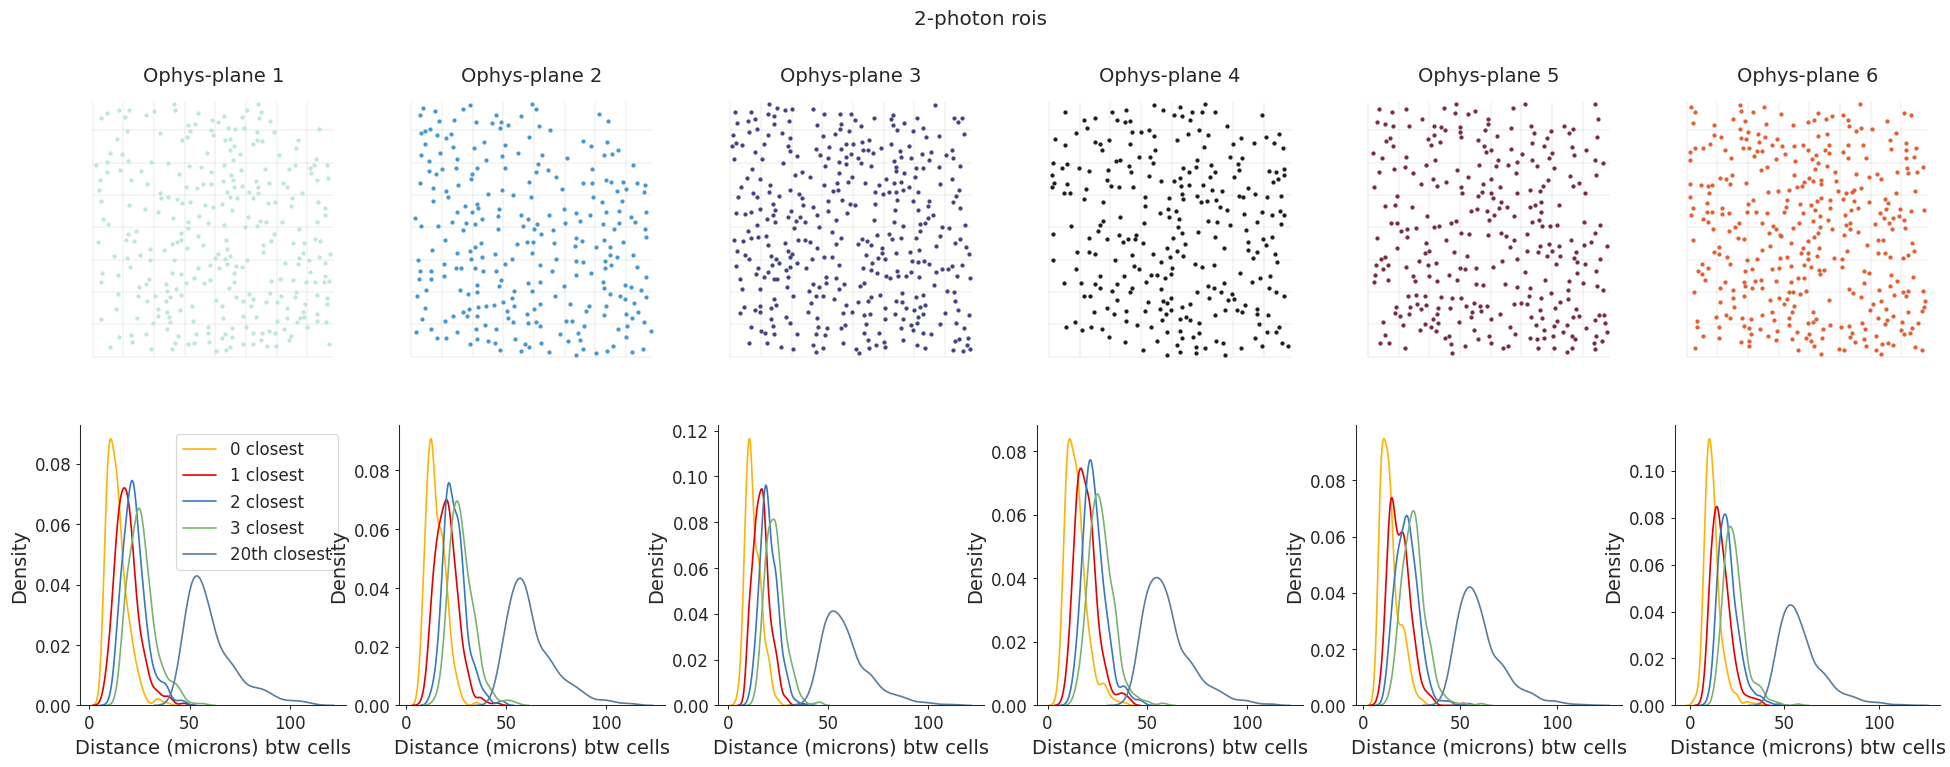

In [38]:
pix_size = 0.77
fig, axes = plt.subplots(2,6,figsize=(24,8))
# plt.suptitle(f'{grid_size}x{grid_size} pixel grids ->  {grid_micron:.1f}x{grid_micron:.1f} microns')
plt.suptitle(f'2-photon rois')

d20_list = []; first_closest = []

distances_per_plane = []
#Loop over ophys planes
for iPlane in range(6):
    
    #Get 2p cells in this plane
    indy = np.where(func_roi_centers[:,2] == iPlane)[0]
    func_roi_xy_in_plane = func_roi_centers[indy,:2]
    roi_names_in_plane = func_roi_names[indy]
    
    for iX, x_bound in enumerate(grid_boundaries):
        for iY, y_bound in enumerate(grid_boundaries):
            #Get grid boundaries and center
            grid_xy_min = np.array([x_bound,y_bound])
            grid_xy_max = grid_xy_min + grid_size
            grid_xy_ctr = grid_xy_min + grid_size/2
            
            #Of these 100 points, how many are within the grid volume?
            nPts = np.sum((np.all(func_roi_xy_in_plane >= grid_xy_min,axis=1)) & (np.all(func_roi_xy_in_plane < grid_xy_max,axis=1)))
            nCells_per_grid[iX,iY] = nPts
            
            # if nPts > 0:
            #     indy = np.where((np.all(func_roi_xy_in_plane >= grid_xy_min,axis=1)) & (np.all(func_roi_xy_in_plane < grid_xy_max,axis=1)))[0]
            #     roi_ids_in_grid = roi_names_in_plane[indy]
            #     for id in nucleus_ids_in_grid:
            #         if id in coreg_em_ids:
            #             coreg_dict[id] = (iX,iY,iZ) #Save grid location     
    
    ax = axes[0,iPlane]; ax.set_title(f'Ophys-plane {iPlane+1}')
    ax.scatter(func_roi_xy_in_plane[:,0],func_roi_xy_in_plane[:,1],color=cc(iPlane/6),marker='.',s=20)
    ax.axis('off')
    # ax.hlines(np.median(em_y),650,1100,color='k',ls='-',zorder=0)
    ax.hlines(grid_boundaries,0,512,color='k',ls='-',zorder=0,alpha=0.05)
    ax.vlines(grid_boundaries,0,512,color='k',ls='-',zorder=0,alpha=0.05)
    ax.set_xlabel('Ophys-x')
    if iPlane == 0:
        ax.set_ylabel('Ophys-y')

    
    # ax = axes[1,iPlane]
    # sns.histplot(nCells_per_grid.ravel(),color=cc(iPlane/6),ax=ax)
    # ax.set_xlabel('# of cells per grid')
    # ax = axes[2,iPlane]
    # proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = sess.get_plane_projection_images(iPlane+1)
    # ax.imshow(proj_de_max, cmap='gray', interpolation='nearest')
    # ax.set_xlim([250-grid_size/2,250+grid_size/2])
    # ax.set_ylim([250-grid_size/2,250+grid_size/2])
    
    #Create KDTree for easy searching
    kdt_2p = KDTree(func_roi_xy_in_plane)
    
    dist_list = []; 
    #Loop over cells and create hashes with each cell
    for roi_xy in func_roi_xy_in_plane:
        
        #Look at the 20 closest cells in the plane and create quads out of them
        distances, indices = kdt_2p.query(roi_xy, k=21)
        dist_list.append(distances[1:5]*pix_size)
        d20_list.append(distances[-1]*pix_size)
        first_closest.append(distances[1]*pix_size)
    distances = np.array(dist_list)
    distances_per_plane.append(distances)
    ax = axes[1,iPlane]
    for i in range(4):
        # sns.histplot(distances[:,i],ax=ax,color=color_palette[i],label=f'{i} closest')
        sns.kdeplot(distances[:,i],ax=ax,color=color_palette[i],label=f'{i} closest')
    sns.kdeplot(d20_list,ax=ax,color=color_palette[6],label='20th closest')
    if iPlane == 0:
        ax.legend()
    ax.set_xlabel('Distance (microns) btw cells')

            

1st closest: mean: 13.45923888059753, range: [2.5337634931703312,38.77829329387099]
20th closest mean: 59.267590105643215, range: [38.85791687216374,118.5518658939807]


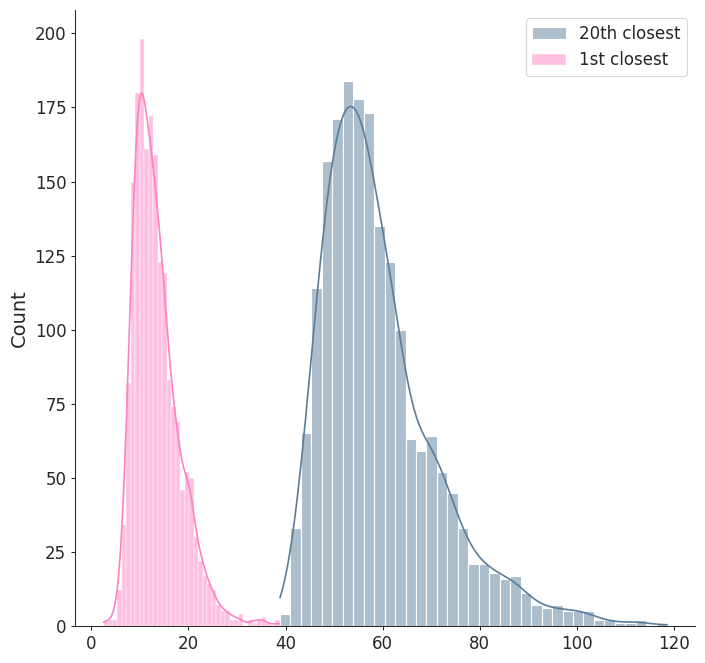

In [39]:
fig, ax = plt.subplots(figsize=(8,8))

sns.histplot(d20_list,ax=ax,color=color_palette[6],kde=True,label=f'20th closest')
sns.histplot(first_closest,ax=ax,color=color_palette[7],kde=True,label=f'1st closest')

print(f'1st closest: mean: {np.mean(first_closest)}, range: [{np.min(first_closest)},{np.max(first_closest)}]')
print(f'20th closest mean: {np.mean(d20_list)}, range: [{np.min(d20_list)},{np.max(d20_list)}]')
ax.legend()

In [40]:
AC_min = 10
AD_min = 15
BC_min = 20
BD_min = 15

grid_size_em = 50
grid_size_em/pix_size

64.93506493506493

Building hashes for ophys plane 1
	299 rois in plane, 5780 hashes created
Building hashes for ophys plane 2
	268 rois in plane, 5176 hashes created
Building hashes for ophys plane 3
	383 rois in plane, 7617 hashes created
Building hashes for ophys plane 4
	279 rois in plane, 5392 hashes created
Building hashes for ophys plane 5
	304 rois in plane, 5951 hashes created
Building hashes for ophys plane 6
	368 rois in plane, 7302 hashes created


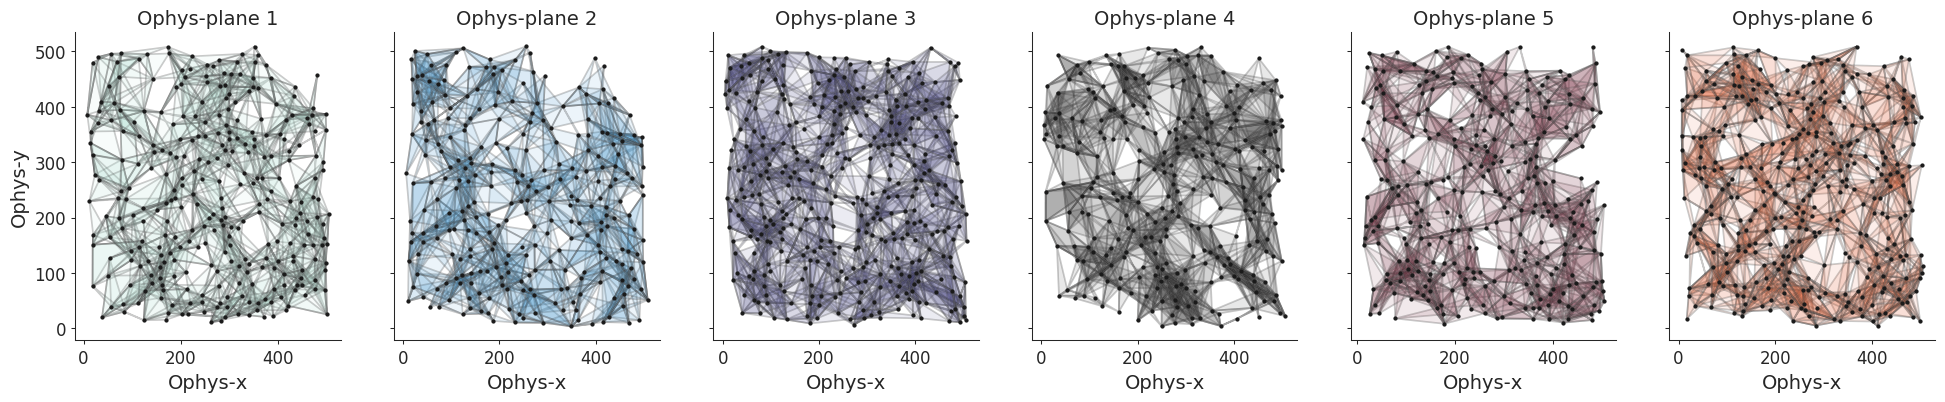

In [41]:
cc  = sns.color_palette("icefire", as_cmap=True)
cc2  = sns.color_palette("Spectral", as_cmap=True)
pix_size = 0.77
# pdfdoc = PdfPages(os.path.join(PlotDir,'hashes_per_2pcell.pdf'))
fig, axes = plt.subplots(1,6,figsize=(24,4),sharey=True)

failed = 0
star_logbook = []
hash_dict = {}
#Loop over ophys planes
for iPlane in range(6):
    print(f'Building hashes for ophys plane {iPlane+1}')
    
    #Get 2p cells in this plane
    indy = np.where(func_roi_centers[:,2] == iPlane)[0]
    func_roi_xy_in_plane = func_roi_centers[indy,:2]
    roi_names_in_plane = func_roi_names[indy]
    roi_areas_in_plane = func_roi_areas[indy]
    nCells = len(func_roi_xy_in_plane)

    #Create KDTree for easy searching
    kdt_2p = KDTree(func_roi_xy_in_plane)

    hash_list = []; stars_used = np.zeros((len(func_roi_xy_in_plane)))
    #Loop over cells and create hashes with each cell
    for iRoi, roi_xy in enumerate(func_roi_xy_in_plane):
        
        #Look at the 20 closest cells in the plane and create quads out of them
        distances, indices = kdt_2p.query(roi_xy, k=26)
        
        #Loop through 20 closest cells, creating hashes with each set of 4
        hash_building = True; iter = 0; hashes_built = 0
        
        quad_list = []
        #Sub-select 4 cells to create 3 different hashes
        while hash_building:
            indy3 = np.random.choice(indices[1:],3,replace=False)
            indy4 = np.concatenate(([indices[0]],indy3))
            
            #Get quad xy
            quad_2p = func_roi_xy_in_plane[indy4]
                        
            #Calculate hash from 4 points
            hash_2p, i_abcd, error = calculate_hash(quad_2p)
            quad_indy = indy4[i_abcd]
            ophys_xy = func_roi_xy_in_plane[quad_indy]

            # pdb.set_trace()
            iter += 1
            #Check to quad was successfully created
            if (error == 1):
                failed += 1
                if iter > 1000:
                    hash_building = False
                continue
    
            AB = np.linalg.norm(ophys_xy[0] - ophys_xy[1])*pix_size
            AC = np.linalg.norm(ophys_xy[0]-ophys_xy[2])*pix_size
            AD = np.linalg.norm(ophys_xy[0]-ophys_xy[3])*pix_size
            BC = np.linalg.norm(ophys_xy[1]-ophys_xy[2])*pix_size
            BD = np.linalg.norm(ophys_xy[1]-ophys_xy[3])*pix_size

            #Check scale
            if (AB < grid_size_em) | (AB > 2*grid_size_em):
                continue
            
            # if (AC < AC_min) | (AD < AD_min) | (BC < BC_min) | (BD < BD_min):
            #     continue

            #Check if hash has already been created
            for q in quad_list:
                if np.all(q-ophys_xy == 0):
                    continue
            
            quad_list.append(ophys_xy)
            for i in quad_indy:
                stars_used[i] += 1
                
            #Save quad
            hash_list.append({'rois': roi_names_in_plane[quad_indy], 
                            'ophys_xy': ophys_xy,
                            'hash': hash_2p,
                            'plane': iPlane,
                            'center': np.mean(ophys_xy,axis=0),
                            'index': iRoi,
                            'AB': AB})
            
            hashes_built += 1
            if hashes_built == 20:
                hash_building = False
            
            # # # # pdb.set_trace()
            # if iPlane == 0:
            #     fig2, axes2 = plt.subplots(1,2,figsize=(10,5))
            #     plt.suptitle(f'Plane {iPlane + 1}, Roi {iRoi}, sub-index {hashes_built}')
            #     axes2[0].scatter(func_roi_xy_in_plane[:,0],func_roi_xy_in_plane[:,1],color=cc(iPlane/6),marker='.',s=20,zorder=2)
            
            #     ax = axes2[0]; ax.set_title(f'AB length: {AB*pix_size:.1f} microns')
            #     ax.scatter(quad_2p[0,0],quad_2p[0,1],color='k',marker='x',s=20,zorder=2)
            #     ax.scatter(quad_2p[1:,0],quad_2p[1:,1],color='k',marker='.',s=20,zorder=2)
            #     i_a = 0; i_b = 1; i_c = 2; i_d = 3
            #     ax.plot(ophys_xy[np.array([i_a,i_d,i_b,i_c,i_a]),0],ophys_xy[np.array([i_a,i_d,i_b,i_c,i_a]),1],color='k',alpha=0.25,zorder=1)
            #     poly = Polygon(ophys_xy[np.array([i_a,i_d,i_b,i_c])], facecolor=cc2(hashes_built/10), alpha=0.2)
            #     ax.add_patch(poly)

            #     ax = axes2[1]; ax.set_title('In local coordinates defined by pts A & B')
            #     quad_xy_local = np.vstack((np.array([[0,0],[1,1]]),hash_2p.reshape(2,2)))
            #     plot_quad(quad_xy_local,ax=ax)

            #     pdfdoc.savefig(fig2)
            #     plt.close(fig2)
        # pdfdoc.close()
        # pdb.set_trace()
    star_logbook.append(stars_used)
    print(f'\t{nCells} rois in plane, {len(hash_list)} hashes created')   
    #Save hashes for this plane
    hash_dict[iPlane] = hash_list           
    
    #Plot hashes
    ax = axes[iPlane]; ax.set_title(f'Ophys-plane {iPlane+1}')
    ax.scatter(func_roi_xy_in_plane[:,0],func_roi_xy_in_plane[:,1],color='k',marker='.',s=20,zorder=2)

    ax.set_xlabel('Ophys-x')
    if iPlane == 0:
        ax.set_ylabel('Ophys-y')

    hash_index = np.array([t['index'] for t in hash_list])
    for iRoi in range(nCells):
        indy = np.where(hash_index == iRoi)[0]
        if len(indy) == 0:
            continue
        for ii in np.random.choice(indy,2):
            roi_xy = hash_list[ii]['ophys_xy']
            i_a = 0; i_b = 1; i_c = 2; i_d = 3
            ax.plot(roi_xy[np.array([i_a,i_d,i_b,i_c,i_a]),0],roi_xy[np.array([i_a,i_d,i_b,i_c,i_a]),1],color='k',alpha=0.25,zorder=1)
            poly = Polygon(roi_xy[np.array([i_a,i_d,i_b,i_c])], facecolor=cc(iPlane/6), alpha=0.1)
            ax.add_patch(poly)

# pdfdoc.close()
    

Text(0.5, 0, '# of times roi used in quad')

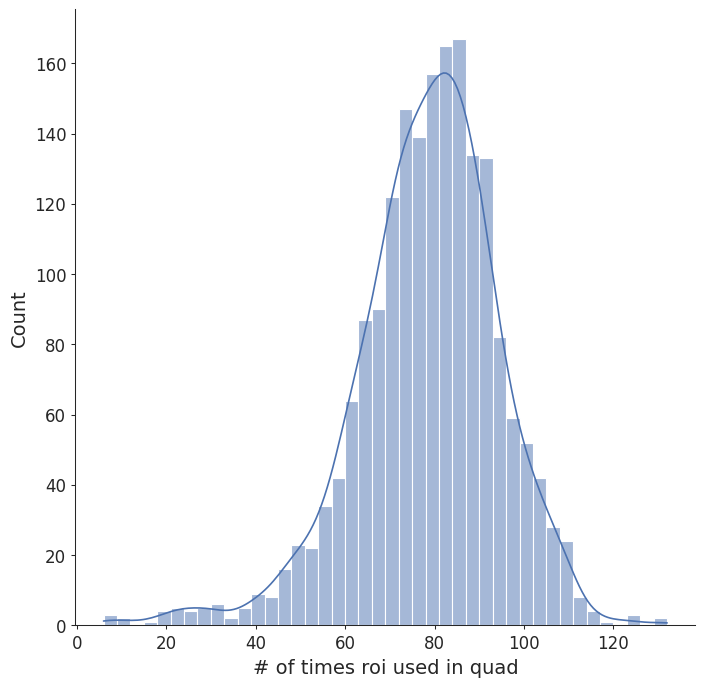

In [42]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(np.concatenate(star_logbook),ax=ax,kde=True)
ax.set_xlabel("# of times roi used in quad")

In [43]:
from itertools import combinations


Building hashes for ophys plane 1
	299 rois in plane, 23701 hashes created
Building hashes for ophys plane 2
	268 rois in plane, 20722 hashes created
Building hashes for ophys plane 3
	383 rois in plane, 30353 hashes created
Building hashes for ophys plane 4


KeyboardInterrupt: 

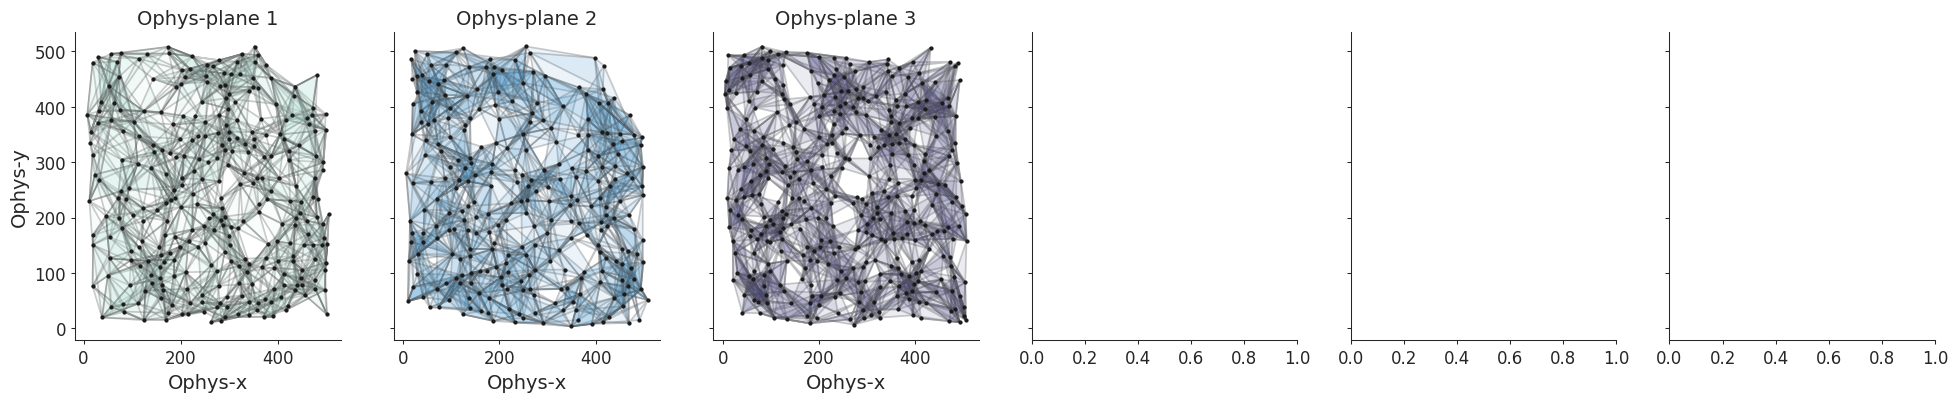

In [44]:
cc  = sns.color_palette("icefire", as_cmap=True)
cc2  = sns.color_palette("Spectral", as_cmap=True)
pix_size = 0.77

fig, axes = plt.subplots(1,6,figsize=(24,4),sharey=True)

failed = 0
star_logbook = []
hash_dict2 = {}
#Loop over ophys planes
for iPlane in range(6):
    print(f'Building hashes for ophys plane {iPlane+1}')
    
    #Get 2p cells in this plane
    indy = np.where(func_roi_centers[:,2] == iPlane)[0]
    func_roi_xy_in_plane = func_roi_centers[indy,:2]
    roi_names_in_plane = func_roi_names[indy]
    roi_areas_in_plane = func_roi_areas[indy]
    nCells = len(func_roi_xy_in_plane)

    #Create KDTree for easy searching
    kdt_2p = KDTree(func_roi_xy_in_plane)

    hash_list = []; stars_used = np.zeros((len(func_roi_xy_in_plane)))
    indy_list = []
    #Loop over cells and create hashes with each cell
    for iRoi, roi_xy in enumerate(func_roi_xy_in_plane):
        
        #Look at the 20 closest cells in the plane and create quads out of them
        distances, indices = kdt_2p.query(roi_xy, k=21)
        hash_building = True; iter = 0; hashes_built = 0
        
        all_combos = list(combinations(indices[1:], 3))
        #Loop through 20 closest cells, creating hashes with each possible set of 4
        for indy3 in all_combos:
            indy4 = np.concatenate(([indices[0]],indy3))
            
            #Get quad xy
            quad_2p = func_roi_xy_in_plane[indy4]
                        
            #Calculate hash from 4 points
            hash_2p, i_abcd, error = calculate_hash(quad_2p)
            quad_indy = indy4[i_abcd]
            ophys_xy = func_roi_xy_in_plane[quad_indy]

            #Check to quad was successfully created
            if (error == 1):
                failed += 1
                continue
    
            AB = np.linalg.norm(ophys_xy[0] - ophys_xy[1])*pix_size
            AC = np.linalg.norm(ophys_xy[0]-ophys_xy[2])*pix_size
            AD = np.linalg.norm(ophys_xy[0]-ophys_xy[3])*pix_size
            BC = np.linalg.norm(ophys_xy[1]-ophys_xy[2])*pix_size
            BD = np.linalg.norm(ophys_xy[1]-ophys_xy[3])*pix_size

            # #Check scale
            # if (AB < grid_size_em) | (AB > 2*grid_size_em):
            #     continue
            
            # if (AC < AC_min) | (AD < AD_min) | (BC < BC_min) | (BD < BD_min):
            #     continue
            
            indy_list.append(quad_indy)
            #Save quad
            hash_list.append({'rois': roi_names_in_plane[quad_indy], 
                            'ophys_xy': ophys_xy,
                            'hash': hash_2p,
                            'plane': iPlane,
                            'center': np.mean(ophys_xy,axis=0),
                            'index': iRoi,
                            'AB': AB})
                            
    #Remove duplicate quads
    _, indices = np.unique(indy_list,axis=0,return_index=True)
    hash_list_uniq = []
    for ii, hash in enumerate(hash_list):
        if ii in indices:
            hash_list_uniq.append(hash)
            quad_indy = indy_list[ii]
            for jj in quad_indy:
                stars_used[jj] += 1
                
    star_logbook.append(stars_used)
    print(f'\t{nCells} rois in plane, {len(hash_list_uniq)} hashes created')   
    
    #Save hashes for this plane
    hash_dict2[iPlane] = hash_list_uniq           
    
    #Plot hashes
    ax = axes[iPlane]; ax.set_title(f'Ophys-plane {iPlane+1}')
    ax.scatter(func_roi_xy_in_plane[:,0],func_roi_xy_in_plane[:,1],color='k',marker='.',s=20,zorder=2)

    ax.set_xlabel('Ophys-x')
    if iPlane == 0:
        ax.set_ylabel('Ophys-y')

    hash_index = np.array([t['index'] for t in hash_list])
    for iRoi in range(nCells):
        indy = np.where(hash_index == iRoi)[0]
        if len(indy) == 0:
            continue
        for ii in np.random.choice(indy,2):
            roi_xy = hash_list[ii]['ophys_xy']
            i_a = 0; i_b = 1; i_c = 2; i_d = 3
            ax.plot(roi_xy[np.array([i_a,i_d,i_b,i_c,i_a]),0],roi_xy[np.array([i_a,i_d,i_b,i_c,i_a]),1],color='k',alpha=0.25,zorder=1)
            poly = Polygon(roi_xy[np.array([i_a,i_d,i_b,i_c])], facecolor=cc(iPlane/6), alpha=0.1)
            ax.add_patch(poly)
    

Text(0.5, 0, '# of times roi used in quad')

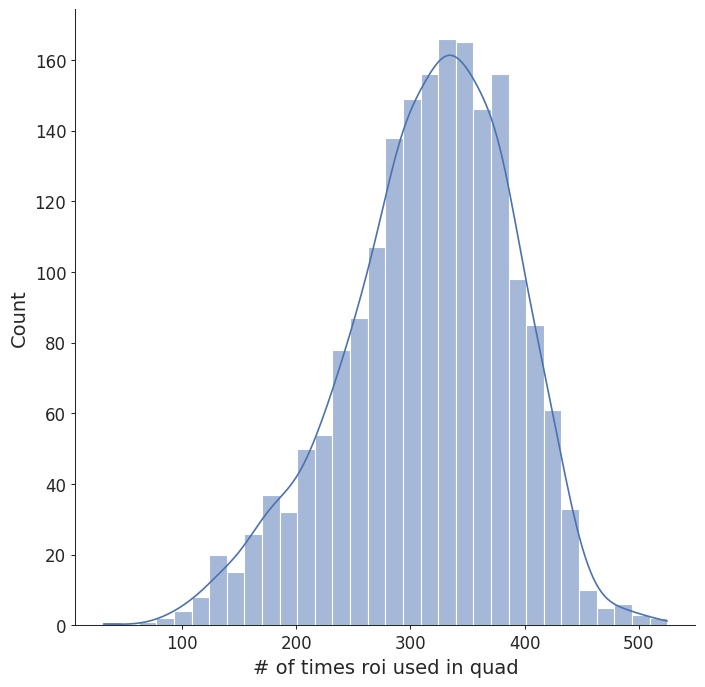

In [95]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(np.concatenate(star_logbook),ax=ax,kde=True)
ax.set_xlabel("# of times roi used in quad")

Text(0.5, 0, 'Hash distances')

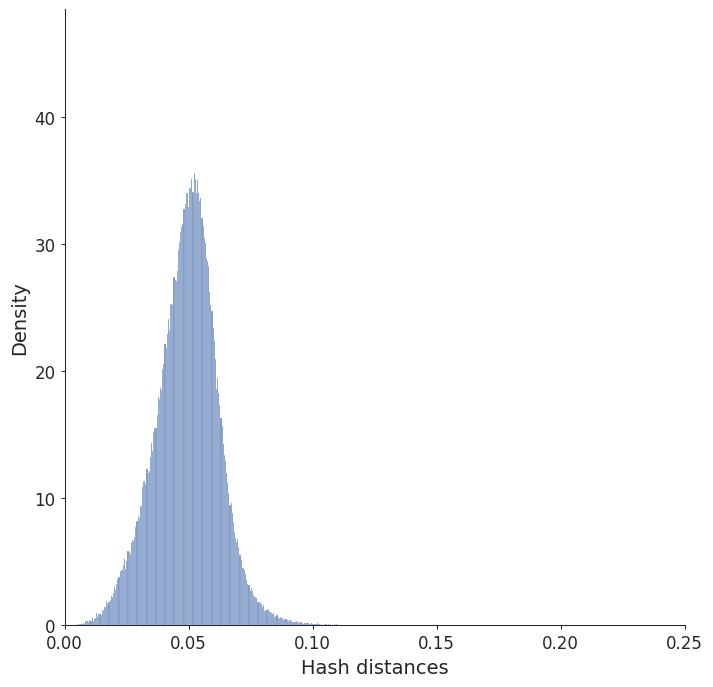

In [35]:
#Concatenate all hashes from each plane
all_hashes = []
for iP in range(6):
    all_hashes.extend(hash_dict[iP])
    
# all_hashes = hash_dict[0]
## Let's try to search for hashes 
hashes = np.array([t['hash'] for t in all_hashes])
quad_xy = np.array([t['hash'] for t in all_hashes])
hash_planes = np.array([t['plane'] for t in all_hashes])

#Create KD tree of hashes
hash_kdt = KDTree(hashes)

dist_list = []; indy_list = []; closest_dist = []
for ii, hash in enumerate(hashes):
    #Query and inspect distances
    distances, indices = hash_kdt.query(hash, k=11)
    dist_list.append(distances[1:])
    closest_dist.append(distances[1])
    if np.any(distances[1:] < 0.15):
        indy_list.append(ii)
    
    
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(np.concatenate(dist_list),stat='density')
ax.set_xlim([0,0.25]); ax.set_xlabel('Hash distances')
# ax.vlines(0.15,0,3)

In [55]:
dist_thresh = 0.15

pdfdoc = PdfPages(os.path.join(PlotDir,'similar_hashes5.pdf'))
for iHash in indy_list:
    hash = hashes[iHash]
    quad_xy_local = np.vstack((np.array([[0,0],[1,1]]),hash.reshape(2,2)))
    i_a = 0; i_b = 1; i_c = 2; i_d = 3
    
    #Query tree
    distances, indices = hash_kdt.query(hash, k=11)
    
    #Plot main hash
    fig, ax = plt.subplots(figsize=(8,8))
    plot_quad(quad_xy_local,ax=ax,polygon_c=cc(0))
    
    #Plot similar hashes
    for ii, (indy, d) in enumerate(zip(indices[1:],distances[1:])):
        if d < dist_thresh:
            hash = hashes[indy]
            plane = hash_planes[indy]
            quad_xy_local = np.vstack((np.array([[0,0],[1,1]]),hash.reshape(2,2)))
            plot_quad(quad_xy_local,ax=ax,polygon_c=cc(ii/10),label=f'Hash {indy}, plane {plane}')
    ax.legend()
    pdfdoc.savefig(fig)
    plt.close(fig)
            
pdfdoc.close()
    
    
    
    

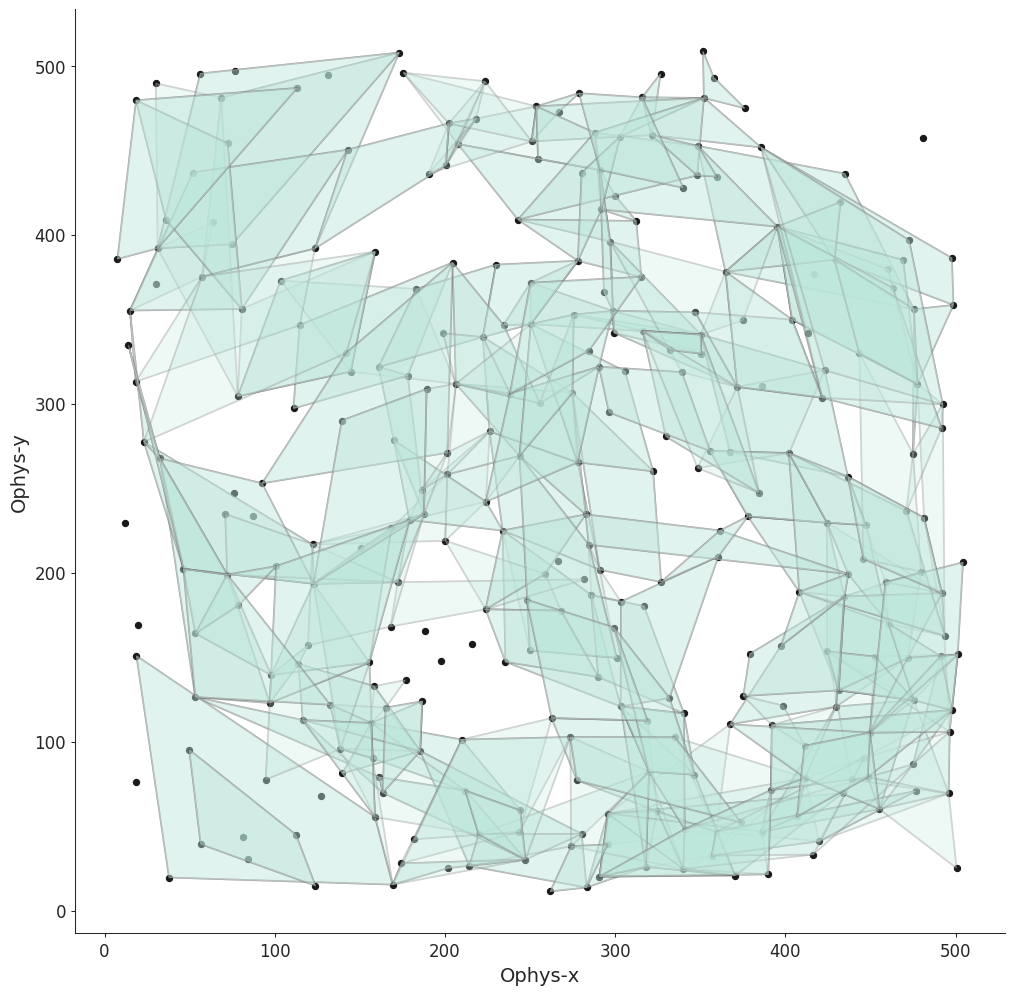

In [44]:
iPlane = 0
hash_list = hash_dict2[iPlane]

## Let's try to search for hashes 
hashes = np.array([t['hash'] for t in hash_list])
ophys_xys = np.array([t['ophys_xy'] for t in hash_list])
hash_index = np.array([t['index'] for t in hash_list])

#Get 2p cells in this plane
indy = np.where(func_roi_centers[:,2] == iPlane)[0]
func_roi_xy_in_plane = func_roi_centers[indy,:2]
roi_names_in_plane = func_roi_names[indy]
roi_areas_in_plane = func_roi_areas[indy]
nCells = len(func_roi_xy_in_plane)


fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(func_roi_xy_in_plane[:,0],func_roi_xy_in_plane[:,1],marker='o',color='k',s=20)
# ax.axis('off')
# # ax.hlines(np.median(em_y),650,1100,color='k',ls='-',zorder=0)
# ax.hlines(grid_boundaries,0,512,color='k',ls='-',zorder=0,alpha=0.05)
# ax.vlines(grid_boundaries,0,512,color='k',ls='-',zorder=0,alpha=0.05)
ax.set_xlabel('Ophys-x')
ax.set_ylabel('Ophys-y')

for iRoi in range(nCells):
    indy = np.where(hash_index == iRoi)[0]
    if len(indy) == 0:
        continue
    for ii in np.random.choice(indy,2):
        roi_xy = ophys_xys[ii]
        i_a = 0; i_b = 1; i_c = 2; i_d = 3
        ax.plot(roi_xy[np.array([i_a,i_d,i_b,i_c,i_a]),0],roi_xy[np.array([i_a,i_d,i_b,i_c,i_a]),1],color='k',alpha=0.25,zorder=1)
        poly = Polygon(roi_xy[np.array([i_a,i_d,i_b,i_c])], facecolor=cc(iPlane/6), alpha=0.25)
        ax.add_patch(poly)

In [40]:
all_hashes = []
for iP in range(6):
    all_hashes.extend(hash_dict[iP])

# all_hashes = hash_dict[0]
## Let's try to search for hashes 
hashes = np.array([t['hash'] for t in all_hashes])
quad_xy = np.array([t['ophys_xy'] for t in all_hashes])
hash_planes = np.array([t['plane'] for t in all_hashes])
sub_indices = np.array([t['sub_index'] for t in all_hashes])
np.unique(sub_indices)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

AB -> range: [20.8,192.5], mean: 81.3, std: 18.9
AC -> range: [2.5,144.2], mean: 33.5, std: 16.2
AD -> range: [2.5,149.3], mean: 40.4, std: 14.9
BC -> range: [6.9,182.1], mean: 54.4, std: 16.5
BD -> range: [2.5,155.7], mean: 44.4, std: 15.7


Text(0.5, 0, 'Euc distance between hash points (microns)')

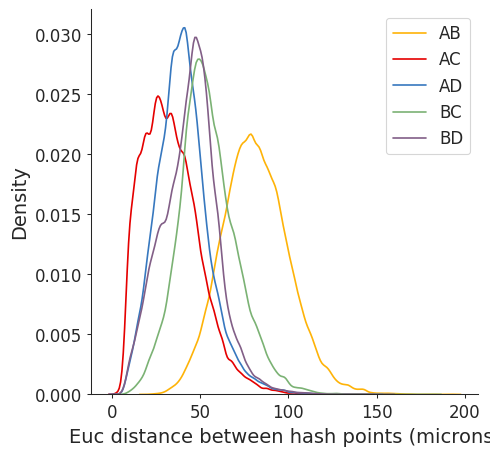

In [96]:
pix_size = 0.77
## What are the size of the query hashes? 
# #Concatenate all hashes from each plane
all_hashes = []
for iP in range(6):
    all_hashes.extend(hash_dict2[iP])

# all_hashes = hash_dict[0]
## Let's try to search for hashes 
hashes = np.array([t['hash'] for t in all_hashes])
quad_xy = np.array([t['ophys_xy'] for t in all_hashes])
hash_planes = np.array([t['plane'] for t in all_hashes])
# sub_indices = np.array([t['sub_index'] for t in all_hashes])

# fig, axes = plt.subplots(3,6,figsize=(18,9),sharey=True,sharex=True)
# plt.suptitle('Hash sizes?',y=0.92)
lengths = []
# for iSub in range(18):
fig, ax = plt.subplots(figsize=(5,5))
# ax = axes[iSub//6,iSub%6]; ax.set_title(f'Sub-index {iSub}')
# indy = np.where(sub_indices == iSub)[0]

#Calculate distance between A-B, A-C, A-D, B-C, B-D
AB = []; BC = []; AC = []; AD = []; BC = []; BD = []
for quad in quad_xy:
    AB.append(np.linalg.norm(quad[0]-quad[1]))
    AC.append(np.linalg.norm(quad[0]-quad[2]))
    AD.append(np.linalg.norm(quad[0]-quad[3]))
    BC.append(np.linalg.norm(quad[1]-quad[2]))
    BD.append(np.linalg.norm(quad[1]-quad[3]))
    
print(f'AB -> range: [{np.min(AB)*pix_size:.1f},{np.max(AB)*pix_size:.1f}], mean: {np.mean(AB)*pix_size:.1f}, std: {np.std(AB)*pix_size:.1f}')
print(f'AC -> range: [{np.min(AC)*pix_size:.1f},{np.max(AC)*pix_size:.1f}], mean: {np.mean(AC)*pix_size:.1f}, std: {np.std(AC)*pix_size:.1f}')
print(f'AD -> range: [{np.min(AD)*pix_size:.1f},{np.max(AD)*pix_size:.1f}], mean: {np.mean(AD)*pix_size:.1f}, std: {np.std(AD)*pix_size:.1f}')
print(f'BC -> range: [{np.min(BC)*pix_size:.1f},{np.max(BC)*pix_size:.1f}], mean: {np.mean(BC)*pix_size:.1f}, std: {np.std(BC)*pix_size:.1f}')
print(f'BD -> range: [{np.min(BD)*pix_size:.1f},{np.max(BD)*pix_size:.1f}], mean: {np.mean(BD)*pix_size:.1f}, std: {np.std(BD)*pix_size:.1f}')
sns.kdeplot(np.array(AB)*pix_size,ax=ax,color=color_palette[0],label='AB')
sns.kdeplot(np.array(AC)*pix_size,ax=ax,color=color_palette[1],label='AC')
sns.kdeplot(np.array(AD)*pix_size,ax=ax,color=color_palette[2],label='AD')
sns.kdeplot(np.array(BC)*pix_size,ax=ax,color=color_palette[3],label='BC')
sns.kdeplot(np.array(BD)*pix_size,ax=ax,color=color_palette[4],label='BD')

lengths.append((np.mean(np.array(AB)*pix_size),np.mean(np.array(AC)*pix_size),np.mean(np.array(AD)*pix_size),np.mean(np.array(BC)*pix_size),np.mean(np.array(BD)*pix_size)))

ax.legend()
ax.set_xlabel('Euc distance between hash points (microns)')  

## Create hashes in EM data

Plane 1:  min: 339.4, max: 365.2,  mean: 352.8, median: 353.0 width: 25.8, 95th%tile: 363.4, std: 7.4
Plane 2:  min: 352.7, max: 379.4,  mean: 366.5, median: 364.9 width: 26.6, 95th%tile: 379.2, std: 7.8
Plane 3:  min: 361.1, max: 396.8,  mean: 375.0, median: 373.1 width: 35.7, 95th%tile: 392.1, std: 8.5
Plane 4:  min: 373.2, max: 402.6,  mean: 386.3, median: 385.5 width: 29.4, 95th%tile: 395.9, std: 7.2
Plane 5:  min: 384.6, max: 425.4,  mean: 404.1, median: 403.6 width: 40.9, 95th%tile: 424.0, std: 12.3
Plane 6:  min: 409.0, max: 442.1,  mean: 419.8, median: 415.1 width: 33.0, 95th%tile: 434.6, std: 8.9


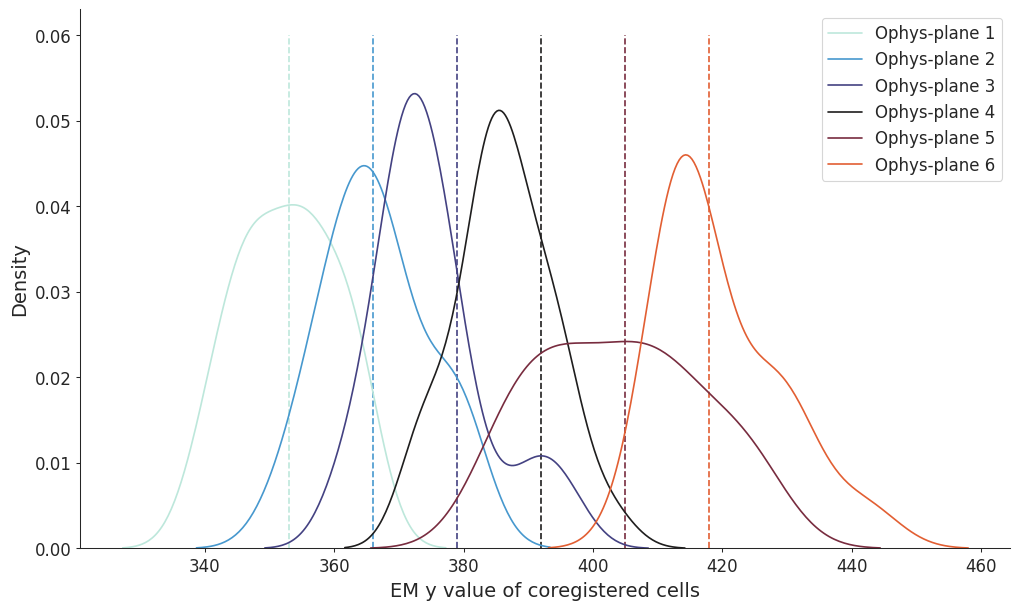

In [34]:
scalar = 1000
##Plot coregistered cells from each plane and the corresponding EM locations
fig, ax = plt.subplots(figsize=(12,7))
cc = sns.color_palette("icefire", as_cmap=True)
em_y_list = []
marker_list = ['o','x','^','*','+','s']
plane0 = 353

em_y_guesses = [plane0 + 13*i for i in range(6)]
for ii in range(6):
    

    # #Plot all 2p cells in plane
    # indy = all_2p_cell_centers[:,2] == ii
    # ax.scatter(all_2p_cell_centers[indy,0], all_2p_cell_centers[indy,1],marker= '.', color='k',s=35)

    sub_df = coreg_df.loc[coreg_df.ophys_plane == ii+1]
    em_xyz = np.array(sub_df[["pt_position_x","pt_position_y", "pt_position_z"]],dtype=float)
    em_coreg_microms = em_client.transform_position_to_microns(em_xyz)
    
    em_xz = em_coreg_microms[:,[0,2]] #np.array(sub_df[["pt_position_x", "pt_position_z"]],dtype=float)/scalar
    em_y = em_coreg_microms[:,1]
    
    ophys_xy = np.array(sub_df[["ophys_x", "ophys_y"]],dtype=float)

    em_y_list.append(em_y)
    
    sns.kdeplot(em_y,color=cc(ii/6),ax=ax,label=f'Ophys-plane {ii+1}')
    ax.vlines(em_y_guesses[ii],0,0.06,color=cc(ii/6),ls='--',zorder=0)
    # ax.scatter(em_xz[:,0],em_y,color=cc(ii/6),marker=marker_list[ii],s=30,label=f'Ophys-plane {ii+1}')
    # ax.hlines(em_y_guesses[ii],650,1100,color=cc(ii/6),ls='--',zorder=0)
    
    # print(f'Ophys plane {ii+1}: [{np.min(em_y):.1f},{np.max(em_y):.1f}], [{np.mean(em_y)-50:.1f},{np.mean(em_y)+50:.1f}]')
    print(f'Plane {ii+1}:  min: {np.min(em_y):.1f}, max: {np.max(em_y):.1f},  mean: {np.mean(em_y):.1f}, median: {np.median(em_y):.1f} width: {np.max(em_y)-np.min(em_y):.1f}, 95th%tile: {np.percentile(em_y,95):.1f}, std: {np.std(em_y):.1f}')
    
    # mean_list.append(np.median(em_y))
    
ax.set_xlabel('EM y value of coregistered cells')
ax.legend()


352.81014707094 24 24
366.5292055252722 15 15
374.95837676471484 50 50
386.28675595587697 25 25
404.10169485130905 30 31
419.7726767412654 16 16


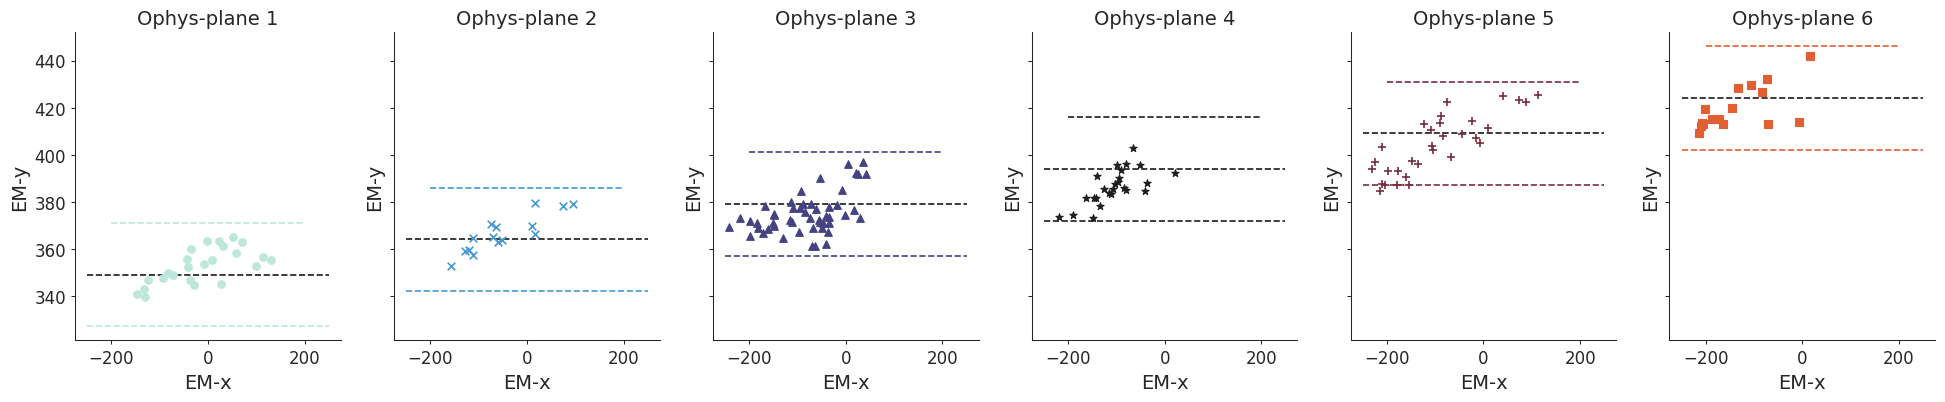

In [50]:
scalar = 1000
##Plot coregistered cells from each plane and the corresponding EM locations

fig, axes = plt.subplots(1,6,figsize=(24,4),sharey=True,sharex=True)
cc = sns.color_palette("icefire", as_cmap=True)
em_y_list = []
marker_list = ['o','x','^','*','+','s']
plane0 = 353
em_y_guesses = [plane0 + 13*i for i in range(6)]

plane0 = 349

em_y_guesses = [plane0 + 15*i for i in range(6)]

width = 22
for ii in range(6):
    
    # #Plot all 2p cells in plane
    # indy = all_2p_cell_centers[:,2] == ii
    # ax.scatter(all_2p_cell_centers[indy,0], all_2p_cell_centers[indy,1],marker= '.', color='k',s=35)

    #Coregistered cells
    sub_df = coreg_df.loc[coreg_df.ophys_plane == ii+1]
    coreg_em_microns = em_client.transform_position_to_microns(np.array(sub_df[["pt_position_x","pt_position_y", "pt_position_z"]],dtype=float))
    coreg_em_xz = coreg_em_microns[:,[0,2]]; coreg_em_y = coreg_em_microns[:,1]
    coreg_2p_xy = np.array(sub_df[["ophys_x", "ophys_y"]],dtype=float)

    em_y_list.append(coreg_em_y)
    
    # sns.kdeplot(em_y,color=cc(ii/6),ax=ax,label=f'Ophys-plane {ii+1}')
    # ax.vlines(em_y_guesses[ii],0,0.022,color=cc(ii/6),ls='--',zorder=0)
    
    ax = axes[ii]; ax.set_title(f'Ophys-plane {ii+1}')
    ax.scatter(coreg_em_xz[:,0],coreg_em_y,color=cc(ii/6),marker=marker_list[ii],s=30)
    
    ax.hlines(em_y_guesses[ii],-250,250,color='k',ls='--',zorder=0)
    
    ax.hlines(em_y_guesses[ii]-width,-250,250,color=cc(ii/6),ls='--',zorder=0)
    # if iPlane == 5:
    #     ax.hlines(em_y_guesses[ii]+25,-200,200,color=cc(ii/6),ls='--',zorder=0)
    #     print((em_y > em_y_guesses[ii]-22) & (em_y < em_y_guesses[ii]+25))
    # else:
    ax.hlines(em_y_guesses[ii]+width,-200,200,color=cc(ii/6),ls='--',zorder=0)
    print(np.mean(coreg_em_y),np.sum((coreg_em_y > em_y_guesses[ii]-width) & (coreg_em_y < em_y_guesses[ii]+width)),len(coreg_em_y))
    # ax.hlines(lower_plane_bounds[ii],-200,200,color=cc(ii/6),ls='--',zorder=0)
    # ax.hlines(upper_plane_bounds[ii],-200,200,color=cc(ii/6),ls='--',zorder=0)
    ax.set_xlabel('EM-x')
    ax.set_ylabel('EM-y')
    # print(f'Ophys plane {ii+1}: [{np.min(em_y):.1f},{np.max(em_y):.1f}], [{np.mean(em_y)-50:.1f},{np.mean(em_y)+50:.1f}]')
    
# ax.set_xlabel('EM y value of coregistered cells')
# ax.legend()
    

In [126]:
volume_thresh = 150
em_client = EMClient()

#Create query box of potential EM objects this ophys data could be coregistered to

# query_bbox = np.array([min_nm - buffer,max_nm + buffer])
#Get all cells in EM volume within bounding region
nucleus_table = em_client.materialize.query_table(
    "nucleus_detection_v0")#,filter_spatial_dict={"pt_position": query_bbox})
nucleus_table = nucleus_table.loc[nucleus_table.volume > volume_thresh]
nucleus_table.reset_index(inplace=True)

#Extract point position 
nucleus_pts = np.array([i for i in nucleus_table.pt_position])
nucleus_ids = np.array([i for i in nucleus_table.id])
nucleus_vols = np.array([i for i in nucleus_table.volume])

#Standard transform
nucleus_points_microns = em_client.transform_position_to_microns(nucleus_pts)
nucleus_table['em_microns'] = None

for ii in range(len(nucleus_points_microns)):
    nucleus_table.at[ii,'em_microns'] = nucleus_points_microns[ii]

nucleus_table = nucleus_table.set_index('id')
nucleus_ids = nucleus_table.index.values

nucleus_table.head()

/home/david.wyrick/anaconda3/envs/v1dd/lib/python3.10/site-packages/standard_transform/datasets.py:21: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


index                          created  superceded_id valid  \
id                                                                    
228132      0 2022-02-04 06:21:10.292663+00:00            NaN     t   
203262      2 2022-02-04 06:21:10.297516+00:00            NaN     t   
350562      3 2022-02-04 06:21:10.300143+00:00            NaN     t   
718122      4 2022-02-04 06:21:10.302911+00:00            NaN     t   
680726      5 2022-02-04 06:21:10.305207+00:00            NaN     t   

            volume    pt_supervoxel_id          pt_root_id  \
id                                                           
228132  458.464831   87485049993200655  864691132737039043   
203262  338.276613   87197526360541948  864691132654552792   
350562  326.965400   94866276031228266  864691132773514104   
718122  333.888647  118515535938912588  864691132774106773   
680726  706.847075  115982398587674903  864691132780109973   

                      pt_position         bb_start_position  \
id                                                            
228132   [632828, 749849, 738270]   [626620, 746124, 78876]   
203262   [624680, 531094, 283770]   [619869, 525818, 30089]   
350562   [894573, 478559, 163530]   [891003, 473981, 17111]   
718122  [1729859, 674111, 781200]  [1722177, 667205, 83852]   
680726  [1640231, 677370, 768015]  [1635265, 671938, 82014]   

                 bb_end_position  \
id                                 
228132   [638493, 753341, 80137]   
203262   [629414, 535750, 31050]   
350562   [898608, 483370, 18134]   
718122  [1736610, 682026, 84536]   
680726  [1645663, 683268, 83401]   

                                               em_microns  
id                                                         
228132  [-272.90240857566243, 643.1244056729837, 99.05...  
203262  [-282.70505678483306, 310.7332642296362, -280....  
350562  [-13.227572489958257, 226.5862979342912, -382....  
718122  [823.8089641267544, 576.1823768548031, 160.695...  
680726  [734.1801361963976, 576.2391191404597, 147.119...

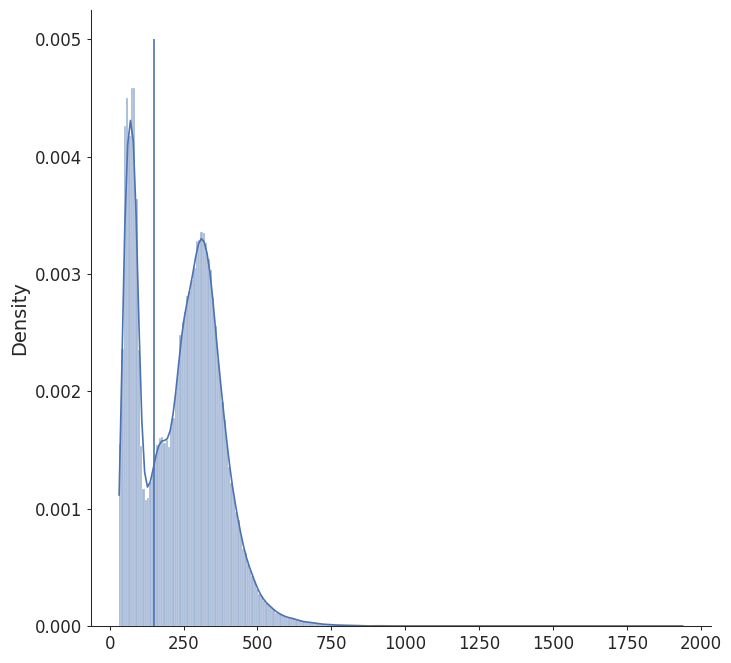

In [76]:
fig, ax = plt.subplots(figsize=(8,8))

sns.histplot(nucleus_table['volume'].values,ax=ax,kde=True,alpha=0.5,stat='density')
ax.vlines(volume_thresh,0,0.005)

0.0
0.0
0.0
0.0
0.0
0.0


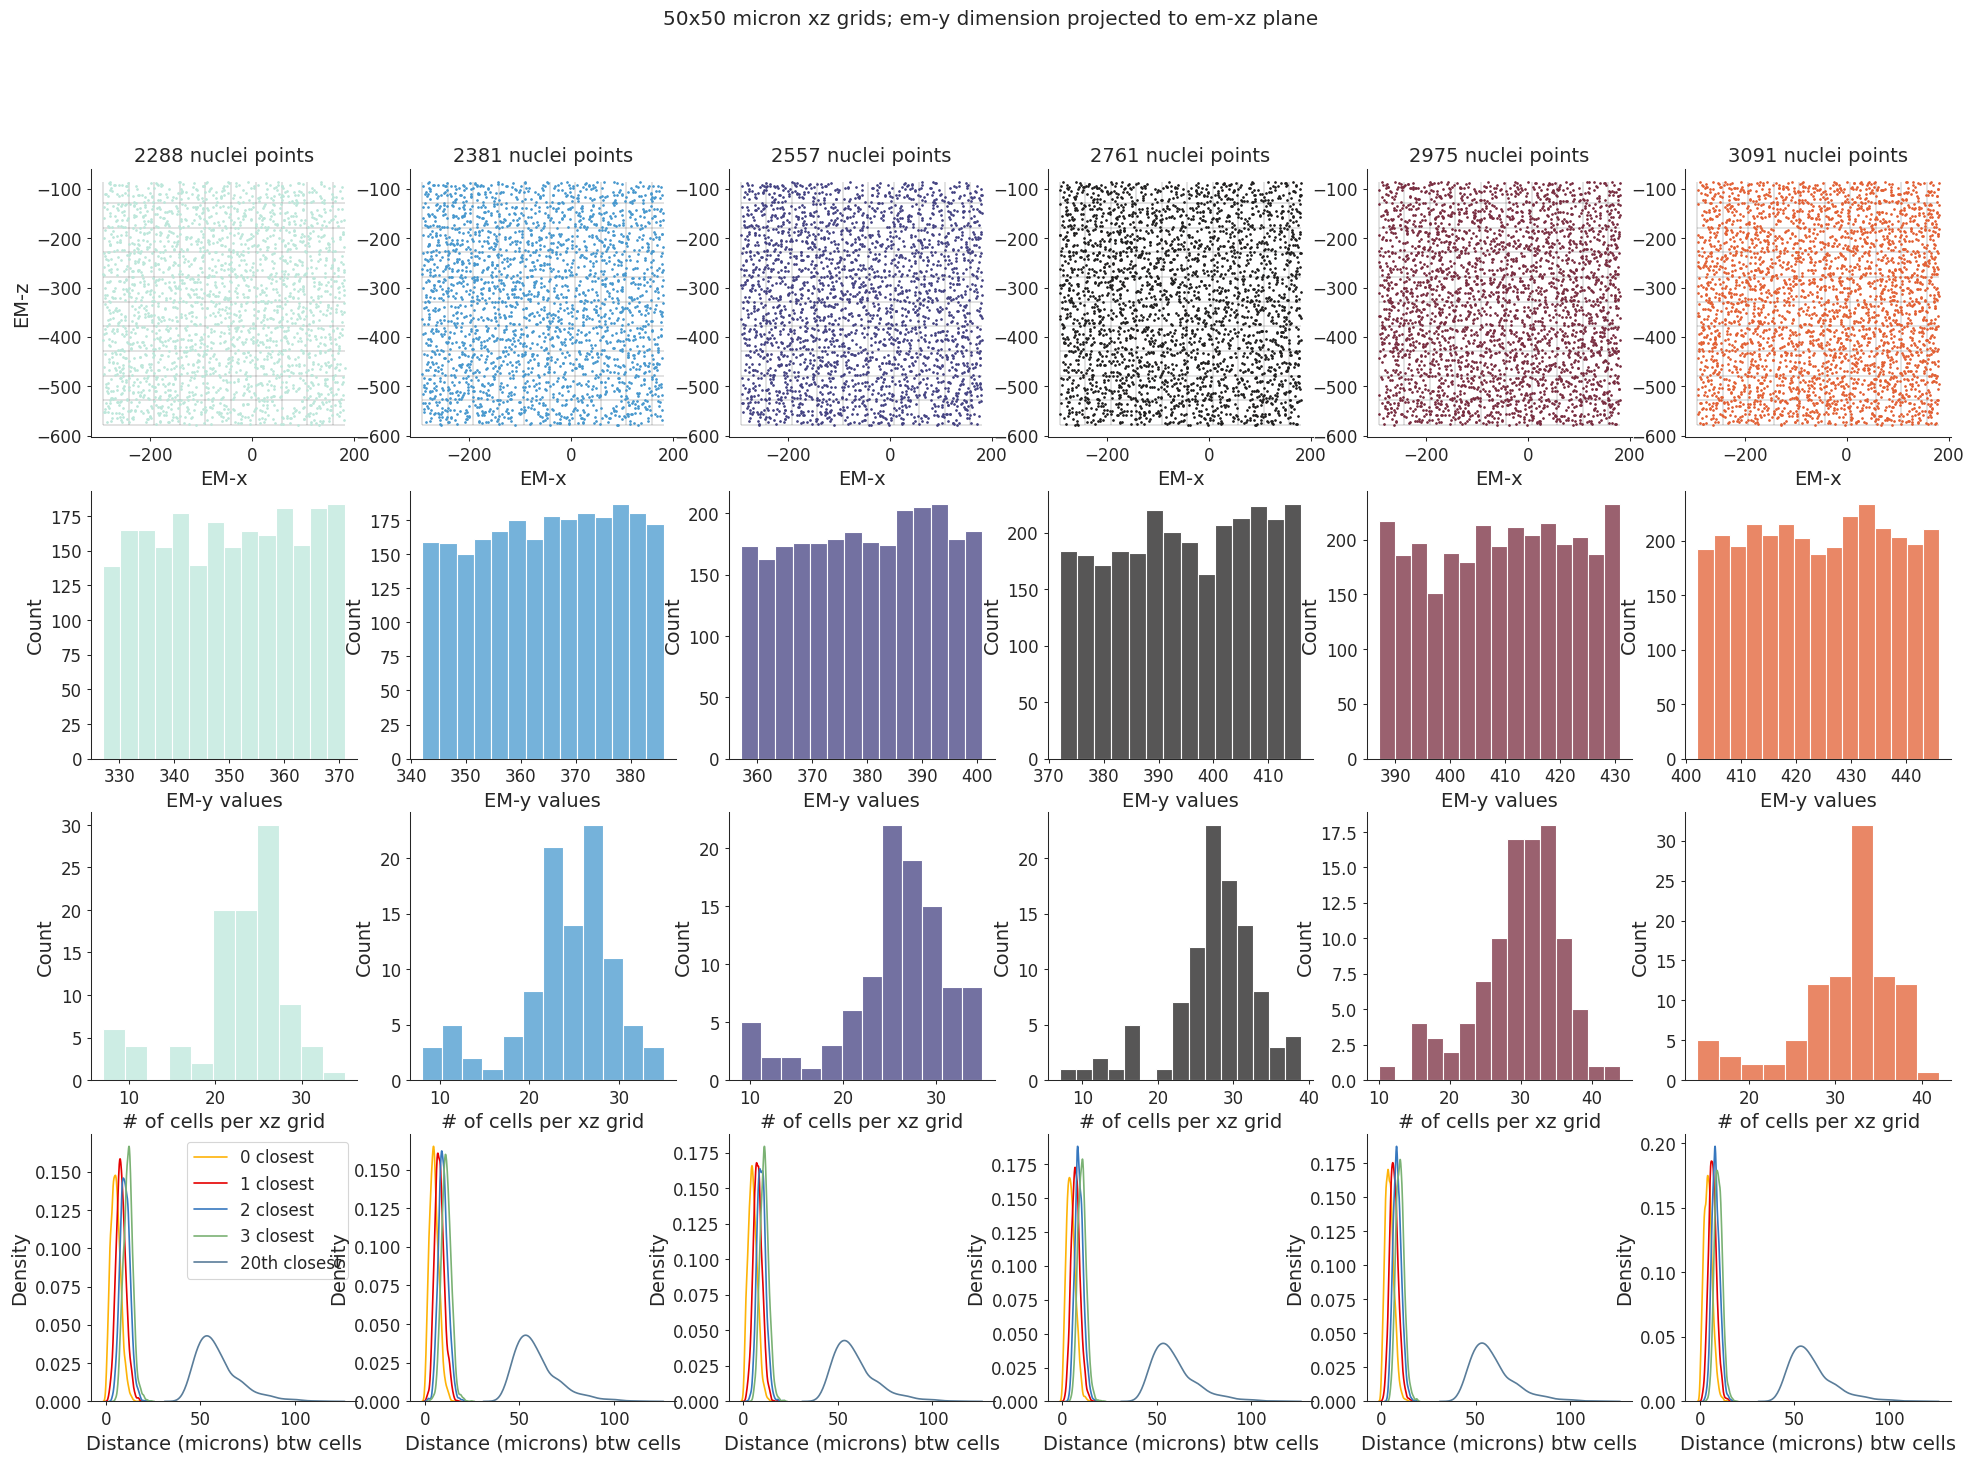

In [137]:

min_um = np.min(em_coreg,axis=0)
max_um = np.max(em_coreg,axis=0)

fig, axes = plt.subplots(4,6,figsize=(24,16))
plt.suptitle(f'{grid_size}x{grid_size} micron xz grids; em-y dimension projected to em-xz plane')
d20_list_em = []; first_closest_em = []; nuc_vols = []
#Loop over ophys planes
for iPlane in range(6):
    
    #Create query box of potential EM objects this ophys data could be coregistered to
    min_um2 = min_um.copy(); 
    min_um2 = min_um2 - buffer
    min_um2[1] = (em_y_guesses[iPlane] - 22)

    max_um2 = max_um.copy()
    max_um2 = max_um2 + buffer
    max_um2[1] = (em_y_guesses[iPlane] + 22)
    
    #Get all cells in EM volume within bounding region
    indy = np.all(nucleus_points_microns > min_um2,axis=1) & np.all(nucleus_points_microns < max_um2,axis=1)
    nucleus_points_sub = nucleus_points_microns[indy]
    em_xz = nucleus_points_sub[:,[0,2]]
    em_y = nucleus_points_sub[:,1]
    nucleus_ids_sub = nucleus_ids[indy]
        
    # #Get 2p cells in this plane
    # indy = np.where(func_roi_centers[:,2] == iPlane)[0]
    # func_roi_in_plane = func_roi_centers[indy]
    # print(f'Ophys plane {iPlane+1} -> Ophys neurons: {len(indy)}, EM pts: {len(nucleus_pts)}')
    #Subselect
    nucleus_ids_sub = nucleus_ids[indy]
    nucleus_vols_sub = nucleus_vols[indy]
    
    #Create KD-tree for easy searching 
    kdt_em = KDTree(em_xz)
    
    #How many cells are within a 32x32 micron grid across xz plane? 
    grid_size = 50
    em_volume_um = max_um2 - min_um2
    grid_cellnum = np.round(em_volume_um/grid_size)


    grid_boundaries = [np.arange(min_um2[0],max_um2[0],grid_size),np.arange(min_um2[2],max_um2[2],grid_size)]
    nCells_per_grid = np.zeros([len(g) for g in grid_boundaries])

    coreg_dict = {}
    for iX, x_bound in enumerate(grid_boundaries[0]):
        for iZ, z_bound in enumerate(grid_boundaries[1]):
            
            #Get grid boundaries and center
            grid_xz_min = np.array([x_bound,z_bound])
            grid_xz_max = grid_xz_min + grid_size
            grid_xz_ctr = grid_xz_min + grid_size/2

            #Use center to query em table
            distances, indices = kdt_em.query(grid_xz_ctr, k=100)
            
            #Of these 100 points, how many are within the grid volume?
            nPts = np.sum((np.all(em_xz[indices] >= grid_xz_min,axis=1)) & (np.all(em_xz[indices] < grid_xz_max,axis=1)))
            nCells_per_grid[iX,iZ] = nPts
            # pdb.set_trace()
            # if nPts > 0:
            #     indy = indices[(np.all(nucleus_pts[indices] >= grid_xyz_min,axis=1)) & (np.all(nucleus_pts[indices] < grid_xyz_max,axis=1))]
            #     nucleus_ids_in_grid = nucleus_ids[indy]
            
            #Use center to query em table
            distances, indices = kdt_em.query(grid_xz_ctr, k=100)
            
            #Of these points, how many are within the grid volume?
            indy = indices[(np.all(em_xz[indices] >= grid_xz_min,axis=1)) & (np.all(em_xz[indices] < grid_xz_max,axis=1))]

            # nucleus_ids_in_grid = nucleus_ids_sub[indy]
            # nucleus_pts_in_grid = em_xz[indy]
            nucleus_vols_in_grid = nucleus_vols_sub[indy]
            sub_indy = np.argsort(nucleus_vols_sub[indy])[::-1]
            indy10 = indy[sub_indy][:10]
            
            tmp = np.zeros((10,))
            tmp[:len(indy10)] = nucleus_vols_sub[indy10]
            nuc_vols.append(tmp)
            
    
    ax = axes[0,iPlane]; ax.set_title(f'{len(em_xz)} nuclei points')
    ax.scatter(em_xz[:,0],em_xz[:,1],color=cc(iPlane/6),marker='.',s=5) #c=em_y,cmap='viridis'
    # ax.axis('off')
    # ax.hlines(np.median(em_y),650,1100,color='k',ls='-',zorder=0)
    ax.hlines(grid_boundaries[1],min_um2[0],max_um2[0],color='k',ls='-',zorder=0,alpha=0.15)
    ax.vlines(grid_boundaries[0],min_um2[2],max_um2[2],color='k',ls='-',zorder=0,alpha=0.15)
    ax.set_xlabel('EM-x')
    if iPlane == 0:
        ax.set_ylabel('EM-z')

    ax = axes[1,iPlane]
    sns.histplot(em_y,color=cc(iPlane/6),ax=ax)
    ax.set_xlabel('EM-y values')
    
    ax = axes[2,iPlane]
    sns.histplot(nCells_per_grid.ravel(),color=cc(iPlane/6),ax=ax)
    ax.set_xlabel('# of cells per xz grid')
    print(np.sum(nCells_per_grid.ravel()) - len(em_xz))
    
    
    #Create KDTree for easy searching
    kdt_em = KDTree(em_xz)
    
    dist_list = []; 
    #Loop over cells and create hashes with each cell
    for pt_xz in em_xz:
        
        #Look at the 20 closest cells in the plane and create quads out of them
        distances, indices = kdt_em.query(pt_xz, k=101)
        dist_list.append(distances[1:5])
        d20_list_em.append(distances[-1])
        first_closest_em.append(distances[5])
    distances = np.array(dist_list)
    distances_per_plane.append(distances)
    ax = axes[3,iPlane]
    for i in range(4):
        # sns.histplot(distances[:,i],ax=ax,color=color_palette[i],label=f'{i} closest')
        sns.kdeplot(distances[:,i],ax=ax,color=color_palette[i],label=f'{i} closest')
    sns.kdeplot(d20_list,ax=ax,color=color_palette[6],label='20th closest')
    if iPlane == 0:
        ax.legend()
    ax.set_xlabel('Distance (microns) btw cells')
    
    # print(em_volume_nm/scalar,'microns')
    # print('# of grids per dimension: ',grid_cellnum)
    ## Create hashes of EM data in X-Z plane 
    
    # fig, axes = plt.subplots(1,2,figsize=(24,12))
    # ax = axes[0]
    # ax.scatter(nucleus_pts[:,0]/scalar,nucleus_pts[:,2]/scalar,c=nucleus_pts[:,1],cmap='viridis')
    # ax.set_xlabel('EM-x'); ax.set_ylabel('EM-z')
    # ax = axes[1]
    # ax.scatter(func_roi_in_plane[:,0]/512,func_roi_in_plane[:,1]/512,c='k')
    # ax.set_xlabel('Ophys-x'); ax.set_ylabel('Ophys-y')
    
    
    

1st closest: mean: 13.45923888059753, range: [2.5337634931703312,38.77829329387099]
1st closestem: mean: 12.102902251541346, range: [4.326252428907322,25.092490344684478]
20th closest mean: 59.267590105643215, range: [38.85791687216374,118.5518658939807]
100th closest mean: 56.721745294498, range: [44.38413218202132,115.4380945590182]


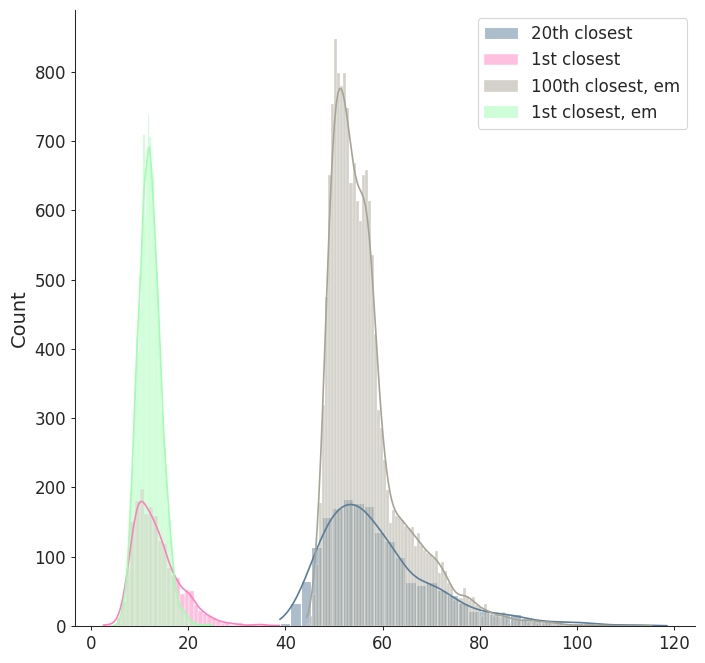

In [125]:
fig, ax = plt.subplots(figsize=(8,8))

sns.histplot(d20_list,ax=ax,color=color_palette[6],kde=True,label=f'20th closest')
sns.histplot(first_closest,ax=ax,color=color_palette[7],kde=True,label=f'1st closest')

sns.histplot(d20_list_em,ax=ax,color=color_palette[8],kde=True,label=f'100th closest, em')
sns.histplot(first_closest_em,ax=ax,color=color_palette[9],kde=True,label=f'1st closest, em')

print(f'1st closest: mean: {np.mean(first_closest)}, range: [{np.min(first_closest)},{np.max(first_closest)}]')
print(f'1st closestem: mean: {np.mean(first_closest_em)}, range: [{np.min(first_closest_em)},{np.max(first_closest_em)}]')
print(f'20th closest mean: {np.mean(d20_list)}, range: [{np.min(d20_list)},{np.max(d20_list)}]')
print(f'100th closest mean: {np.mean(d20_list_em)}, range: [{np.min(d20_list_em)},{np.max(d20_list_em)}]')
ax.legend()

In [54]:
min_um = np.min(em_coreg,axis=0)
max_um = np.max(em_coreg,axis=0)

buffer_um = 50
buffer = np.array((buffer_um, buffer_um, buffer_um))

In [55]:


iPlane = 0
print(f'Building hashes for ophys plane {iPlane+1}')

plane_buff = 22
#Create query box of potential EM objects this ophys data could be coregistered to
min_um2 = min_um.copy(); 
min_um2 = min_um2 - buffer
min_um2[1] = (em_y_guesses[iPlane] - plane_buff)

max_um2 = max_um.copy()
max_um2 = max_um2 + buffer
max_um2[1] = (em_y_guesses[iPlane] + plane_buff)

#Get all cells in EM volume within bounding region
indy = np.all(nucleus_points_microns > min_um2,axis=1) & np.all(nucleus_points_microns < max_um2,axis=1)
nucleus_points_sub = nucleus_points_microns[indy]
em_xz = nucleus_points_sub[:,[0,2]]
em_y = nucleus_points_sub[:,1]
nucleus_ids_sub = nucleus_ids[indy]
    
#Create KDTree for easy searching
kdt_em = KDTree(em_xz)

Building hashes for ophys plane 1


Building em hashes for ophys plane 1
	2288 rois in plane, 98836 hashes created
Building em hashes for ophys plane 2
	2381 rois in plane, 99679 hashes created
Building em hashes for ophys plane 3
	2557 rois in plane, 99778 hashes created
Building em hashes for ophys plane 4
	2761 rois in plane, 99668 hashes created
Building em hashes for ophys plane 5
	2975 rois in plane, 99941 hashes created
Building em hashes for ophys plane 6
	3091 rois in plane, 99957 hashes created


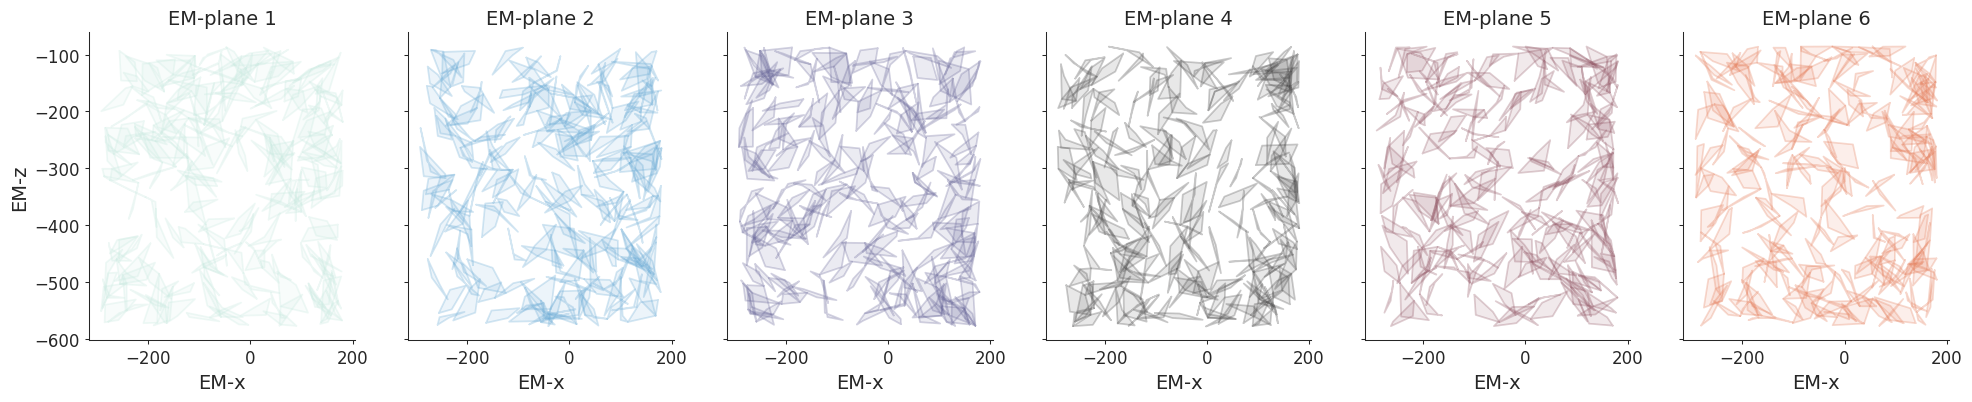

In [56]:
fig, axes = plt.subplots(1,6,figsize=(24,4),sharey=True)
hash_dict_em = {}
failed = 0

em_logbook = []
plane0 = 349
em_y_guesses = [plane0 + 15*i for i in range(6)]
plane_buff = 22
# #Loop over ophys planes
for iPlane in range(6):
# iPlane = 0
    print(f'Building em hashes for ophys plane {iPlane+1}')

    #Create query box of potential EM objects this ophys data could be coregistered to
    min_um2 = min_um.copy(); 
    min_um2 = min_um2 - buffer
    min_um2[1] = (em_y_guesses[iPlane] - plane_buff)

    max_um2 = max_um.copy()
    max_um2 = max_um2 + buffer
    max_um2[1] = (em_y_guesses[iPlane] + plane_buff)

    #Tile xz plane with grid
    grid_size = 50
    grid_boundaries = [np.arange(min_um2[0],max_um2[0],grid_size),np.arange(min_um2[2],max_um2[2],grid_size)]
    nCells_per_grid = np.zeros([len(g) for g in grid_boundaries])

    #Get all cells in EM volume within bounding region
    indy = np.all(nucleus_points_microns > min_um2,axis=1) & np.all(nucleus_points_microns < max_um2,axis=1)
    em_xyz = nucleus_points_microns[indy]; em_xz = em_xyz[:,[0,2]]; em_y = em_xyz[:,1]
    nPts = len(em_xz)
    
    #Subselect
    nucleus_ids_sub = nucleus_ids[indy]
    nucleus_vols_sub = nucleus_vols[indy]
        
    #Create KDTree for easy searching
    kdt_em = KDTree(em_xz)
    
    hash_list = []; stars_used = np.zeros((nPts)); em_vols = []
    #Loop over grid & attempt to build a quad in each one, a number of times
    for iX, x_bound in enumerate(grid_boundaries[0]):
        for iZ, z_bound in enumerate(grid_boundaries[1]):
            
            #Get grid boundaries and center
            grid_xz_min = np.array([x_bound,z_bound])
            grid_xz_max = grid_xz_min + grid_size
            grid_xz_ctr = grid_xz_min + grid_size/2

            #Use center to query em table
            distances, indices = kdt_em.query(grid_xz_ctr, k=100)
            
            #Of these points, how many are within the grid volume?
            indy = indices[(np.all(em_xz[indices] >= grid_xz_min,axis=1)) & (np.all(em_xz[indices] < grid_xz_max,axis=1))]

            # nucleus_ids_in_grid = nucleus_ids_sub[indy]
            # nucleus_pts_in_grid = em_xz[indy]
            nucleus_vols_in_grid = nucleus_vols_sub[indy]
            sub_indy = np.argsort(nucleus_vols_sub[indy])[::-1]
            indy10 = indy[sub_indy][:10]

            # indy10 = np.random.choice(indy,10,replace=False)

            for iCell1 in indy10:

                iter = 0
                hash_building = True; hashes_built = 0; quad_list = []
                while hash_building:
                    
                    distances, indices = kdt_em.query(em_xz[iCell1], k=101)
                    indy3 = np.random.choice(indices[1:],3,replace=False)
                    indy4 = np.concatenate(([iCell1],indy3))

                    #Get quad xy
                    quad_em = em_xz[indy4]

                    #Calculate hash from 4 points
                    hash_em, i_abcd, error = calculate_hash(quad_em)
                    quad_indy = indy4[i_abcd]
                    quad_em = em_xz[quad_indy]
                
                    #Check to quad was successfully created
                    iter += 1
                    if error == 1:
                        failed += 1
                        if iter > 5000:
                            hash_building = False
                        continue
                    
                    if iter > 5000:
                        hash_building = False
                        
                    #AB, AC, AD, BC, BD
                    AB = np.linalg.norm(quad_em[0]-quad_em[1])
                    AC = np.linalg.norm(quad_em[0]-quad_em[2])
                    AD = np.linalg.norm(quad_em[0]-quad_em[3])
                    BC = np.linalg.norm(quad_em[1]-quad_em[2])
                    BD = np.linalg.norm(quad_em[1]-quad_em[3])
                    
                    #Check size
                    if (AB < grid_size) | (AB > 2*grid_size):
                        continue
                    # if (AC < AC_min) | (AD < AD_min) | (BC < BC_min) | (BD < BD_min):
                    #     continue

                    #Check if hash has already been created
                    for q in quad_list:
                        if np.all(q-quad_em == 0):
                            continue
                    quad_list.append(quad_em)
                
                    for i in quad_indy:
                        stars_used[i] += 1

                    #Save quad
                    hash_list.append({'nucleus_ids': nucleus_ids_sub[quad_indy], 
                                    'em_xz': em_xz[quad_indy],
                                    'em_y': em_y[quad_indy],
                                    'hash': hash_em,
                                    'plane': iPlane,
                                    'center': np.mean(quad_em,axis=0),
                                    'volumes': nucleus_vols_sub[quad_indy],
                                    'AB': AB})

                    hashes_built += 1
                    if hashes_built == 100:
                        hash_building = False
            
    em_logbook.append(stars_used)
    print(f'\t{nPts} rois in plane, {len(hash_list)} hashes created')   
    #Save hashes for this plane
    hash_dict_em[iPlane] = hash_list           

    #Plot hashes
    ax = axes[iPlane]; ax.set_title(f'EM-plane {iPlane+1}')
    # ax.scatter(em_xz[:,0],em_xz[:,1],color='k',marker='.',s=20,zorder=2)
    ax.set_xlabel('EM-x')
    if iPlane == 0:
        ax.set_ylabel('EM-z')

    plot_indices = np.random.choice(np.arange(len(hash_list)),200,replace=False)
    for index in plot_indices:
        hash = hash_list[index]['hash']
        quad_xy =  hash_list[index]['em_xz']
        i_a = 0; i_b = 1; i_c = 2; i_d = 3
        # plot_quad(quad_xy,ax=ax,polygon_c=cc(iPlane/6))
        ax.plot(quad_xy[np.array([i_a,i_d,i_b,i_c,i_a]),0],quad_xy[np.array([i_a,i_d,i_b,i_c,i_a]),1],color=cc(iPlane/6),alpha=0.25,zorder=1)
        poly = Polygon(quad_xy[np.array([i_a,i_d,i_b,i_c])], facecolor=cc(iPlane/6), alpha=0.1)
        ax.add_patch(poly)     


In [32]:
all_hashes = []
for iP in range(6):
    all_hashes.extend(hash_dict_em[iP])

# all_hashes = hash_dict[0]
## Let's try to search for hashes 
volumes = np.array([t['volumes'] for t in all_hashes])
volumes.shape

(596389, 4)

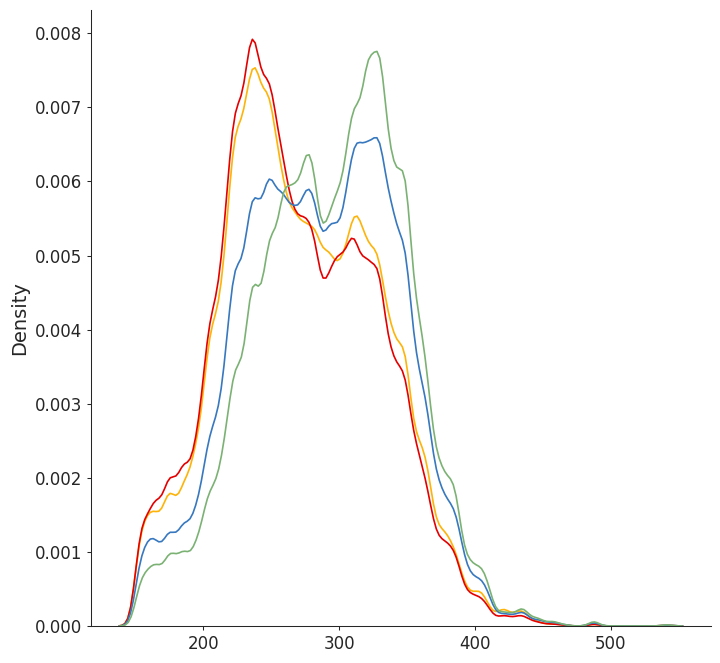

In [33]:
fig, ax = plt.subplots(figsize=(8,8))

for i in range(4):
    sns.kdeplot(volumes[:,i],ax=ax,color=color_palette[i])
# ax.set_xlabel("# of times em point used in quad")

Text(0.5, 0, '# of times em point used in quad')

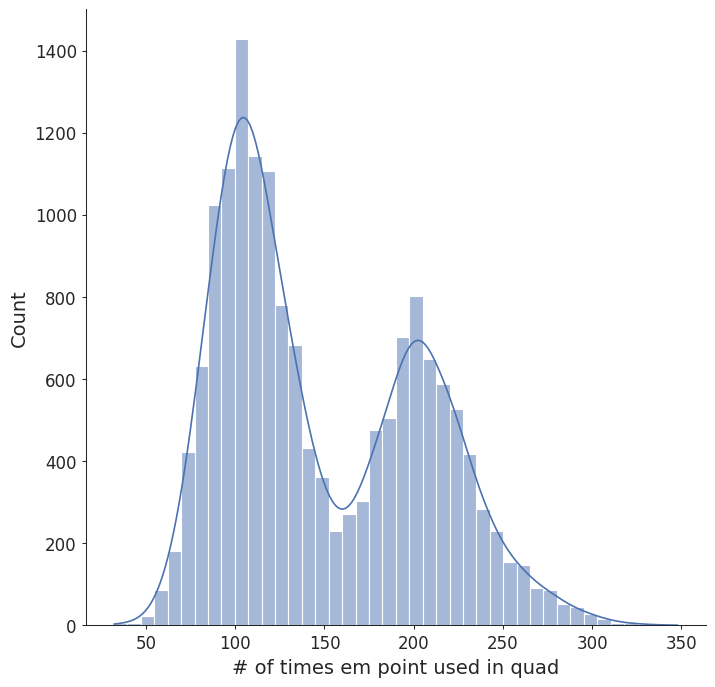

In [58]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(np.concatenate(em_logbook),ax=ax,kde=True)
ax.set_xlabel("# of times em point used in quad")

Building em hashes for ophys plane 1


KeyboardInterrupt: 

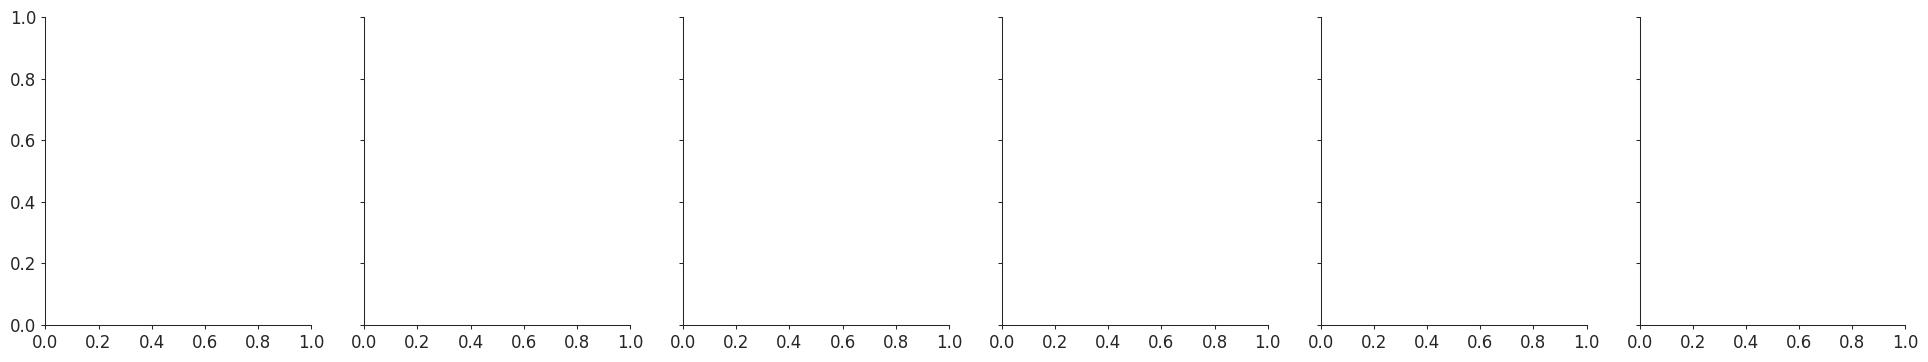

In [145]:
fig, axes = plt.subplots(1,6,figsize=(24,4),sharey=True)
hash_dict_em = {}
failed = 0

em_logbook = []
plane0 = 349
em_y_guesses = [plane0 + 15*i for i in range(6)]
plane_buff = 22
# #Loop over ophys planes
for iPlane in range(6):
# iPlane = 0
    print(f'Building em hashes for ophys plane {iPlane+1}')

    #Create query box of potential EM objects this ophys data could be coregistered to
    min_um2 = min_um.copy(); 
    min_um2 = min_um2 - buffer
    min_um2[1] = (em_y_guesses[iPlane] - plane_buff)

    max_um2 = max_um.copy()
    max_um2 = max_um2 + buffer
    max_um2[1] = (em_y_guesses[iPlane] + plane_buff)

    #Tile xz plane with grid
    grid_size = 50
    grid_boundaries = [np.arange(min_um2[0],max_um2[0],grid_size),np.arange(min_um2[2],max_um2[2],grid_size)]
    nCells_per_grid = np.zeros([len(g) for g in grid_boundaries])

    #Get all cells in EM volume within bounding region
    indy = np.all(nucleus_points_microns > min_um2,axis=1) & np.all(nucleus_points_microns < max_um2,axis=1)
    em_xyz = nucleus_points_microns[indy]; em_xz = em_xyz[:,[0,2]]; em_y = em_xyz[:,1]
    nPts = len(em_xz)
    
    #Subselect
    nucleus_ids_sub = nucleus_ids[indy]
    nucleus_vols_sub = nucleus_vols[indy]
        
    #Create KDTree for easy searching
    kdt_em = KDTree(em_xz)
    
    hash_list = []; stars_used = np.zeros((nPts)); em_vols = []
    #Loop over grid & attempt to build a quad in each one, a number of times
    for iX, x_bound in enumerate(grid_boundaries[0]):
        for iZ, z_bound in enumerate(grid_boundaries[1]):
            
            #Get grid boundaries and center
            grid_xz_min = np.array([x_bound,z_bound])
            grid_xz_max = grid_xz_min + grid_size
            grid_xz_ctr = grid_xz_min + grid_size/2

            #Use center to query em table
            distances, indices = kdt_em.query(grid_xz_ctr, k=100)
            
            #Of these points, how many are within the grid volume?
            indy = indices[(np.all(em_xz[indices] >= grid_xz_min,axis=1)) & (np.all(em_xz[indices] < grid_xz_max,axis=1))]

            # nucleus_ids_in_grid = nucleus_ids_sub[indy]
            # nucleus_pts_in_grid = em_xz[indy]
            nucleus_vols_in_grid = nucleus_vols_sub[indy]
            sub_indy = np.argsort(nucleus_vols_sub[indy])[::-1]
            indy10 = indy[sub_indy][:3]

            # indy10 = np.random.choice(indy,10,replace=False)

            for iCell1 in indy10:

                #Look at the 101 closest cells in the plane and create quads out of them
                distances, indices = kdt_em.query(em_xz[iCell1], k=100)
                
                all_combos = list(combinations(indices[5:], 3))
                # pdb.set_trace()
                #Loop through 20 closest cells, creating hashes with each possible set of 4
                for indy3 in all_combos:
                    indy4 = np.concatenate(([indices[0]],indy3))
                
                    #Get quad xy
                    quad_em = em_xz[indy4]

                    #Calculate hash from 4 points
                    hash_em, i_abcd, error = calculate_hash(quad_em)
                    quad_indy = indy4[i_abcd]
                    quad_em = em_xz[quad_indy]
                
                    #Check to quad was successfully created
                    iter += 1
                    if error == 1:
                        failed += 1
                        continue
                        
                    #AB, AC, AD, BC, BD
                    AB = np.linalg.norm(quad_em[0]-quad_em[1])
                    AC = np.linalg.norm(quad_em[0]-quad_em[2])
                    AD = np.linalg.norm(quad_em[0]-quad_em[3])
                    BC = np.linalg.norm(quad_em[1]-quad_em[2])
                    BD = np.linalg.norm(quad_em[1]-quad_em[3])
                    
                    # #Check size
                    # if (AB < grid_size) | (AB > 2*grid_size):
                    #     continue
                    # if (AC < AC_min) | (AD < AD_min) | (BC < BC_min) | (BD < BD_min):
                    #     continue
                    
                    indy_list.append(quad_indy)
                    #Save quad
                    hash_list.append({'nucleus_ids': nucleus_ids_sub[quad_indy], 
                                    'em_xz': em_xz[quad_indy],
                                    'em_y': em_y[quad_indy],
                                    'hash': hash_em,
                                    'plane': iPlane,
                                    'center': np.mean(quad_em,axis=0),
                                    'volumes': nucleus_vols_sub[quad_indy],
                                    'AB': AB})
    
    #Remove duplicate quads
    _, indices = np.unique(indy_list,axis=0,return_index=True)
    hash_list_uniq = []
    for ii, hash in enumerate(hash_list):
        if ii in indices:
            hash_list_uniq.append(hash)
            quad_indy = indy_list[ii]
            for jj in quad_indy:
                stars_used[jj] += 1
    
    em_logbook.append(stars_used)
    print(f'\t{nPts} rois in plane, {len(hash_list_uniq)} hashes created')   
    pdb.set_trace()
    #Save hashes for this plane
    hash_dict_em[iPlane] = hash_list           

    #Plot hashes
    ax = axes[iPlane]; ax.set_title(f'EM-plane {iPlane+1}')
    # ax.scatter(em_xz[:,0],em_xz[:,1],color='k',marker='.',s=20,zorder=2)
    ax.set_xlabel('EM-x')
    if iPlane == 0:
        ax.set_ylabel('EM-z')

    plot_indices = np.random.choice(np.arange(len(hash_list)),200,replace=False)
    for index in plot_indices:
        hash = hash_list[index]['hash']
        quad_xy =  hash_list[index]['em_xz']
        i_a = 0; i_b = 1; i_c = 2; i_d = 3
        # plot_quad(quad_xy,ax=ax,polygon_c=cc(iPlane/6))
        ax.plot(quad_xy[np.array([i_a,i_d,i_b,i_c,i_a]),0],quad_xy[np.array([i_a,i_d,i_b,i_c,i_a]),1],color=cc(iPlane/6),alpha=0.25,zorder=1)
        poly = Polygon(quad_xy[np.array([i_a,i_d,i_b,i_c])], facecolor=cc(iPlane/6), alpha=0.1)
        ax.add_patch(poly)     


In [151]:
ii

1951476

In [153]:
#Remove duplicate quads
_, indices = np.unique(indy_list,axis=0,return_index=True)
hash_list_uniq = [];# stars_used = np.zeros((nPts))
for ii, hash in enumerate(tqdm(hash_list)):
    if ii in indices:
        hash_list_uniq.append(hash)
        # quad_indy = indy_list[ii]
        # for jj in quad_indy:
        #     stars_used[jj] += 1

  0%|          | 0/3306147 [00:00<?, ?it/s]

In [154]:
hash_dict_em2 = {}
hash_dict_em2[iPlane] = hash_list_uniq

In [143]:
cc  = sns.color_palette("icefire", as_cmap=True)
cc2  = sns.color_palette("Spectral", as_cmap=True)
pix_size = 0.77

fig, axes = plt.subplots(1,6,figsize=(24,4),sharey=True)

failed = 0
star_logbook = []
hash_dict2 = {}
#Loop over ophys planes
for iPlane in range(6):
    print(f'Building hashes for ophys plane {iPlane+1}')
    
    #Get 2p cells in this plane
    indy = np.where(func_roi_centers[:,2] == iPlane)[0]
    func_roi_xy_in_plane = func_roi_centers[indy,:2]
    roi_names_in_plane = func_roi_names[indy]
    roi_areas_in_plane = func_roi_areas[indy]
    nCells = len(func_roi_xy_in_plane)

    #Create KDTree for easy searching
    kdt_2p = KDTree(func_roi_xy_in_plane)

    hash_list = []; stars_used = np.zeros((len(func_roi_xy_in_plane)))
    indy_list = []
    #Loop over cells and create hashes with each cell
    for iRoi, roi_xy in enumerate(func_roi_xy_in_plane):
        
        #Look at the 20 closest cells in the plane and create quads out of them
        distances, indices = kdt_2p.query(roi_xy, k=21)
        hash_building = True; iter = 0; hashes_built = 0
        
        all_combos = list(combinations(indices[1:], 3))
        #Loop through 20 closest cells, creating hashes with each possible set of 4
        for indy3 in all_combos:
            indy4 = np.concatenate(([indices[0]],indy3))
            
            #Get quad xy
            quad_2p = func_roi_xy_in_plane[indy4]
                        
            #Calculate hash from 4 points
            hash_2p, i_abcd, error = calculate_hash(quad_2p)
            quad_indy = indy4[i_abcd]
            ophys_xy = func_roi_xy_in_plane[quad_indy]

            #Check to quad was successfully created
            if (error == 1):
                failed += 1
                continue
    
            AB = np.linalg.norm(ophys_xy[0] - ophys_xy[1])*pix_size
            AC = np.linalg.norm(ophys_xy[0]-ophys_xy[2])*pix_size
            AD = np.linalg.norm(ophys_xy[0]-ophys_xy[3])*pix_size
            BC = np.linalg.norm(ophys_xy[1]-ophys_xy[2])*pix_size
            BD = np.linalg.norm(ophys_xy[1]-ophys_xy[3])*pix_size

            # #Check scale
            # if (AB < grid_size_em) | (AB > 2*grid_size_em):
            #     continue
            
            # if (AC < AC_min) | (AD < AD_min) | (BC < BC_min) | (BD < BD_min):
            #     continue
            
            indy_list.append(quad_indy)
            #Save quad
            hash_list.append({'rois': roi_names_in_plane[quad_indy], 
                            'ophys_xy': ophys_xy,
                            'hash': hash_2p,
                            'plane': iPlane,
                            'center': np.mean(ophys_xy,axis=0),
                            'index': iRoi,
                            'AB': AB})
                            
    #Remove duplicate quads
    _, indices = np.unique(indy_list,axis=0,return_index=True)
    hash_list_uniq = []
    for ii, hash in enumerate(hash_list):
        if ii in indices:
            hash_list_uniq.append(hash)
            quad_indy = indy_list[ii]
            for jj in quad_indy:
                stars_used[jj] += 1
                
    star_logbook.append(stars_used)
    print(f'\t{nCells} rois in plane, {len(hash_list_uniq)} hashes created')   
    
    #Save hashes for this plane
    hash_dict2[iPlane] = hash_list_uniq           
    
    #Plot hashes
    ax = axes[iPlane]; ax.set_title(f'Ophys-plane {iPlane+1}')
    ax.scatter(func_roi_xy_in_plane[:,0],func_roi_xy_in_plane[:,1],color='k',marker='.',s=20,zorder=2)

    ax.set_xlabel('Ophys-x')
    if iPlane == 0:
        ax.set_ylabel('Ophys-y')

    hash_index = np.array([t['index'] for t in hash_list])
    for iRoi in range(nCells):
        indy = np.where(hash_index == iRoi)[0]
        if len(indy) == 0:
            continue
        for ii in np.random.choice(indy,2):
            roi_xy = hash_list[ii]['ophys_xy']
            i_a = 0; i_b = 1; i_c = 2; i_d = 3
            ax.plot(roi_xy[np.array([i_a,i_d,i_b,i_c,i_a]),0],roi_xy[np.array([i_a,i_d,i_b,i_c,i_a]),1],color='k',alpha=0.25,zorder=1)
            poly = Polygon(roi_xy[np.array([i_a,i_d,i_b,i_c])], facecolor=cc(iPlane/6), alpha=0.1)
            ax.add_patch(poly)
    

1000

2p AB -> range: [21.9,167.1], mean: 83.6, std: 20.0
EM AB -> range: [18.5,163.7], mean: 82.6, std: 17.4
2p AC -> range: [6.6,143.3], mean: 34.3, std: 17.1
EM AC -> range: [0.1,152.9], mean: 33.9, std: 16.3
2p AD -> range: [7.1,144.3], mean: 41.6, std: 15.6
EM AD -> range: [1.4,153.1], mean: 40.8, std: 14.8
2p BC -> range: [7.3,143.0], mean: 55.8, std: 17.2
EM BC -> range: [1.4,156.8], mean: 55.5, std: 16.2
2p BD -> range: [6.6,155.7], mean: 45.6, std: 16.5
EM BD -> range: [0.1,154.6], mean: 45.5, std: 15.3


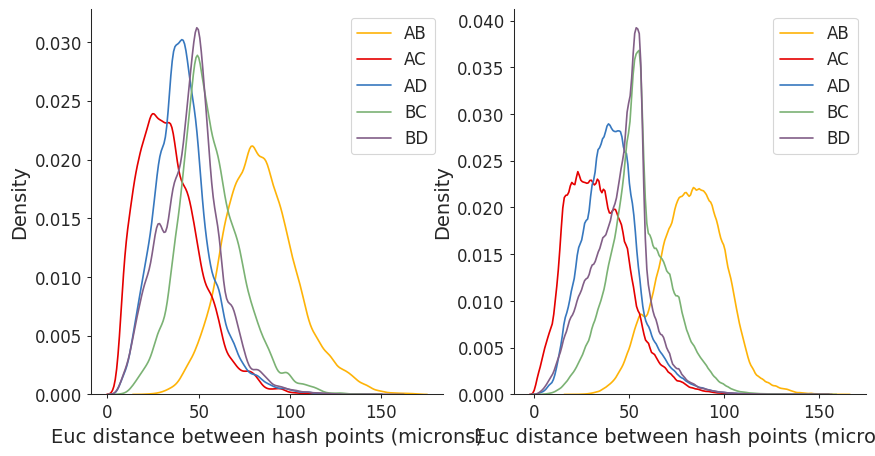

In [155]:
pix_size = 0.77
## What are the size of the query hashes? 
# # #Concatenate all hashes from each plane
# all_hashes = []
# for iP in range(6):
#     all_hashes.extend(hash_dict[iP])

all_hashes = hash_dict2[0]
## Let's try to search for hashes 
hashes = np.array([t['hash'] for t in all_hashes])
quad_xy = np.array([t['ophys_xy'] for t in all_hashes])
hash_planes = np.array([t['plane'] for t in all_hashes])
# sub_indices = np.array([t['sub_index'] for t in all_hashes])

# fig, axes = plt.subplots(3,6,figsize=(18,9),sharey=True,sharex=True)
# plt.suptitle('Hash sizes?',y=0.92)
lengths = []
# for iSub in range(18):
fig, axes = plt.subplots(1,2,figsize=(10,5))

ax = axes[0]

#Calculate distance between A-B, A-C, A-D, B-C, B-D
AB = []; BC = []; AC = []; AD = []; BC = []; BD = []
for quad in quad_xy:
    AB.append(np.linalg.norm(quad[0]-quad[1]))
    AC.append(np.linalg.norm(quad[0]-quad[2]))
    AD.append(np.linalg.norm(quad[0]-quad[3]))
    BC.append(np.linalg.norm(quad[1]-quad[2]))
    BD.append(np.linalg.norm(quad[1]-quad[3]))

sns.kdeplot(np.array(AB)*pix_size,ax=ax,color=color_palette[0],label='AB')
sns.kdeplot(np.array(AC)*pix_size,ax=ax,color=color_palette[1],label='AC')
sns.kdeplot(np.array(AD)*pix_size,ax=ax,color=color_palette[2],label='AD')
sns.kdeplot(np.array(BC)*pix_size,ax=ax,color=color_palette[3],label='BC')
sns.kdeplot(np.array(BD)*pix_size,ax=ax,color=color_palette[4],label='BD')

lengths.append((np.mean(np.array(AB)*pix_size),np.mean(np.array(AC)*pix_size),np.mean(np.array(AD)*pix_size),np.mean(np.array(BC)*pix_size),np.mean(np.array(BD)*pix_size)))

ax.legend()
ax.set_xlabel('Euc distance between hash points (microns)')  



## What are the size of the query hashes? 
# # #Concatenate all hashes from each plane
# all_hashes = []
# for iP in range(6):
#     all_hashes.extend(hash_dict_em[iP])

all_hashes = hash_dict_em2[0]
## Let's try to search for hashes 
hashes = np.array([t['hash'] for t in all_hashes])
quad_xz = np.array([t['em_xz'] for t in all_hashes])
hash_planes = np.array([t['plane'] for t in all_hashes])
# sub_indices = np.array([t['sub_index'] for t in all_hashes])
ax = axes[1]

#Calculate distance between A-B, A-C, A-D, B-C, B-D
AB2 = []; BC2 = []; AC2 = []; AD2 = []; BC2 = []; BD2 = []
for quad in quad_xz:
    AB2.append(np.linalg.norm(quad[0]-quad[1]))
    AC2.append(np.linalg.norm(quad[0]-quad[2]))
    AD2.append(np.linalg.norm(quad[0]-quad[3]))
    BC2.append(np.linalg.norm(quad[1]-quad[2]))
    BD2.append(np.linalg.norm(quad[1]-quad[3]))


sns.kdeplot(np.array(AB2),ax=ax,color=color_palette[0],label='AB')
sns.kdeplot(np.array(AC2),ax=ax,color=color_palette[1],label='AC')
sns.kdeplot(np.array(AD2),ax=ax,color=color_palette[2],label='AD')
sns.kdeplot(np.array(BC2),ax=ax,color=color_palette[3],label='BC')
sns.kdeplot(np.array(BD2),ax=ax,color=color_palette[4],label='BD')

lengths.append((np.mean(np.array(AB)*pix_size),np.mean(np.array(AC)*pix_size),np.mean(np.array(AD)*pix_size),np.mean(np.array(BC)*pix_size),np.mean(np.array(BD)*pix_size)))
ax.legend()
ax.set_xlabel('Euc distance between hash points (microns)')  


    
print(f'2p AB -> range: [{np.min(AB)*pix_size:.1f},{np.max(AB)*pix_size:.1f}], mean: {np.mean(AB)*pix_size:.1f}, std: {np.std(AB)*pix_size:.1f}')
print(f'EM AB -> range: [{np.min(AB2):.1f},{np.max(AB2):.1f}], mean: {np.mean(AB2):.1f}, std: {np.std(AB2):.1f}')

print(f'2p AC -> range: [{np.min(AC)*pix_size:.1f},{np.max(AC)*pix_size:.1f}], mean: {np.mean(AC)*pix_size:.1f}, std: {np.std(AC)*pix_size:.1f}')
print(f'EM AC -> range: [{np.min(AC2):.1f},{np.max(AC2):.1f}], mean: {np.mean(AC2):.1f}, std: {np.std(AC2):.1f}')

print(f'2p AD -> range: [{np.min(AD)*pix_size:.1f},{np.max(AD)*pix_size:.1f}], mean: {np.mean(AD)*pix_size:.1f}, std: {np.std(AD)*pix_size:.1f}')
print(f'EM AD -> range: [{np.min(AD2):.1f},{np.max(AD2):.1f}], mean: {np.mean(AD2):.1f}, std: {np.std(AD2):.1f}')

print(f'2p BC -> range: [{np.min(BC)*pix_size:.1f},{np.max(BC)*pix_size:.1f}], mean: {np.mean(BC)*pix_size:.1f}, std: {np.std(BC)*pix_size:.1f}')
print(f'EM BC -> range: [{np.min(BC2):.1f},{np.max(BC2):.1f}], mean: {np.mean(BC2):.1f}, std: {np.std(BC2):.1f}')

print(f'2p BD -> range: [{np.min(BD)*pix_size:.1f},{np.max(BD)*pix_size:.1f}], mean: {np.mean(BD)*pix_size:.1f}, std: {np.std(BD)*pix_size:.1f}')
print(f'EM BD -> range: [{np.min(BD2):.1f},{np.max(BD2):.1f}], mean: {np.mean(BD2):.1f}, std: {np.std(BD2):.1f}')

In [ ]:
AC_min = 10
AD_min = 15
BC_min = 20
BD_min = 15

In [ ]:
# pdfdoc = PdfPages(os.path.join(PlotDir,'hashes_em_per_2pcell.pdf'))
# fig, axes = plt.subplots(1,6,figsize=(24,4),sharey=True)

# hash_dict_em = {}
# # #Loop over ophys planes
# for iPlane in range(6):
# # iPlane = 0
#     print(f'Building hashes for ophys plane {iPlane+1}')

#     #Create query box of potential EM objects this ophys data could be coregistered to
#     min_um2 = min_um.copy(); 
#     min_um2 = min_um2 - buffer
#     min_um2[1] = (em_y_guesses[iPlane] - 22)

#     max_um2 = max_um.copy()
#     max_um2 = max_um2 + buffer
#     max_um2[1] = (em_y_guesses[iPlane] + 22)

#     #Get all cells in EM volume within bounding region
#     indy = np.all(nucleus_points_microns > min_um2,axis=1) & np.all(nucleus_points_microns < max_um2,axis=1)
#     em_xyz = nucleus_points_microns[indy]; em_xz = em_xyz[:,[0,2]]; em_y = em_xyz[:,1]
#     nucleus_ids_sub = nucleus_ids[indy]
        
#     #Create KDTree for easy searching
#     kdt_em = KDTree(em_xz)

#     hash_list = []
#     #Loop over cells and create hashes with each cell
#     for indy1, pt_xz in enumerate(em_xz):
        
#         #Look at the 100 closest nuclei pts in the xz plane and create quads out of them
#         distances, indices = kdt_em.query(pt_xz, k=750)
        
#         #Select nuclei points where the points are at least greater than 20 microns and less than 120 microns
#         indy = np.where((distances <  125))[0] #distances
#         distances = distances[indy]; indices = indices[indy]
        
#         hash_building = True; iter = 0; hashes_built = 0
        
#         #Sub-select 4 cells to create 10 different hashes
#         while hash_building:
#             indy3 = np.random.choice(indices,3,replace=False)
#             indy4 = np.concatenate(([indy1],indy3))
            
#             #Get quad xy
#             quad_xy = em_xz[indy4] #np.vstack((pt_xz.reshape(1,2),em_xz[indy3]))
            
#             #Define cells A & B
#             max = 0
#             for i in range(4):
#                 for j in range(4):
#                     dist = np.linalg.norm(quad_xy[j]-quad_xy[i])
#                     if dist > max:
#                         i_a = i; i_b = j
#                         max = dist
                        
#             A_xy = quad_xy[i_a]
#             B_xy = quad_xy[i_b]
            
#             #Calculate local coordinates
#             quad_xy_local =  (quad_xy - A_xy)/(B_xy - A_xy)
            
#             #Define C&D relative to the coordinate system defined by A-B
#             i_cd = np.setxor1d([i_a,i_b],np.arange(4))
        
#             #Break C/D symmetry by x_c <= x_d & x_c + x_d<=1
#             if quad_xy_local[i_cd][0,0] < quad_xy_local[i_cd][1,0]:
#                 i_c = i_cd[0]; i_d = i_cd[1]
#             else:
#                 i_c = i_cd[1]; i_d = i_cd[0]
                
#             #Create hash based on CD local coordinates
#             quad_hash = np.concatenate((quad_xy_local[i_c],quad_xy_local[i_d]))
            
#             iter += 1
#             #Check to make sure x_c + x_d is less than 1
#             if (quad_hash[0] + quad_hash[2]) >= 1:
#                 continue
#             elif iter > 500:
#                 hash_building = False
            
#             #Save quad
#             quad_indy = indy4[np.array([i_a,i_b,i_c,i_d])]
#             hash_list.append({'nucleus_ids': nucleus_points_sub[quad_indy], 
#                             'em_xz': em_xz[quad_indy],
#                             'em_y': em_y[quad_indy],
#                             'hash': quad_hash})
#             # pdb.set_trace()
            
#             #update counter
#             hashes_built += 1

#             if hashes_built == 5:
#                 hash_building = False
                
#     #Save hashes for this plane
#     hash_dict_em[iPlane] = hash_list
    
    
#     #Plot hashes
#     ax = axes[iPlane]; ax.set_title(f'Ophys-plane {iPlane+1}')
#     # ax.scatter(func_roi_xy_in_plane[:,0],func_roi_xy_in_plane[:,1],color=cc(iPlane/6),marker='.',s=20,zorder=2)
#     # ax.axis('off')
#     # # ax.hlines(np.median(em_y),650,1100,color='k',ls='-',zorder=0)
#     # ax.hlines(grid_boundaries,0,512,color='k',ls='-',zorder=0,alpha=0.05)
#     # ax.vlines(grid_boundaries,0,512,color='k',ls='-',zorder=0,alpha=0.05)
#     ax.set_xlabel('EM-x')
#     if iPlane == 0:
#         ax.set_ylabel('EM-z')

#     for index in np.arange(0,len(hash_list),5):
#         hash = hash_list[index]['hash']
#         quad_xy =  hash_list[index]['em_xz']
#         i_a = 0; i_b = 1; i_c = 2; i_d = 3
#         # plot_quad(quad_xy,ax=ax,polygon_c=cc(iPlane/6))
#         ax.plot(quad_xy[np.array([i_a,i_d,i_b,i_c,i_a]),0],quad_xy[np.array([i_a,i_d,i_b,i_c,i_a]),1],color=cc(iPlane/6),alpha=0.25,zorder=1)
#         poly = Polygon(quad_xy[np.array([i_a,i_d,i_b,i_c])], facecolor=cc(iPlane/6), alpha=0.1)
#         ax.add_patch(poly)     


## Match query hashes in 2p to EM

In [157]:
iPlane = 0

#Get coreg hashes 
hash_list = hash_dict_coreg[iPlane]
hashes_coreg_em = np.array([t['hash_em'] for t in hash_list])
hashes_coreg_2p = np.array([t['hash_2p'] for t in hash_list])
quad_coreg_em = np.array([t['em_xz'] for t in hash_list])
quad_coreg_2p = np.array([t['ophys_xy'] for t in hash_list])

#Get scale
AB_coreg_em = np.array([t['AB_em'] for t in hash_list])
AB_coreg_2p = np.array([t['AB_2p'] for t in hash_list])

centers_coreg_em = np.array([t['center_em'] for t in hash_list])
centers_coreg_2p = np.array([t['center_2p'] for t in hash_list])


In [158]:
#Get em hashes
hash_list = hash_dict_em2[iPlane]
hashes_em = np.array([t['hash'] for t in hash_list])
quad_em = np.array([t['em_xz'] for t in hash_list])
hash_em_y = np.array([t['em_y'] for t in hash_list])
AB_em = np.array([t['AB'] for t in hash_list])
AB_em = np.array([t['AB'] for t in hash_list])
centers_em = np.array([t['center'] for t in hash_list])
len(hash_list)

3234585

In [163]:

#Get 2p hashes
hash_list = hash_dict[iPlane]
hashes_2p = np.array([t['hash'] for t in hash_list])
quad_2p = np.array([t['ophys_xy'] for t in hash_list])
hash_plane = np.array([t['plane'] for t in hash_list])
AB_2p = np.array([t['AB'] for t in hash_list])
centers_2p = np.array([t['center'] for t in hash_list])
len(centers_2p)

5759

In [161]:

#Create KD tree of hashes
kdt_em = KDTree(hashes_em)

In [83]:
len(centers_2p)

2973

In [98]:
hashes_2p = np.vstack((hashes_coreg_2p,hashes_2p))
hashes_em = np.vstack((hashes_coreg_em,hashes_em))
quad_2p = np.vstack((quad_coreg_2p,quad_2p))
quad_em = np.vstack((quad_coreg_em,quad_em))

AB_2p = np.concatenate((AB_coreg_2p,AB_2p))
AB_em = np.concatenate((AB_coreg_em,AB_em))
center_2p = np.concatenate((center_coreg_2p,center_2p))

kdt_em = KDTree(hashes_em)

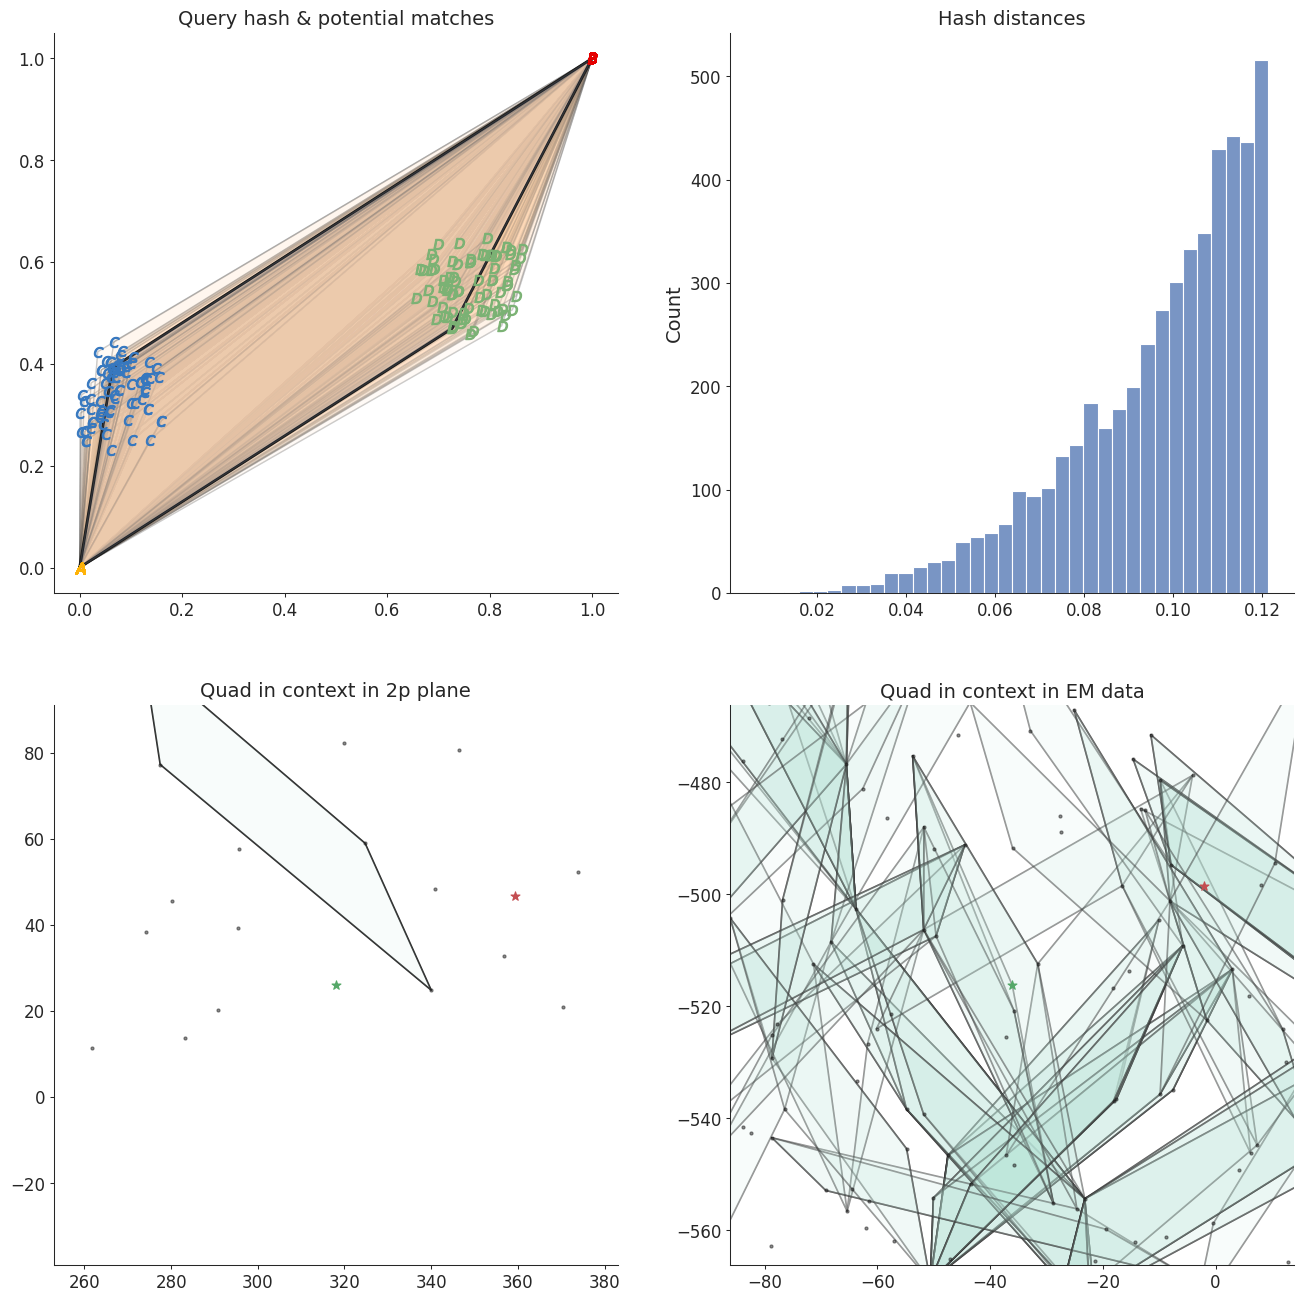

In [166]:
iPlane = 0; zoom = True
#Get 2p cells in this plane
indy = np.where(func_roi_centers[:,2] == iPlane)[0]
func_roi_xy_in_plane = func_roi_centers[indy,:2]

#Get potential EM pts for this plane
#Create query box of potential EM objects this ophys data could be coregistered to
min_um2 = min_um.copy(); 
min_um2 = min_um2 - buffer
min_um2[1] = (em_y_guesses[iPlane] - plane_buff)

max_um2 = max_um.copy()
max_um2 = max_um2 + buffer
max_um2[1] = (em_y_guesses[iPlane] + plane_buff)

#Get all cells in EM volume within bounding region
indy = np.all(nucleus_points_microns > min_um2,axis=1) & np.all(nucleus_points_microns < max_um2,axis=1)
em_xyz = nucleus_points_microns[indy]; em_xz = em_xyz[:,[0,2]]; em_y = em_xyz[:,1]

#Coregistered cells
sub_df = coreg_df.loc[coreg_df.ophys_plane == iPlane+1]
coreg_em_microns = em_client.transform_position_to_microns(np.array(sub_df[["pt_position_x","pt_position_y", "pt_position_z"]],dtype=float))

# coreg_em_microns = coreg_em_microns - em_origin
coreg_em_xz = coreg_em_microns[:,[0,2]]; coreg_em_y = coreg_em_microns[:,1]
coreg_2p_xy = np.array(sub_df[["ophys_x", "ophys_y"]],dtype=float)
    
iH = 100
dist_thresh = 0.125
center_xy = centers_2p[iH]
query_hash = hashes_2p[iH]
query_AB = AB_2p[iH]
quad_xy_local = np.vstack((np.array([[0,0],[1,1]]),query_hash.reshape(2,2)))

iCoreg = np.argmin(np.linalg.norm(coreg_2p_xy - center_xy,axis=1))   
xlim_2p = np.array([coreg_2p_xy[iCoreg,0]-65,coreg_2p_xy[iCoreg,0]+65])
ylim_2p = np.array([coreg_2p_xy[iCoreg,1]-65,coreg_2p_xy[iCoreg,1]+65])
xlim_em = np.array([coreg_em_xz[iCoreg,0]-50,coreg_em_xz[iCoreg,0]+50])
ylim_em = np.array([coreg_em_xz[iCoreg,1]-50,coreg_em_xz[iCoreg,1]+50])
    
    
#Search index for matches
distances, indices = kdt_em.query(query_hash, k=5000)

fig, axes = plt.subplots(2,2,figsize = (16,16))

axes[0,0].set_title('Query hash & potential matches')
dist_list = []
for ii, (indy, d) in enumerate(zip(indices,distances)):
    if (d < dist_thresh) & (np.abs(query_AB - AB_em[indy]) < 10):
        hash = hashes_em[indy]
        centroid = centers_em[indy]
        dist_list.append(d)
        
        #Plot zoomed in area  
        if (centroid[0] > xlim_em[0]) & (centroid[0] < xlim_em[1]) & (centroid[1] > ylim_em[0]) & (centroid[1] < ylim_em[1]):
            quad_xy_local = np.vstack((np.array([[0,0],[1,1]]),hash.reshape(2,2)))
            plot_quad(quad_xy_local,ax=axes[0,0],polygon_c=cc(ii/10))

            ax = axes[1,1]
            quad_xz = quad_em[indy]
            i_a = 0; i_b = 1; i_c = 2; i_d = 3
            ax.plot(quad_xz[np.array([i_a,i_d,i_b,i_c,i_a]),0],quad_xz[np.array([i_a,i_d,i_b,i_c,i_a]),1],color='k',alpha=0.5,zorder=1)
            poly = Polygon(quad_xz[np.array([i_a,i_d,i_b,i_c])], facecolor=cc(iPlane/6), alpha=0.1)
            ax.add_patch(poly)
         
plot_quad(quad_xy_local,ax=axes[0,0],line_alpha=1,line_width=2)

axes[0,1].set_title('Hash distances')
sns.histplot(distances,ax=axes[0,1])

axes[1,0].set_title('Quad in context in 2p plane')
ax = axes[1,0]
ax.scatter(func_roi_xy_in_plane[:,0],func_roi_xy_in_plane[:,1],color='k',marker='.',s=20,zorder=2,alpha=0.5)
roi_xy = quad_2p[iH]
i_a = 0; i_b = 1; i_c = 2; i_d = 3
ax.plot(roi_xy[np.array([i_a,i_d,i_b,i_c,i_a]),0],roi_xy[np.array([i_a,i_d,i_b,i_c,i_a]),1],color='k',zorder=1)
poly = Polygon(roi_xy[np.array([i_a,i_d,i_b,i_c])], facecolor=cc(iPlane/6), alpha=0.1)
ax.add_patch(poly)

axes[1,1].set_title('Quad in context in EM data')
ax = axes[1,1]
ax.scatter(em_xz[:,0],em_xz[:,1],color='k',marker='.',s=20,zorder=2,alpha=0.5)

for jj in range(coreg_2p_xy.shape[0]):
    color = axes[1,0].scatter(coreg_2p_xy[jj,0], coreg_2p_xy[jj,1],marker= '*', s=45,zorder=2).get_facecolors()[0]
    axes[1,1].scatter(coreg_em_xz[jj, 0], coreg_em_xz[jj, 1],facecolors=color, marker='*',s=45,zorder=2)
  
if zoom:
    iCoreg = np.argmin(np.linalg.norm(coreg_2p_xy - center_xy,axis=1))   
    axes[1,0].set_xlim([coreg_2p_xy[iCoreg,0]-65,coreg_2p_xy[iCoreg,0]+65])
    axes[1,0].set_ylim([coreg_2p_xy[iCoreg,1]-65,coreg_2p_xy[iCoreg,1]+65])
    axes[1,1].set_xlim([coreg_em_xz[iCoreg,0]-50,coreg_em_xz[iCoreg,0]+50])
    axes[1,1].set_ylim([coreg_em_xz[iCoreg,1]-50,coreg_em_xz[iCoreg,1]+50])

In [37]:
xlim_em, ylim_em

(array([-51.99376182,  48.00623818]), array([-548.46286451, -448.46286451]))

<AxesSubplot: ylabel='Count'>

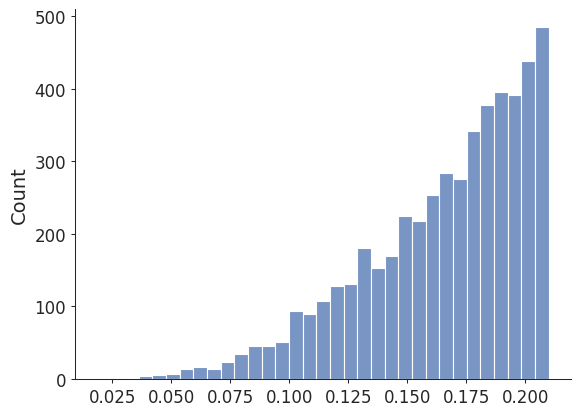

In [100]:
sns.histplot(distances)

In [71]:
np.argmin(np.linalg.norm(coreg_2p_xy - center_2p,axis=1))

3

In [72]:
np.linalg.norm(coreg_2p_xy - center_2p,axis=1)

array([356.98181779, 330.8849732 , 253.50723195, 117.08181451,
       123.43198431, 125.13783292, 174.3851609 , 172.08290787,
       210.29864825, 294.95109221, 261.64299347, 268.14295232,
       191.74834719, 182.04877508, 215.20869902])

In [167]:
pdfdoc = PdfPages(os.path.join(PlotDir,'em-2p_potential_matches_new4.pdf'))
#Get 2p cells in this plane
indy = np.where(func_roi_centers[:,2] == iPlane)[0]
func_roi_xy_in_plane = func_roi_centers[indy,:2]

#Get potential EM pts for this plane
#Create query box of potential EM objects this ophys data could be coregistered to
min_um2 = min_um.copy(); 
min_um2 = min_um2 - buffer
min_um2[1] = (em_y_guesses[iPlane] - plane_buff)

max_um2 = max_um.copy()
max_um2 = max_um2 + buffer
max_um2[1] = (em_y_guesses[iPlane] + plane_buff)

#Get all cells in EM volume within bounding region
indy = np.all(nucleus_points_microns > min_um2,axis=1) & np.all(nucleus_points_microns < max_um2,axis=1)
em_xyz = nucleus_points_microns[indy]; em_xz = em_xyz[:,[0,2]]; em_y = em_xyz[:,1]

#Coregistered cells
sub_df = coreg_df.loc[coreg_df.ophys_plane == iPlane+1]
coreg_em_microns = em_client.transform_position_to_microns(np.array(sub_df[["pt_position_x","pt_position_y", "pt_position_z"]],dtype=float))
# coreg_em_microns = coreg_em_microns - em_origin
coreg_em_xz = coreg_em_microns[:,[0,2]]; coreg_em_y = coreg_em_microns[:,1]
coreg_2p_xy = np.array(sub_df[["ophys_x", "ophys_y"]],dtype=float)

dist_thresh = 0.125
for iH, query_hash in enumerate(tqdm(hashes_2p)):
    #Extract query hash
    query_AB = AB_2p[iH]
    quad_2p_local = np.vstack((np.array([[0,0],[1,1]]),query_hash.reshape(2,2)))
    center_xy = centers_2p[iH]

    iCoreg = np.argmin(np.linalg.norm(coreg_2p_xy - center_xy,axis=1))   
    xlim_2p = np.array([coreg_2p_xy[iCoreg,0]-65,coreg_2p_xy[iCoreg,0]+65])
    ylim_2p = np.array([coreg_2p_xy[iCoreg,1]-65,coreg_2p_xy[iCoreg,1]+65])
    xlim_em = np.array([coreg_em_xz[iCoreg,0]-50,coreg_em_xz[iCoreg,0]+50])
    ylim_em = np.array([coreg_em_xz[iCoreg,1]-50,coreg_em_xz[iCoreg,1]+50])

    #Search index for matches
    distances, indices = kdt_em.query(query_hash, k=5000)

    fig, axes = plt.subplots(2,2,figsize = (16,16))
    axes[0,0].set_title('Query hash & potential matches')
    dist_list = []
    for ii, (indy, d) in enumerate(zip(indices,distances)):
        if (d < dist_thresh) & (np.abs(query_AB - AB_em[indy]) < 10):
            hash = hashes_em[indy]
            centroid = centers_em[indy]
            
            #Plot zoomed in area  
            if (centroid[0] > xlim_em[0]) & (centroid[0] < xlim_em[1]) & (centroid[1] > ylim_em[0]) & (centroid[1] < ylim_em[1]):
                quad_em_local = np.vstack((np.array([[0,0],[1,1]]),hash.reshape(2,2)))
                plot_quad(quad_em_local,ax=axes[0,0],polygon_c=cc(ii/10))

                ax = axes[1,1]
                quad_xz = quad_em[indy]
                i_a = 0; i_b = 1; i_c = 2; i_d = 3
                ax.plot(quad_xz[np.array([i_a,i_d,i_b,i_c,i_a]),0],quad_xz[np.array([i_a,i_d,i_b,i_c,i_a]),1],color='k',alpha=0.5,zorder=1)
                poly = Polygon(quad_xz[np.array([i_a,i_d,i_b,i_c])], facecolor=cc(iPlane/6), alpha=0.1)
                ax.add_patch(poly)

    plot_quad(quad_2p_local,ax=axes[0,0],line_alpha=1,line_width=2)

    axes[0,1].set_title('Hash distances')
    sns.histplot(distances,ax=axes[0,1])

    axes[1,0].set_title('Quad in context in 2p plane')
    ax = axes[1,0]
    ax.scatter(func_roi_xy_in_plane[:,0],func_roi_xy_in_plane[:,1],color='k',marker='.',s=20,zorder=2,alpha=0.5)
    roi_xy = quad_2p[iH]
    i_a = 0; i_b = 1; i_c = 2; i_d = 3
    ax.plot(roi_xy[np.array([i_a,i_d,i_b,i_c,i_a]),0],roi_xy[np.array([i_a,i_d,i_b,i_c,i_a]),1],color='k',zorder=1)
    poly = Polygon(roi_xy[np.array([i_a,i_d,i_b,i_c])], facecolor=cc(iPlane/6), alpha=0.1)
    ax.add_patch(poly)

    axes[1,1].set_title('Quad in context in EM data')
    ax = axes[1,1]
    ax.scatter(em_xz[:,0],em_xz[:,1],color='k',marker='.',s=20,zorder=2,alpha=0.5)

    for jj in range(coreg_2p_xy.shape[0]):
        color = axes[1,0].scatter(coreg_2p_xy[jj,0], coreg_2p_xy[jj,1],marker= '*', s=45,zorder=2).get_facecolors()[0]
        axes[1,1].scatter(coreg_em_xz[jj, 0], coreg_em_xz[jj, 1],facecolors=color, marker='*',s=45,zorder=2)
    
    if zoom:
        iCoreg = np.argmin(np.linalg.norm(coreg_2p_xy - center_xy,axis=1))   
        axes[1,0].set_xlim(xlim_2p)
        axes[1,0].set_ylim(ylim_2p)
        axes[1,1].set_xlim(xlim_em)
        axes[1,1].set_ylim(ylim_em)

    pdfdoc.savefig(fig)
    plt.close(fig)
pdfdoc.close()



  0%|          | 0/5759 [00:00<?, ?it/s]

In [85]:
len(center_2p)

2962

In [57]:
    ax.scatter(func_roi_xy_in_plane[:,0],func_roi_xy_in_plane[:,1],color='k',marker='.',s=20,zorder=2)

    ax.set_xlabel('Ophys-x')
    if iPlane == 0:
        ax.set_ylabel('Ophys-y')

    hash_index = np.array([t['index'] for t in hash_list])
    for iRoi in range(nCells):
        indy = np.where(hash_index == iRoi)[0]
        for ii in np.random.choice(indy,2):
            roi_xy = hash_list[ii]['ophys_xy']
            i_a = 0; i_b = 1; i_c = 2; i_d = 3
            ax.plot(roi_xy[np.array([i_a,i_d,i_b,i_c,i_a]),0],roi_xy[np.array([i_a,i_d,i_b,i_c,i_a]),1],color='k',alpha=0.25,zorder=1)
            poly = Polygon(roi_xy[np.array([i_a,i_d,i_b,i_c])], facecolor=cc(iPlane/6), alpha=0.1)
            ax.add_patch(poly)

array([0.07750835, 0.22886573, 0.25482787, 0.26438023, 0.27420481,
       0.29695385, 0.30475542, 0.30531649, 0.3072071 , 0.32369244])

In [ ]:
dist_thresh = 0.15

pdfdoc = PdfPages(os.path.join(PlotDir,'similar_hashes3.pdf'))
for iHash in indy_list:
    hash = hashes[iHash]
    quad_xy_local = np.vstack((np.array([[0,0],[1,1]]),hash.reshape(2,2)))
    i_a = 0; i_b = 1; i_c = 2; i_d = 3
    
    #Query tree
    distances, indices = hash_kdt.query(hash, k=11)
    
    #Plot main hash
    fig, ax = plt.subplots(figsize=(8,8))
    plot_quad(quad_xy_local,ax=ax,polygon_c=cc(0))
    
    #Plot similar hashes
    for ii, (indy, d) in enumerate(zip(indices[1:],distances[1:])):
        if d < dist_thresh:
            hash = hashes[indy]
            plane = hash_planes[indy]
            quad_xy_local = np.vstack((np.array([[0,0],[1,1]]),hash.reshape(2,2)))
            plot_quad(quad_xy_local,ax=ax,polygon_c=cc(ii/10),label=f'Hash {indy}, plane {plane}')
    ax.legend()
    pdfdoc.savefig(fig)
    plt.close(fig)
            
pdfdoc.close()
    
    
    
    

## Construct 3D grid of EM data

In [ ]:
# How many cells are within a volume specified by grid_size?
grid_size = 32
scalar = 1E3

em_xyz_min = np.min(nucleus_pts,axis=0)
em_xyz_max = np.max(nucleus_pts,axis=0)

em_volume_nm = em_xyz_max-em_xyz_min
grid_cellnum = np.round(em_volume_nm/scalar/grid_size)
print(em_volume_nm/scalar,'microns')
print('# of grids per dimension: ',grid_cellnum)

In [ ]:
# Match cells used for creating co-registration transform to nucleus location 
em_kdt = KDTree(nucleus_pts)

grid_boundaries = [np.arange(em_xyz_min[i],em_xyz_max[i],grid_size*scalar) for i in range(3)]
nCells_per_grid = np.zeros([len(g) for g in grid_boundaries])

coreg_dict = {}
for iX, x_bound in enumerate(grid_boundaries[0]):
    for iY, y_bound in enumerate(grid_boundaries[1]):
        for iZ, z_bound in enumerate(grid_boundaries[2]):
            #Get grid boundaries and center
            grid_xyz_min = np.array([x_bound,y_bound,z_bound])
            grid_xyz_max = grid_xyz_min + grid_size*scalar
            grid_xyz_ctr = grid_xyz_min + grid_size*scalar/2

            #Use center to query em table
            distances, indices = em_kdt.query(grid_xyz_ctr, k=100)
            
            #Of these 100 points, how many are within the grid volume?
            nPts = np.sum((np.all(nucleus_pts[indices] >= grid_xyz_min,axis=1)) & (np.all(nucleus_pts[indices] < grid_xyz_max,axis=1)))
            nCells_per_grid[iX,iY,iZ] = nPts
            if nPts > 0:
                indy = indices[(np.all(nucleus_pts[indices] >= grid_xyz_min,axis=1)) & (np.all(nucleus_pts[indices] < grid_xyz_max,axis=1))]
                nucleus_ids_in_grid = nucleus_ids[indy]
                for id in nucleus_ids_in_grid:
                    if id in coreg_em_ids:
                        coreg_dict[id] = (iX,iY,iZ) #Save grid location         

In [ ]:
#If we did this right, the total sum of "nCells_per_grid" should be equal to the # of em pts in the table
np.sum(nCells_per_grid.ravel()) == len(nucleus_table)

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
cc,tt = np.unique(nCells_per_grid.ravel(),return_counts=True)
# sns.barplot(cc, tt,ax=ax)
ax.bar(cc, tt)
ax.set_xticks(cc)
ax.set_xlabel(f'# of em points per {grid_size}x{grid_size}x{grid_size}micron grid volume')
ax.set_ylabel('Counts')

In [ ]:
labels = ['x','y','z']
coreg_gridlocs = np.stack(coreg_dict.values())

fig, axes = plt.subplots(1,3,figsize = (9,3))
plt.suptitle('Co-registered cells grid locations')
for i in range(3):
    sns.histplot(coreg_gridlocs[:,i],ax=axes[i])
    axes[i].set_xlabel(f'{labels[i]} grid #')

## Within each grid, create quads of nucleus points
Set distance between the 2 most distant points to be 1 - sqrt(2) times that of the side-length -f the grid-cells

In [ ]:
# Match cells used for creating co-registration transform to nucleus location 
em_kdt = KDTree(nucleus_pts)

grid_boundaries = [np.arange(em_xyz_min[i],em_xyz_max[i],grid_size*scalar) for i in range(3)]
nCells_per_grid = np.zeros([len(g) for g in grid_boundaries])

coreg_dict = {}
for iX, x_bound in enumerate(grid_boundaries[0]):
    for iY, y_bound in enumerate(grid_boundaries[1]):
        for iZ, z_bound in enumerate(grid_boundaries[2]):

            #Get grid boundaries and center
            grid_xyz_min = np.array([x_bound,y_bound,z_bound])
            grid_xyz_max = grid_xyz_min + grid_size*scalar
            grid_xyz_ctr = grid_xyz_min + grid_size*scalar/2

            #Use center to query em table
            distances, indices = em_kdt.query(grid_xyz_ctr, k=100)
            
            #Of these 100 points, how many are within the grid volume?
            nPts = np.sum((np.all(nucleus_pts[indices] >= grid_xyz_min,axis=1)) & (np.all(nucleus_pts[indices] < grid_xyz_max,axis=1)))
            nCells_per_grid[iX,iY,iZ] = nPts

            #This grid has points within it
            if nPts > 0:
                indy = indices[(np.all(nucleus_pts[indices] >= grid_xyz_min,axis=1)) & (np.all(nucleus_pts[indices] < grid_xyz_max,axis=1))]
                nucleus_ids_in_grid = nucleus_ids[indy]
                nucleus_pts_in_grid = nucleus_pts[indy]

                if nPts >= 5:
                    pdb.set_trace()

                

   

In [ ]:
distances, indices = em_kdt.query(nucleus_pts_in_grid[0], k=10)


In [ ]:
nucleus_pts_in_grid

In [ ]:
xyz = nucleus_pts_in_grid


In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], marker='o')
ax.set_xlim(grid_xyz_min[0]-5*scalar,grid_xyz_max[0]+5*scalar)
ax.set_ylim(grid_xyz_min[1]-5*scalar,grid_xyz_max[1]+5*scalar)
ax.set_zlim(grid_xyz_min[2]-5*scalar,grid_xyz_max[2]+5*scalar)

In [ ]:
quad_indy = np.random.choice(nPts,4,replace=False)
plot_quad = np.concatenate((quad_indy,[quad_indy[0]]))
quad_indy

In [ ]:

CD

In [ ]:
dist_mat = np.zeros((4,4))
for ii, iPt in enumerate(quad_indy):
    for jj, jPt in enumerate(quad_indy):
        if ii > jj:
            continue
        dist_mat[ii,jj] = np.linalg.norm(xyz[iPt] - xyz[jPt])
# sns.heatmap(dist_mat/scalar,annot=True)
AB = np.squeeze(np.where(dist_mat == np.max(dist_mat)))

#define coordinates with pts A & B
AB_indy = quad_indy[AB]
pt_A = xyz[AB_indy[0]]
pt_B = xyz[AB_indy[1]]

CD_indy = quad_indy[np.setxor1d(np.arange(4),AB)]

#Define pt C
CD_tmp = xyz[CD_indy]
C_indy = np.argmin(CD_tmp[:,1])
D_indy = np.argmax(CD_tmp[:,1])
pt_C = CD_tmp[C_indy]
pt_D = CD_tmp[D_indy]


quad_hash = np.concatenate((pt_C - pt_A,pt_D - pt_A))
quad_hash

In [ ]:
import plotly.graph_objs as go

# create the trace
scatter_trace = go.Scatter3d(
    x=xyz[:,0],
    y=xyz[:,1],
    z=xyz[:,2],
    mode='markers',
    # marker=dict(
    #     size=5,
    #     color='k',
    #     # colorscale='Viridis',
    #     # opacity=0.8
    # )
)

# create the layout
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='EM-X'),
        yaxis=dict(title='EM-Y'),
        zaxis=dict(title='EM-Z')
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)


polygon_trace = go.Scatter3d(
    x=[xyz[i,0] for i in plot_quad],
    y=[xyz[i,1] for i in plot_quad],
    z=[xyz[i,2] for i in plot_quad],
    mode='lines',
    line=dict(color='red', width=3),
    opacity=0.5
)

# create the figure
fig = go.Figure(data=[scatter_trace, polygon_trace])

# set the layout
fig.update_layout(scene=dict(
        xaxis_title='EM-X',
        yaxis_title='EM-Y',
        zaxis_title='EM-Z'),
        autosize=False,width=750, height=750,
        ) #margin=dict(l=50,r=50,b=100, t=100, pad=4)


In [ ]:
## Load functional data
base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data" #Server
base_folder = "/data/v1dd_in_vivo_new_segmentation" # Local on robinson for golden mouse
ophys_client = OPhysClient(base_folder)

##===== Load session from golden mouse =====##
mouse_id = 409828; col = 1; vol = 3; plane = 3

sess = ophys_client.load_ophys_session(mouse=mouse_id, column=col, volume=vol)
print(f"Loaded ophys session {sess.get_session_id()} (mouse {sess.get_mouse_id()}, column {sess.get_column_id()}, volume {sess.get_volume_id()})")


In [ ]:
#Get depths for each volume/plane

depth_dict = {}
depth_list = []
col = 1
for vol in range(1,10):
    ophys_session_id = f'M409828_1{vol}'
    session = ophys_client.load_ophys_session(session_id=ophys_session_id)

    if vol <= 5:
        planemax = 7
    else:
        planemax = 2
    for plane in range(1,planemax):
        depth = session.get_plane_depth(plane)
        depth_list.append((1,vol,plane,depth))
        depth_dict[(col,vol,plane)] = depth
depths_df = pd.DataFrame(np.array(depth_list),columns=['column','volume','plane','depth'])


In [ ]:
from allen_v1dd.stimulus_analysis import analysis_tools as at
metrics = at.load_roi_metrics('/home/david.wyrick/Git/allen_v1dd/data_frames/v1dd_metrics.csv',remove_duplicates=False)
metrics['volume'].unique()

In [ ]:
n_planes = []
for ii,row in tqdm(metrics.iterrows()):
    if np.isnan(row.duplicate_rois):
        continue
    n_planes.append(len(row.duplicate_rois))

In [ ]:
from nglui.statebuilder.helpers import make_neuron_neuroglancer_link
import caveclient
#Find the corresponding em nucleus location
cave_client = caveclient.CAVEclient('v1dd')

# you can use it to just visualize a single neuron
url=make_neuron_neuroglancer_link(cave_client, 864691132826115475, return_as='html')
url

In [ ]:
tmp = np.unique(metrics['n_duplicates'].values,return_counts=True)

plt.figure(figsize=(8,8))
plt.title('Column 1')
plt.bar(tmp[0],tmp[1])
plt.xlabel('# of planes')

for ii,t in zip(*tmp):
    plt.text(ii-0.25,t+100,t)